In [ ]:
!pip install beir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Created wheel for beir: filename=beir-2.0.0-py3-none-any.whl size=63550 sha256=6caf2b221e6e49522c877c37c433330270297d211cdc9f07e14f49e4b446cc94
  Stored in directory: /root/.cache/pip/wheels/1c/14/96/c606ede3c10e9300ef771a6183af09d389459195ff5f854862
  Created wheel for 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from beir import util, LoggingHandler
from beir.retrieval import models
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

import logging
import pathlib, os

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

#### Download NFCorpus.zip dataset and unzip the dataset
dataset = "nfcorpus"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
out_dir = os.path.join(pathlib.Path('./').parent.absolute(), "datasets")
data_path = util.download_and_unzip(url, out_dir)

#### Provide the data_path where NFCorpus has been downloaded and unzipped
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

/content/datasets/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

  0%|          | 0/3633 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
data = pd.DataFrame.from_dict(corpus, orient='index')
data['doc_id'] = data.index
data.reset_index(drop=True, inplace=True)
data.head()

text  \
0  Recent studies have suggested that statins, an...   
1  BACKGROUND: Preclinical studies have shown tha...   
2  The aims of this study were to determine the c...   
3  Epilepsy or seizure disorder is one of the mos...   
4  Hit Reaction Time latencies (HRT) in the Conti...   

                                               title   doc_id  
0  Statin Use and Breast Cancer Survival: A Natio...   MED-10  
1  Statin use after diagnosis of breast cancer an...   MED-14  
2  Alkylphenols in human milk and their relations...  MED-118  
3  Methylmercury: A Potential Environmental Risk ...  MED-301  
4  Sensitivity of Continuous Performance Test (CP...  MED-306

In [ ]:
queries = pd.DataFrame.from_dict(queries, orient='index', columns=['query_text'])
queries['query_id'] = queries.index
queries.reset_index(drop=True, inplace=True)
queries.head()

query_text  query_id
0   Do Cholesterol Statin Drugs Cause Breast Cancer?   PLAIN-2
1                Exploiting Autophagy to Live Longer  PLAIN-12
2  How to Reduce Exposure to Alkylphenols Through...  PLAIN-23
3          What’s Driving America’s Obesity Problem?  PLAIN-33
4              Who Should be Careful About Curcumin?  PLAIN-44

In [ ]:
flat_qrels = [{'query_id': query_id, 'doc_id': doc_id, 'relevance': relevance}
              for query_id, inner_dict in qrels.items()
              for doc_id, relevance in inner_dict.items()]

qrels_df = pd.DataFrame(flat_qrels)
qrels_df.sample(20)

query_id    doc_id  relevance
7032   PLAIN-1805  MED-1731          1
98       PLAIN-23  MED-3586          1
5226   PLAIN-1453  MED-1540          1
9731   PLAIN-2332  MED-3311          1
2858    PLAIN-827  MED-3630          1
10469  PLAIN-2590  MED-3858          1
2548    PLAIN-731  MED-3089          1
7655   PLAIN-1909  MED-3175          1
11751  PLAIN-3271  MED-3242          1
1697    PLAIN-531  MED-4595          1
10862  PLAIN-2710  MED-5062          1
8669   PLAIN-2061  MED-2398          1
4560   PLAIN-1398  MED-1643          1
320      PLAIN-68  MED-4130          1
11194  PLAIN-2800  MED-4070          1
9631   PLAIN-2261  MED-4984          1
11779  PLAIN-3271  MED-1620          1
4977   PLAIN-1441  MED-4551          1
12280  PLAIN-3462  MED-1634          1
2541    PLAIN-731  MED-2983          1

# PART I: Preprocessing

Lowercase Text: Convert text to lowercase for uniformity.
- Remove HTML Tags: Use BeautifulSoup to strip any HTML tags present in the text.
- Remove URLs: Use a regex to detect and remove URLs.
Remove Numbers: Remove all numeric characters to avoid irrelevant data for term analysis.
- Remove Punctuation and Symbols: Retain only alphanumeric characters and spaces.
- Tokenize: Break down the text into individual tokens (words).
- Remove Stopwords and Apply Stemming
- Remove common stopwords using SpaCy's English stopword list.
- Apply Porter stemming to reduce words to their root forms.

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import spacy
from functools import lru_cache
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import logging
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F700-\U0001F77F"  # alchemical symbols
    u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    u"\U0001FA00-\U0001FA6F"  # Chess Symbols
    u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    u"\U00002702-\U000027B0"  # Dingbats
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+",
    flags=re.UNICODE,
)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

stemmer = PorterStemmer()

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def preprocess_text(text):
    try:
        # 1. Remove HTML tags and lowercase
        text = BeautifulSoup(text, "html.parser").get_text().lower()
        # 2. Remove URLs
        text = re.sub(r'http\S+|www\.\S+', '', text)
        # 3. Remove emoji
        text = emoji_pattern.sub(r'', text)
        # 4. Tokenize with SpaCy
        doc = nlp(text)
        # 5. Remove stopwords, punctuation, numbers, and normalize repeated characters
        tokens = [
            normalize_repeated_chars(token.text)
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_digit and not token.is_space
        ]
        # Stemming
        processed_tokens = [stemmer.stem(token) for token in tokens]
        return processed_tokens
    except Exception as e:
        logging.error(f"Error processing text: {text}\nError: {e}")
        return []


data['processed_text'] = data['text'].apply(preprocess_text)

data['term_count_original'] = data['text'].apply(lambda x: len(word_tokenize(x)))
data['term_count_processed'] = data['processed_text'].apply(len)


print(data[['doc_id', 'term_count_original', 'term_count_processed', 'processed_text']].head())


    doc_id  term_count_original  term_count_processed  \
0   MED-10                  285                   170   
1   MED-14                  284                   160   
2  MED-118                  210                   124   
3  MED-301                  199                   110   
4  MED-306                  312                   164   

                                      processed_text  
0  [recent, studi, suggest, statin, establish, dr...  
1  [background, preclin, studi, shown, statin, pa...  
2  [aim, studi, determin, concentr, nonylphenol, ...  
3  [epilepsi, seizur, disord, common, neurolog, d...  
4  [hit, reaction, time, latenc, hrt, continu, pe...  


In [ ]:
output_file = "processed_data.csv"
data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

Processed data saved to processed_data.csv


In [ ]:
input_file = "processed_data.csv"

data = pd.read_csv(input_file)

print(data.head())

                                                text  \
0  Recent studies have suggested that statins, an...   
1  BACKGROUND: Preclinical studies have shown tha...   
2  The aims of this study were to determine the c...   
3  Epilepsy or seizure disorder is one of the mos...   
4  Hit Reaction Time latencies (HRT) in the Conti...   

                                               title   doc_id  \
0  Statin Use and Breast Cancer Survival: A Natio...   MED-10   
1  Statin use after diagnosis of breast cancer an...   MED-14   
2  Alkylphenols in human milk and their relations...  MED-118   
3  Methylmercury: A Potential Environmental Risk ...  MED-301   
4  Sensitivity of Continuous Performance Test (CP...  MED-306   

                                      processed_text  term_count_original  \
0  ['recent', 'studi', 'suggest', 'statin', 'esta...                  285   
1  ['background', 'preclin', 'studi', 'shown', 's...                  284   
2  ['aim', 'studi', 'determin', 'concentr

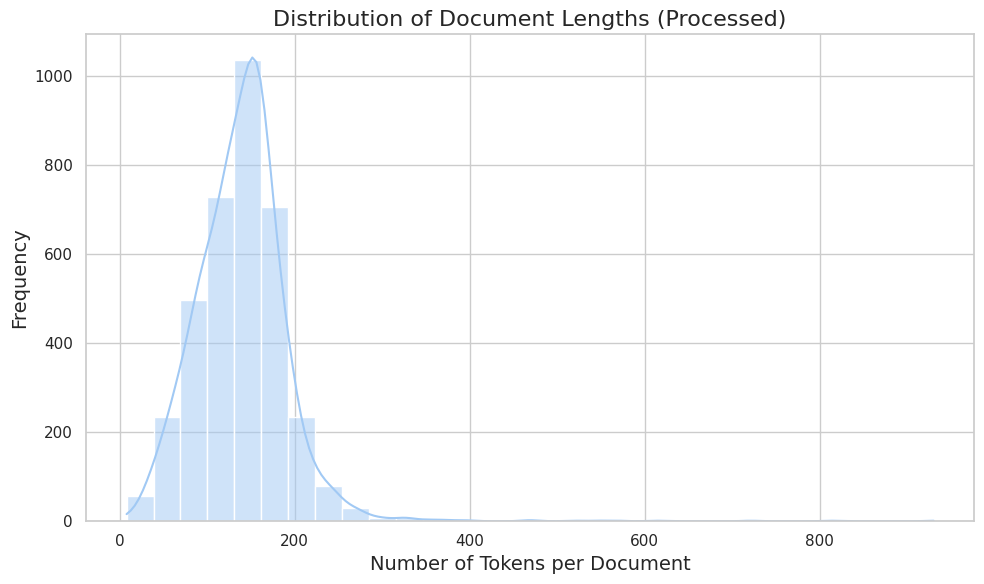

In [ ]:
sns.set(style="whitegrid")
palette = sns.color_palette("pastel")

plt.figure(figsize=(10, 6))
sns.histplot(data['term_count_processed'], bins=30, kde=True, color=palette[0])

plt.title("Distribution of Document Lengths (Processed)", fontsize=16)
plt.xlabel("Number of Tokens per Document", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()

plt.show()

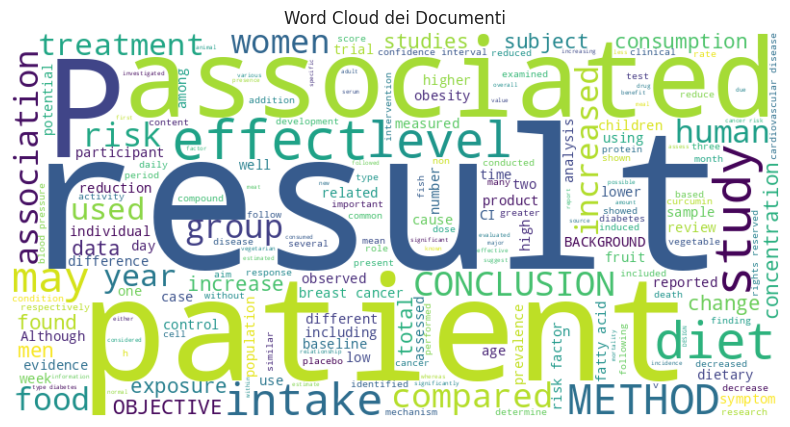

In [ ]:
text_data = " ".join(data['text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dei Documenti")
plt.show()

In [ ]:
print("Numero totale di query:", queries.shape[0])
queries['query_length'] = queries['query_text'].apply(lambda x: len(x.split()))

Numero totale di query: 323


- Calculate the first and third quartiles of the document length distribution.  
- Compute the difference.  
- The lower limit for considering a value as an outlier is defined as Q1 - 1.5 * IQR.  
- The upper limit for outliers is calculated as Q3 + 1.5 * IQR.  
- Boxplot.

Number of outliers: 67


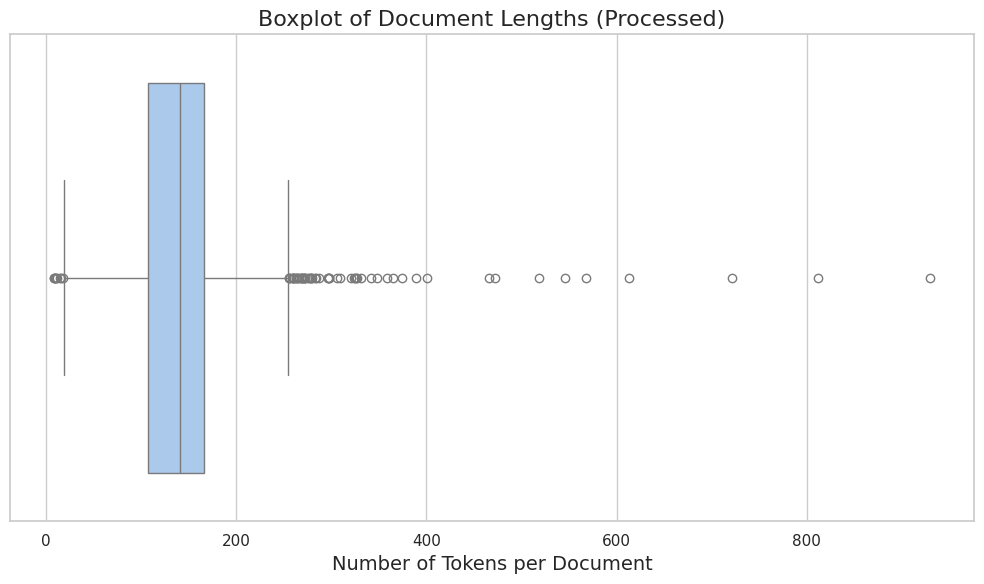

In [ ]:
q1 = np.percentile(data['term_count_processed'], 25)
q3 = np.percentile(data['term_count_processed'], 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = data[(data['term_count_processed'] < lower_bound) | (data['term_count_processed'] > upper_bound)]


print(f"Number of outliers: {len(outliers)}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['term_count_processed'], palette="pastel")

plt.title("Boxplot of Document Lengths (Processed)", fontsize=16)
plt.xlabel("Number of Tokens per Document", fontsize=14)
plt.tight_layout()

plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stemmer = PorterStemmer()

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def preprocess_query(query):
    try:
        query = BeautifulSoup(query, "html.parser").get_text().lower()
        query = re.sub(r'http\S+|www\.\S+', '', query)
        query = emoji_pattern.sub(r'', query)
        doc = nlp(query)
        tokens = [
            normalize_repeated_chars(token.text)
            for token in doc
            if not token.is_punct and not token.is_digit and not token.is_space
        ]
        processed_tokens = [stemmer.stem(token) for token in tokens]  # Stemming
        return processed_tokens
    except Exception as e:
        logging.error(f"Error processing query: {query}\nError: {e}")
        return []

queries['processed_query'] = queries['query_text'].apply(preprocess_query)
queries['term_count_original'] = queries['query_text'].apply(lambda x: len(word_tokenize(x)))
queries['term_count_processed'] = queries['processed_query'].apply(len)

output_file = "processed_queries.csv"
queries.to_csv(output_file, index=False)


print(queries[['query_id', 'term_count_original', 'term_count_processed', 'processed_query']].head())

   query_id  term_count_original  term_count_processed  \
0   PLAIN-2                    8                     7   
1  PLAIN-12                    5                     5   
2  PLAIN-23                    9                     9   
3  PLAIN-33                   10                     7   
4  PLAIN-44                    7                     6   

                                     processed_query  
0  [do, cholesterol, statin, drug, caus, breast, ...  
1             [exploit, autophagi, to, live, longer]  
2  [how, to, reduc, exposur, to, alkylphenol, thr...  
3      [what, ’s, drive, america, ’s, obes, problem]  
4           [who, should, be, care, about, curcumin]  


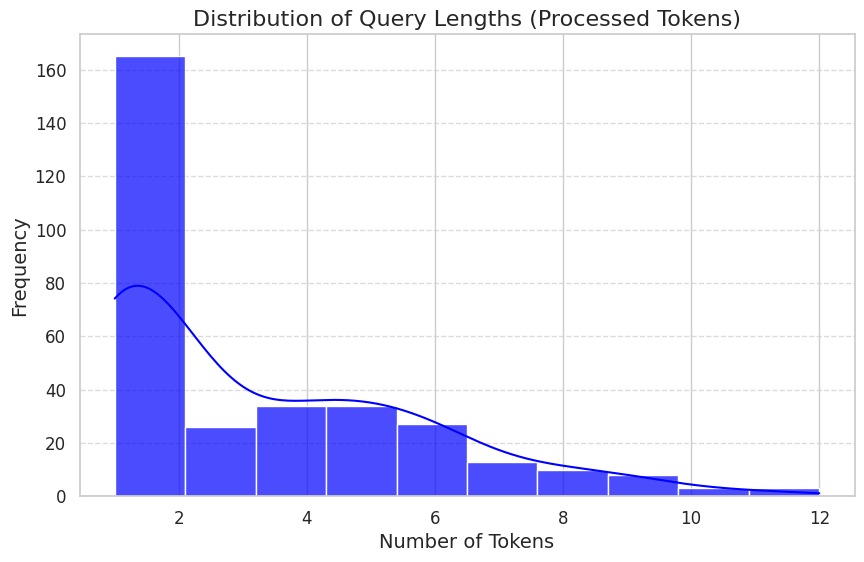

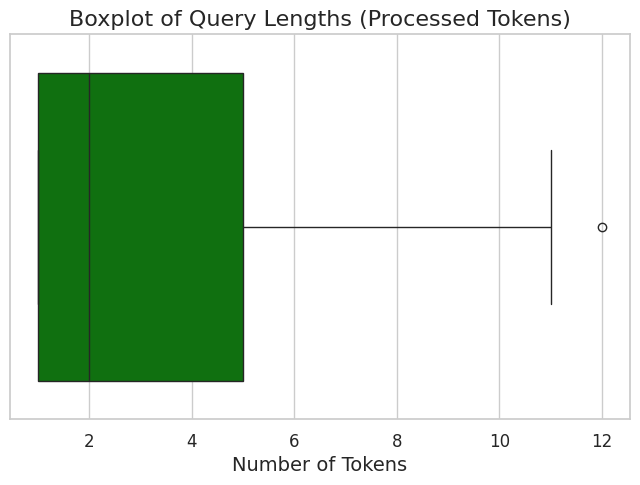

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(queries['term_count_processed'], bins=10, kde=True, color="blue", alpha=0.7)
plt.title('Distribution of Query Lengths (Processed Tokens)', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=queries['term_count_processed'], color="green")
plt.title('Boxplot of Query Lengths (Processed Tokens)', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.xticks(fontsize=12)
plt.show()

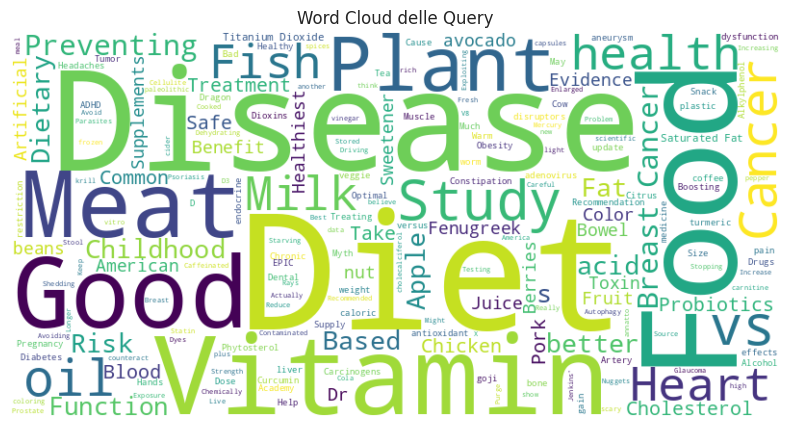

In [ ]:
query_text_data = " ".join(queries['query_text'].tolist())
wordcloud_queries = WordCloud(width=800, height=400, background_color='white').generate(query_text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_queries, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud delle Query")
plt.show()

We'll plot a histogram to understand the distribution of relevance labels. This helps us see the range of values and their frequencies.

How many relevant documents do we have for each query?

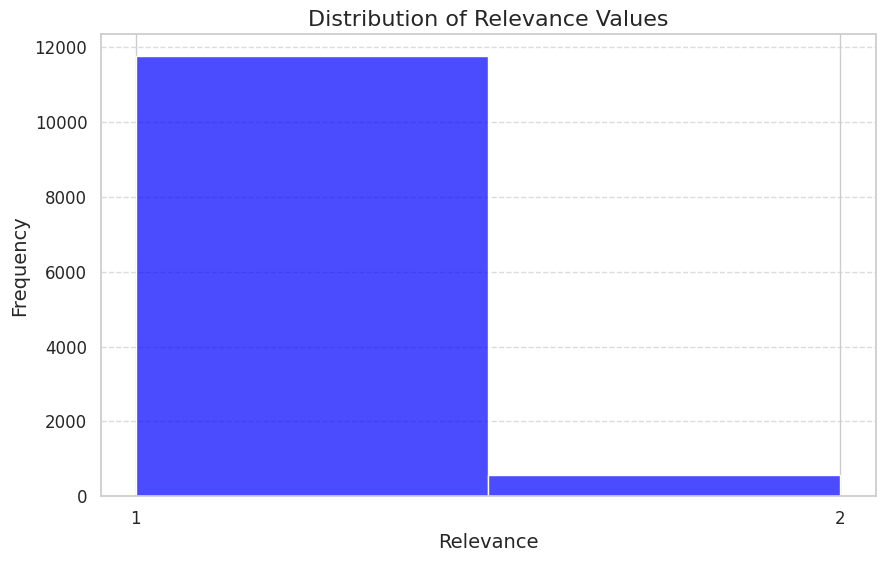

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(qrels_df['relevance'], bins=[1, 1.5, 2], kde=False, color='blue', alpha=0.7)
plt.title('Distribution of Relevance Values', fontsize=16)
plt.xlabel('Relevance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks([1, 2], fontsize=12)  # Only show ticks for 1 and 2
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

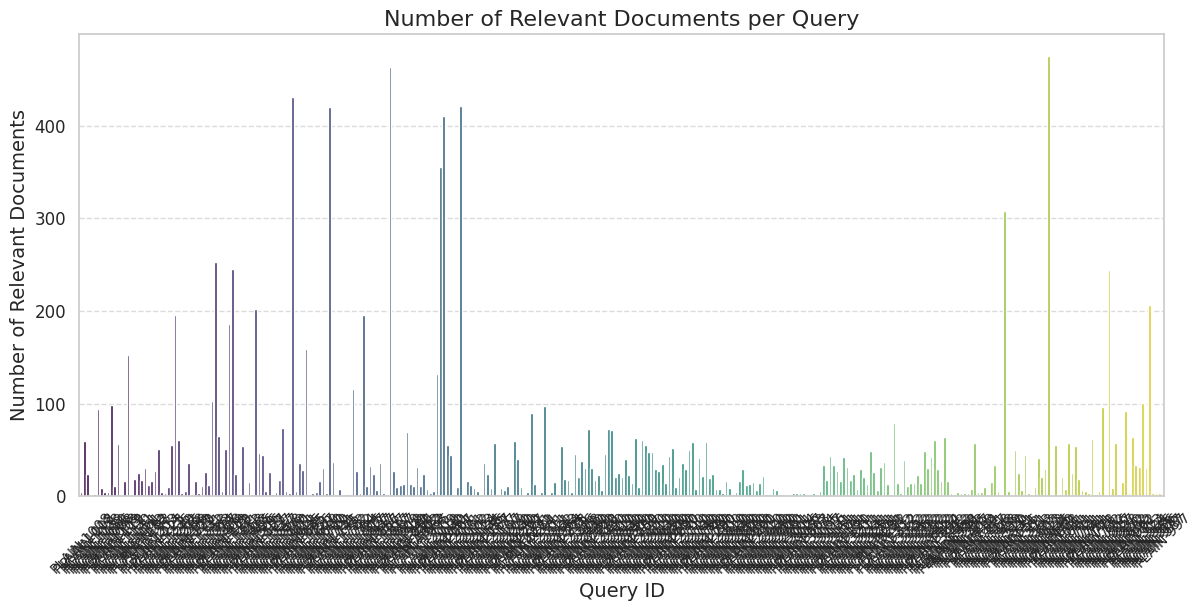

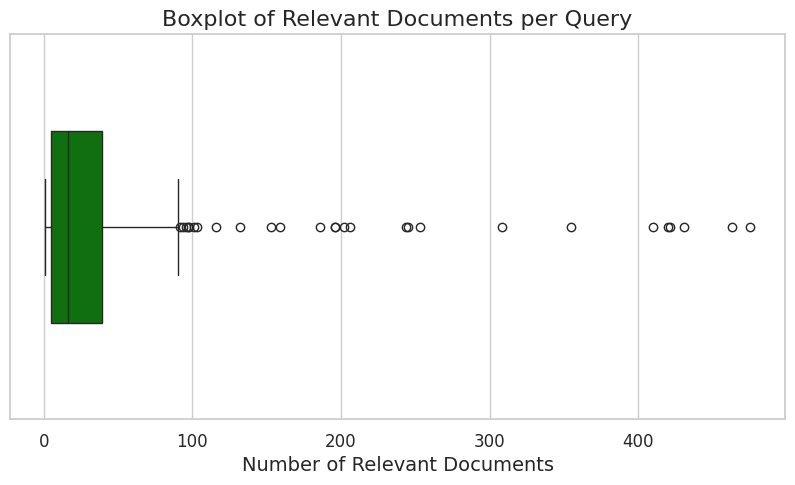

In [ ]:
# Count relevant documents (relevance = 1 or 2) for each query
relevant_counts = qrels_df[qrels_df['relevance'] >= 1].groupby('query_id').size().reset_index(name='relevant_docs')

plt.figure(figsize=(14, 6))
sns.barplot(data=relevant_counts, x='query_id', y='relevant_docs', palette='viridis')
plt.title('Number of Relevant Documents per Query', fontsize=16)
plt.xlabel('Query ID', fontsize=14)
plt.ylabel('Number of Relevant Documents', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=relevant_counts['relevant_docs'], color="green", width=0.5)
plt.title('Boxplot of Relevant Documents per Query', fontsize=16)
plt.xlabel('Number of Relevant Documents', fontsize=14)
plt.xticks(fontsize=12)
plt.show()


In [ ]:
queries_with_high_relevance = relevant_counts[relevant_counts['relevant_docs'] > 300]

num_high_relevance_queries = len(queries_with_high_relevance)
print(f"Number of queries with more than 300 relevant documents: {num_high_relevance_queries}")

high_relevance_query_texts = queries_with_high_relevance.merge(queries, on='query_id', how='left')


print("Queries with more than 300 relevant documents:")
print(high_relevance_query_texts[['query_id', 'query_text', 'processed_query', 'relevant_docs']])

Number of queries with more than 300 relevant documents: 8
Queries with more than 300 relevant documents:
     query_id            query_text    processed_query  relevant_docs
0  PLAIN-1635                  milk             [milk]            431
1  PLAIN-1741                  nuts              [nut]            420
2  PLAIN-1909                  pork             [pork]            463
3  PLAIN-2051         saturated fat       [satur, fat]            355
4  PLAIN-2061               seafood          [seafood]            410
5  PLAIN-2102               smoking            [smoke]            421
6   PLAIN-531  alternative medicine  [altern, medicin]            308
7   PLAIN-660                 beans             [bean]            475


In [ ]:
doc_relevance_counts = qrels_df.groupby('doc_id').size().reset_index(name='relevance_judgments')

most_relevant_docs = doc_relevance_counts.sort_values(by='relevance_judgments', ascending=False).head(20)
least_relevant_docs = doc_relevance_counts.sort_values(by='relevance_judgments', ascending=True).head(20)

print("Documents with the most relevance judgments:")
print(most_relevant_docs)

Documents with the most relevance judgments:
        doc_id  relevance_judgments
3062  MED-5337                   37
3066  MED-5341                   34
3052  MED-5326                   29
3057  MED-5331                   29
3058  MED-5332                   29
3054  MED-5328                   29
3059  MED-5333                   28
3055  MED-5329                   28
3074  MED-5363                   28
3063  MED-5338                   28
3060  MED-5334                   28
3061  MED-5335                   28
3056  MED-5330                   28
3051  MED-5325                   28
3067  MED-5342                   28
3053  MED-5327                   28
3065  MED-5340                   28
3064  MED-5339                   28
3048  MED-5322                   28
3049  MED-5323                   28


In [ ]:
print("\nDocuments with the fewest relevance judgments:")
print(least_relevant_docs)


Documents with the fewest relevance judgments:
        doc_id  relevance_judgments
602   MED-1819                    1
603   MED-1820                    1
614   MED-1836                    1
615   MED-1837                    1
616   MED-1838                    1
3120   MED-986                    1
19    MED-1116                    1
20    MED-1118                    1
647   MED-1873                    1
648   MED-1874                    1
596   MED-1811                    1
597   MED-1812                    1
598   MED-1813                    1
599   MED-1814                    1
600   MED-1817                    1
601   MED-1818                    1
637   MED-1862                    1
638   MED-1863                    1
640   MED-1865                    1
641   MED-1866                    1


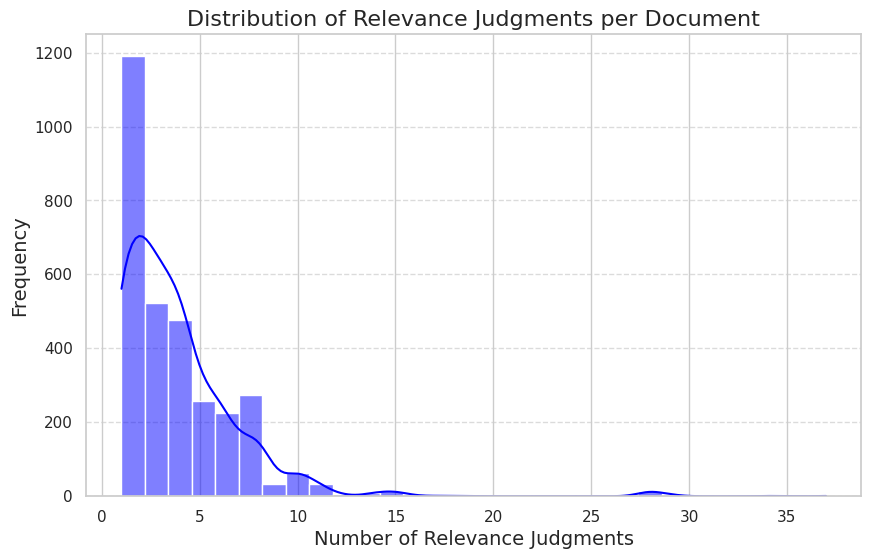

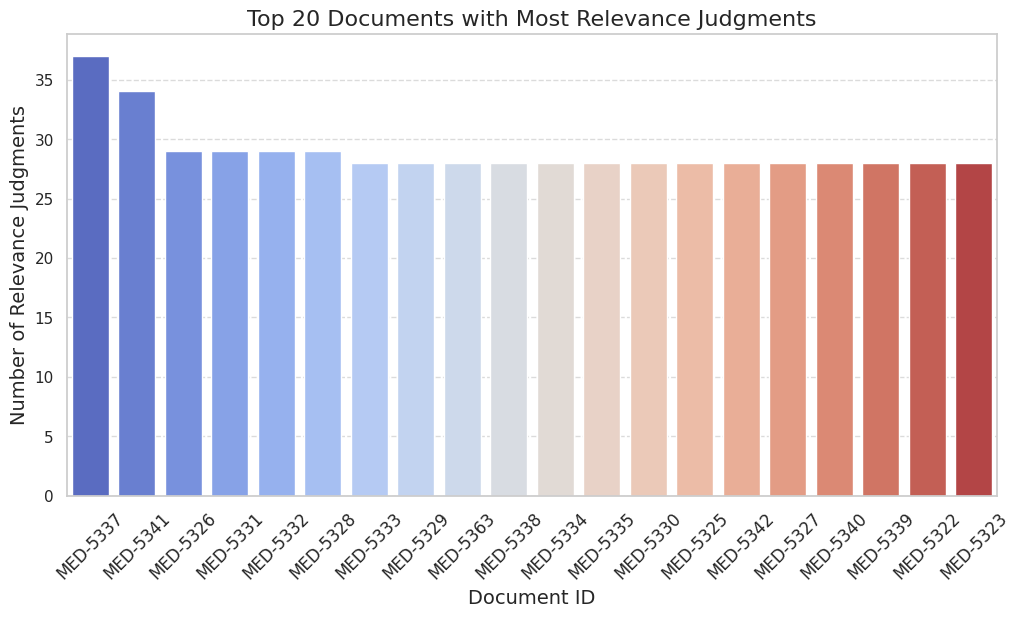

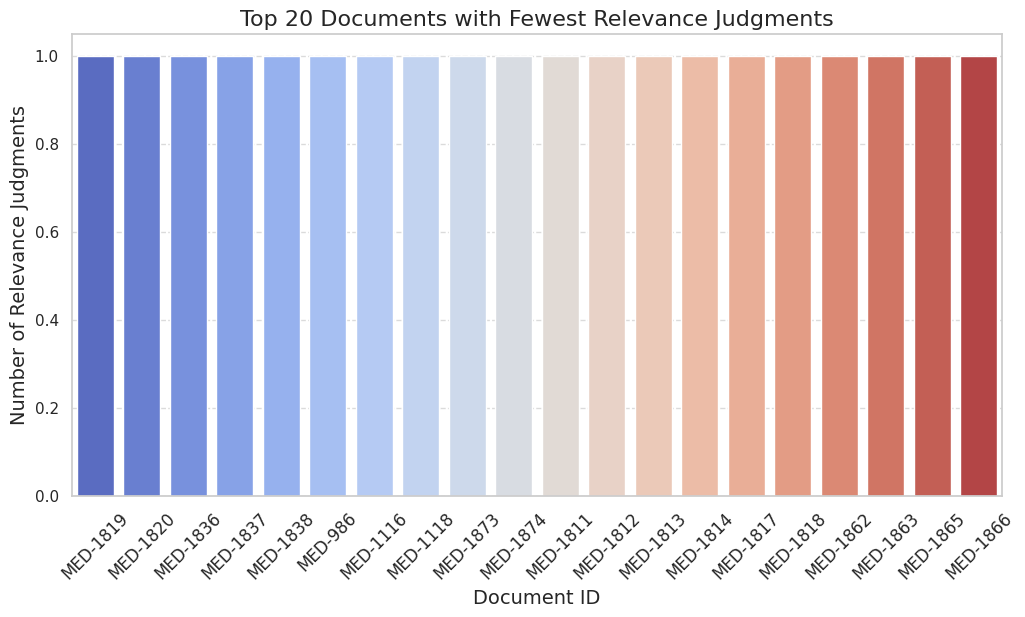

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(doc_relevance_counts['relevance_judgments'], bins=30, kde=True, color='blue')
plt.title('Distribution of Relevance Judgments per Document', fontsize=16)
plt.xlabel('Number of Relevance Judgments', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=most_relevant_docs, x='doc_id', y='relevance_judgments', palette='coolwarm')
plt.title('Top 20 Documents with Most Relevance Judgments', fontsize=16)
plt.xlabel('Document ID', fontsize=14)
plt.ylabel('Number of Relevance Judgments', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=least_relevant_docs, x='doc_id', y='relevance_judgments', palette='coolwarm')
plt.title('Top 20 Documents with Fewest Relevance Judgments', fontsize=16)
plt.xlabel('Document ID', fontsize=14)
plt.ylabel('Number of Relevance Judgments', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
most_relevant_docs_full = most_relevant_docs.merge(data, on='doc_id', how='inner')

combined_text = ' '.join(most_relevant_docs_full['processed_text'].explode())

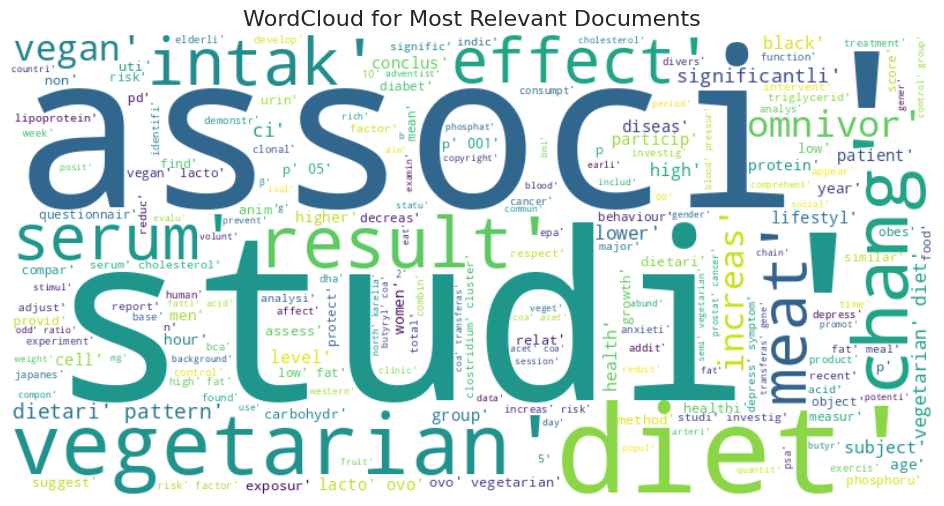

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(combined_text)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud for Most Relevant Documents', fontsize=16)
plt.axis('off')
plt.show()

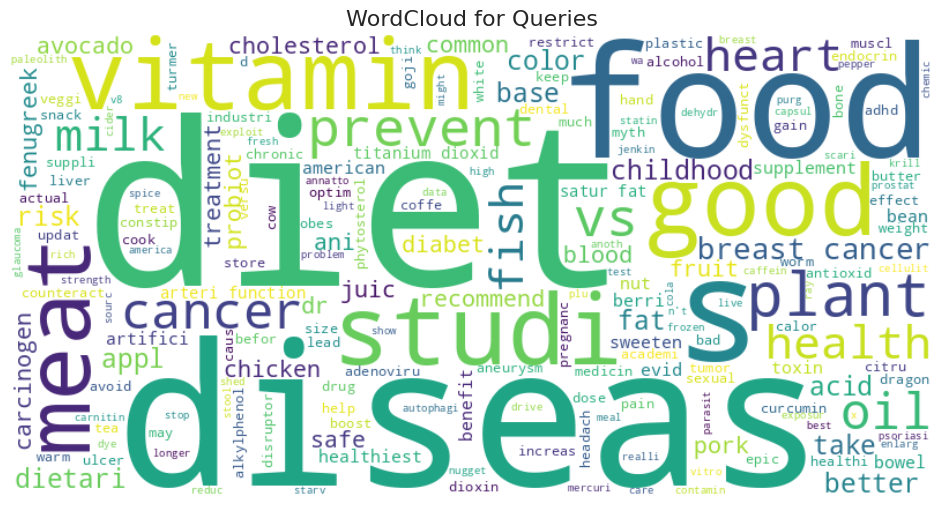

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(queries['processed_query'].apply(lambda x: ' '.join(x))))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud for Queries', fontsize=16)
plt.axis('off')
plt.show()

# PART II: Basic Retrieval Pipelines

PyTerrier’s documentation ([docs](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html)) includes default elements such as a tokenizer and a lemmatizer. For this reason, if in the first part of the project these steps were applied to analyze the dataset before indexing with PyTerrier, the dataset is later modified to follow the same preprocessing steps but excluding tokenization and lemmatization, as these are handled by PyTerrier's indexing process.  

Steps  

**1. Dataset Creation**  
A dataset (corpus) was created where the data was preprocessed but not lemmatized or tokenized.  

**2. Lemmatizer Evaluation**
Several lemmatizers provided by PyTerrier were tested, and an analysis was conducted to determine the most suitable one for the dataset and the task.  

**3. Retrieval Pipeline and Models**  
After selecting the most suitable lemmatizer, retrieval pipelines were constructed using two models: **BM25** and **TF-IDF**.  
- These models were first applied to an index containing the titles and abstracts of the documents.  
- Subsequently, the models were applied to an index containing only the titles.  

**4. Evaluation of Queries**
For each model and pipeline, the best and worst-performing queries were analyzed using various evaluation metrics.  


## Preprocessing



In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import spacy
from functools import lru_cache

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import logging
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F700-\U0001F77F"  # alchemical symbols
    u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    u"\U0001FA00-\U0001FA6F"  # Chess Symbols
    u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    u"\U00002702-\U000027B0"  # Dingbats
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+",
    flags=re.UNICODE,
)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    if any(char.isdigit() for char in word):
        return word
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def preprocess_text(text):
    try:
        # 1. Remove HTML tag and convert in lowercase
        text = BeautifulSoup(text, "html.parser").get_text().lower()
        # 2. Remove URL
        text = re.sub(r'http\S+|www\.\S+', '', text)
        # 3. Remove emoji
        text = emoji_pattern.sub(r'', text)
        doc = nlp(text)
        filtered_tokens = [
            normalize_repeated_chars(token.text)
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num is not token.is_space
        ]
        text = ' '.join(filtered_tokens)
        return text
    except Exception as e:
        logging.error(f"Error processing text: {text}\nError: {e}")
        return ""


data['processed_text'] = data['text'].apply(preprocess_text)

data['term_count_original'] = data['text'].apply(lambda x: len(word_tokenize(x)))
data['term_count_processed'] = data['processed_text'].apply(lambda x: len(word_tokenize(x)))
print(data[['doc_id', 'term_count_original', 'term_count_processed', 'processed_text']].head())

    doc_id  term_count_original  term_count_processed  \
0   MED-10                  285                   162   
1   MED-14                  284                   147   
2  MED-118                  210                   112   
3  MED-301                  199                   110   
4  MED-306                  312                   159   

                                      processed_text  
0  recent studies suggested statins established d...  
1  background preclinical studies shown statins p...  
2  aims study determine concentrations nonylpheno...  
3  epilepsy seizure disorder common neurological ...  
4  hit reaction time latencies hrt continuous per...  


In [ ]:
output_file = "processed_data_no_stemming.csv"
data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

Processed data saved to processed_data_no_stemming.csv


In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    if any(char.isdigit() for char in word):
        return word
    return re.sub(r'(.)\1{2,}', r'\1\1', word)


def preprocess_query(query):
    try:
        query = BeautifulSoup(query, "html.parser").get_text().lower()
        query = re.sub(r'http\S+|www\.\S+', '', query)
        query = emoji_pattern.sub(r'', query)
        query = ' '.join(normalize_repeated_chars(word) for word in query.split())
        return query
    except Exception as e:
        logging.error(f"Error processing query: {query}\nError: {e}")
        return []

queries['processed_query'] = queries['query_text'].apply(preprocess_query)

queries['processed_query'] = queries['processed_query'].str.strip()
queries['processed_query'] = queries['processed_query'].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
queries['term_count_original'] = queries['query_text'].apply(lambda x: len(word_tokenize(x)))
queries['term_count_processed'] = queries['processed_query'].apply(lambda x: len(word_tokenize(x)))

queries[['query_id', 'term_count_original', 'term_count_processed', 'processed_query']].head()

query_id  term_count_original  term_count_processed  \
0   PLAIN-2                    8                     7   
1  PLAIN-12                    5                     5   
2  PLAIN-23                    9                     9   
3  PLAIN-33                   10                     5   
4  PLAIN-44                    7                     6   

                                     processed_query  
0    do cholesterol statin drugs cause breast cancer  
1                exploiting autophagy to live longer  
2  how to reduce exposure to alkylphenols through...  
3             whats driving americas obesity problem  
4               who should be careful about curcumin

In [ ]:
output_file = "processed_query_no_stemming.csv"
queries.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

Processed data saved to processed_query_no_stemming.csv


## Lemmatizer Evaluation

In [ ]:
pip install python-terrier

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.4 MB/s eta 0:00:00
  Created wheel for chest: filename=chest-0.2.3-py3-none-any.whl size=7611 sha256=0abad9a56cee0a3387d4d1b9d2d1ce4650a16123

In [ ]:
from pyterrier.measures import *

In [ ]:
input_file = "/content/processed_data_no_stemming.csv"

data = pd.read_csv(input_file)

data.head()

text  \
0  Recent studies have suggested that statins, an...   
1  BACKGROUND: Preclinical studies have shown tha...   
2  The aims of this study were to determine the c...   
3  Epilepsy or seizure disorder is one of the mos...   
4  Hit Reaction Time latencies (HRT) in the Conti...   

                                               title   doc_id  \
0  Statin Use and Breast Cancer Survival: A Natio...   MED-10   
1  Statin use after diagnosis of breast cancer an...   MED-14   
2  Alkylphenols in human milk and their relations...  MED-118   
3  Methylmercury: A Potential Environmental Risk ...  MED-301   
4  Sensitivity of Continuous Performance Test (CP...  MED-306   

                                      processed_text  term_count_original  \
0  recent studies suggested statins established d...                  285   
1  background preclinical studies shown statins p...                  284   
2  aims study determine concentrations nonylpheno...                  210   
3  epilepsy seizure disorder common neurological ...                  199   
4  hit reaction time latencies hrt continuous per...                  312   

   term_count_processed  
0                   162  
1                   147  
2                   112  
3                   110  
4                   159

In [ ]:
data['text_diff'] = data.apply(
    lambda row: f"Original: {row['text']}\nProcessed: {row['processed_text']}", axis=1
)

diff_examples = data[data['text'] != data['processed_text']].head(5)

for index, row in diff_examples.iterrows():
    print(f"Doc ID: {row['doc_id']}")
    print(row['text_diff'])
    print('-' * 80)

Doc ID: MED-10
Original: Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08–9.0 years) 6,011 participants died, of which 3,619 (60.2%) was due to breast cancer. After adjustment f

In [ ]:
data = data.drop(columns=['term_count_original', 'term_count_processed', 'text', 'text_diff'])
data = data.rename(columns={'doc_id': 'docno', 'processed_text': 'text'})

In [ ]:
import pyterrier as pt

if not pt.started():
    pt.init()

terrier-assemblies 5.10 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
<ipython-input-8-723b7dd8a6cc>:4: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


Given that NFCorpus is a medical dataset with documents in English, we should focus on stemmers that can handle English effectively. Below are the justifications for selecting specific stemmers:

- porter: The most widely used English stemmer, suitable for reducing words to their linguistic roots. Commonly used in general text retrieval tasks.
- weakporter: A less aggressive version of the Porter stemmer, which may retain more medically significant terms compared to the standard Porter.
none: Testing with no stemming is essential for a baseline to observe the effect of stemming.
- danish/swedish/other non-English stemmers: These are not suitable as the corpus is in English.
- Other Snowball stemmers (like finnish, german): These are irrelevant unless the dataset contains multilingual content.

In [ ]:
meta = ['docno', 'title']

In [ ]:
stemmers = [
    pt.TerrierStemmer.none,
    pt.TerrierStemmer.porter,
    pt.TerrierStemmer.weakporter
]

tokeniser = pt.TerrierTokeniser('english')
stopwords = pt.TerrierStopwords('terrier')

In [ ]:
token_counts = {}
for stemmer in stemmers:
    print(f"Indexing with stemmer: {stemmer}")

    indexer = pt.IterDictIndexer(f'./index_{stemmer}', meta=meta, stemmer=stemmer, tokeniser=tokeniser, stopwords=stopwords, overwrite=True)
    index_ref = indexer.index(data.to_dict(orient='records'))

    with pt.IndexFactory.of(index_ref) as index:
        token_counts[stemmer] = index.getCollectionStatistics().getNumberOfTokens()
        print(f"Statistics of the index with {stemmer}: {index.getCollectionStatistics().toString()}")

Indexing with stemmer: TerrierStemmer.none
Statistics of the index with TerrierStemmer.none: Number of documents: 3633
Number of terms: 24109
Number of postings: 312553
Number of fields: 1
Number of tokens: 473003
Field names: [text]
Positions:   false

Indexing with stemmer: TerrierStemmer.porter
Statistics of the index with TerrierStemmer.porter: Number of documents: 3633
Number of terms: 17034
Number of postings: 292012
Number of fields: 1
Number of tokens: 473003
Field names: [text]
Positions:   false

Indexing with stemmer: TerrierStemmer.weakporter
Statistics of the index with TerrierStemmer.weakporter: Number of documents: 3633
Number of terms: 19889
Number of postings: 299937
Number of fields: 1
Number of tokens: 473003
Field names: [text]
Positions:   false



In [ ]:
print("\nToken Counts per Stemmer:")
for stemmer, count in token_counts.items():
    print(f"{stemmer}: {count}")


Token Counts per Stemmer:
TerrierStemmer.none: 473003
TerrierStemmer.porter: 473003
TerrierStemmer.weakporter: 473003


We selected the **Weak Porter stemmer**, which offers the following characteristics:  

- **Number of Terms**: 19,889 (a balanced size, falling between no stemming and the standard Porter stemmer).  
- **Number of Postings**: 299,937 (moderately reduced compared to no stemming).  

The Weak Porter stemmer performs less aggressive stemming compared to the standard Porter stemmer. This allows it to preserve more distinctions between different word forms while still significantly reducing the vocabulary size compared to using no stemmer at all.  

This approach provides a well-balanced trade-off between **precision** and **recall**, making it particularly suitable for retrieval tasks where maintaining some linguistic nuance is important without compromising too much on query-document alignment.

In [ ]:
indexer = pt.IterDictIndexer(f'./index_weakporter', meta=meta, stemmer=pt.TerrierStemmer.weakporter, overwrite=True)

In [ ]:
index_ref = indexer.index(data.to_dict(orient='records'))

In [ ]:
print(pt.IndexFactory.of(index_ref).getCollectionStatistics())

Number of documents: 3633
Number of terms: 19889
Number of postings: 299937
Number of fields: 1
Number of tokens: 473003
Field names: [text]
Positions:   false



In [ ]:
index = pt.IndexFactory.of(index_ref)

Let's try to examine the terms that appeared most frequently in the Most Relevant Documents, i.e., words that seem to be more present in documents that are most relevant to many queries.

In [ ]:
most_common_tokens = ['associ', 'studi', 'vegetarian', 'diet', 'intak', 'effect']

for token in most_common_tokens:
    try:
        lexicon_entry = index.getLexicon()[token]
        print(f"Token: '{token}' -> {lexicon_entry.toString()}")
        print()
    except KeyError:
        print(f"Token '{token}' not found in the index.\n")

Token: 'associ' -> term1816 Nt=1 TF=1 maxTF=1 @{0 44216 0} TFf=1

Token: 'studi' -> term66 Nt=1220 TF=2330 maxTF=20 @{0 421175 0} TFf=2330

Token: 'vegetarian' -> term622 Nt=157 TF=622 maxTF=15 @{0 461176 0} TFf=622

Token: 'diet' -> term454 Nt=1026 TF=2813 maxTF=15 @{0 134131 0} TFf=2813

Token: 'intak' -> term6660 Nt=1 TF=1 maxTF=1 @{0 236082 2} TFf=1

Token: 'effect' -> term72 Nt=1498 TF=2845 maxTF=23 @{0 149432 0} TFf=2845



## Retrival Pipelines

### Title and Abstract

In [ ]:
index = pt.IndexFactory.of(index_ref)

tfidf_pipe = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25_pipe = pt.BatchRetrieve(index, wmodel="BM25")

In [ ]:
queries = pd.read_csv('/content/processed_query_no_stemming.csv')
queries.head()

query_text  query_id  \
0   Do Cholesterol Statin Drugs Cause Breast Cancer?   PLAIN-2   
1                Exploiting Autophagy to Live Longer  PLAIN-12   
2  How to Reduce Exposure to Alkylphenols Through...  PLAIN-23   
3          What’s Driving America’s Obesity Problem?  PLAIN-33   
4              Who Should be Careful About Curcumin?  PLAIN-44   

                                     processed_query  term_count_original  \
0    do cholesterol statin drugs cause breast cancer                    8   
1                exploiting autophagy to live longer                    5   
2  how to reduce exposure to alkylphenols through...                    9   
3             whats driving americas obesity problem                   10   
4               who should be careful about curcumin                    7   

   term_count_processed  
0                     7  
1                     5  
2                     9  
3                     5  
4                     6

In [ ]:
queries = queries.drop(columns=['term_count_original', 'term_count_processed', 'query_text'])
queries = queries.rename(columns={'query_id': 'qid', 'processed_query': 'query'})
queries.head()

qid                                              query
0   PLAIN-2    do cholesterol statin drugs cause breast cancer
1  PLAIN-12                exploiting autophagy to live longer
2  PLAIN-23  how to reduce exposure to alkylphenols through...
3  PLAIN-33             whats driving americas obesity problem
4  PLAIN-44               who should be careful about curcumin

In [ ]:
csv_path = "/content/qrels.csv"
qrels = pd.read_csv(csv_path)

In [ ]:
qrels.head()

query_id    doc_id  relevance
0  PLAIN-2  MED-2427          2
1  PLAIN-2    MED-10          2
2  PLAIN-2  MED-2429          2
3  PLAIN-2  MED-2430          2
4  PLAIN-2  MED-2431          2

In [ ]:
qrels = qrels.rename(columns={
    "query_id": "qid",
    "doc_id": "docno",
    "relevance": "label"
})

qrels.head()

qid     docno  label
0  PLAIN-2  MED-2427      2
1  PLAIN-2    MED-10      2
2  PLAIN-2  MED-2429      2
3  PLAIN-2  MED-2430      2
4  PLAIN-2  MED-2431      2

In [ ]:
pipelines = [
    tfidf_pipe,  # TF-IDF
    bm25_pipe,   # BM25
]

In [ ]:
names = ["TF-IDF", "BM25"]
metrics = ['map', 'ndcg', 'P_10', 'recall_10']


results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)

name    map   ndcg   P_10  recall_10
0  TF-IDF  0.143  0.289  0.226      0.145
1    BM25  0.143  0.289  0.225      0.144

#### TF-DIF results

In [ ]:
res = tfidf_pipe.transform(queries[['qid','query']])
res.to_csv('tfidf_results.csv', index=False)
display(res.head(5))

qid  docid     docno  rank      score  \
0  PLAIN-2      1    MED-14     0  16.423786   
1  PLAIN-2      0    MED-10     1  15.874694   
2  PLAIN-2   1373  MED-2429     2  13.523598   
3  PLAIN-2    346  MED-1193     3  12.906498   
4  PLAIN-2   1375  MED-2431     4  12.756698   

                                             query  
0  do cholesterol statin drugs cause breast cancer  
1  do cholesterol statin drugs cause breast cancer  
2  do cholesterol statin drugs cause breast cancer  
3  do cholesterol statin drugs cause breast cancer  
4  do cholesterol statin drugs cause breast cancer

**Poor Queries Analysis**

We calculated the **Mean Score of Queries**, which represents the average relevance score of all documents retrieved for a given query.  

This metric evaluates the overall quality of the results for each query, taking into account all retrieved documents. Queries with low mean scores are likely to have generally less relevant results.  

By using this approach, we can identify queries where the retrieval system struggles to find relevant results, regardless of the ranking positions of those results. This allows us to assess query performance independently of ranking.

In [ ]:
mean_scores = res.groupby("query")["score"].mean().reset_index()
mean_scores.rename(columns={"score": "mean_score"}, inplace=True)

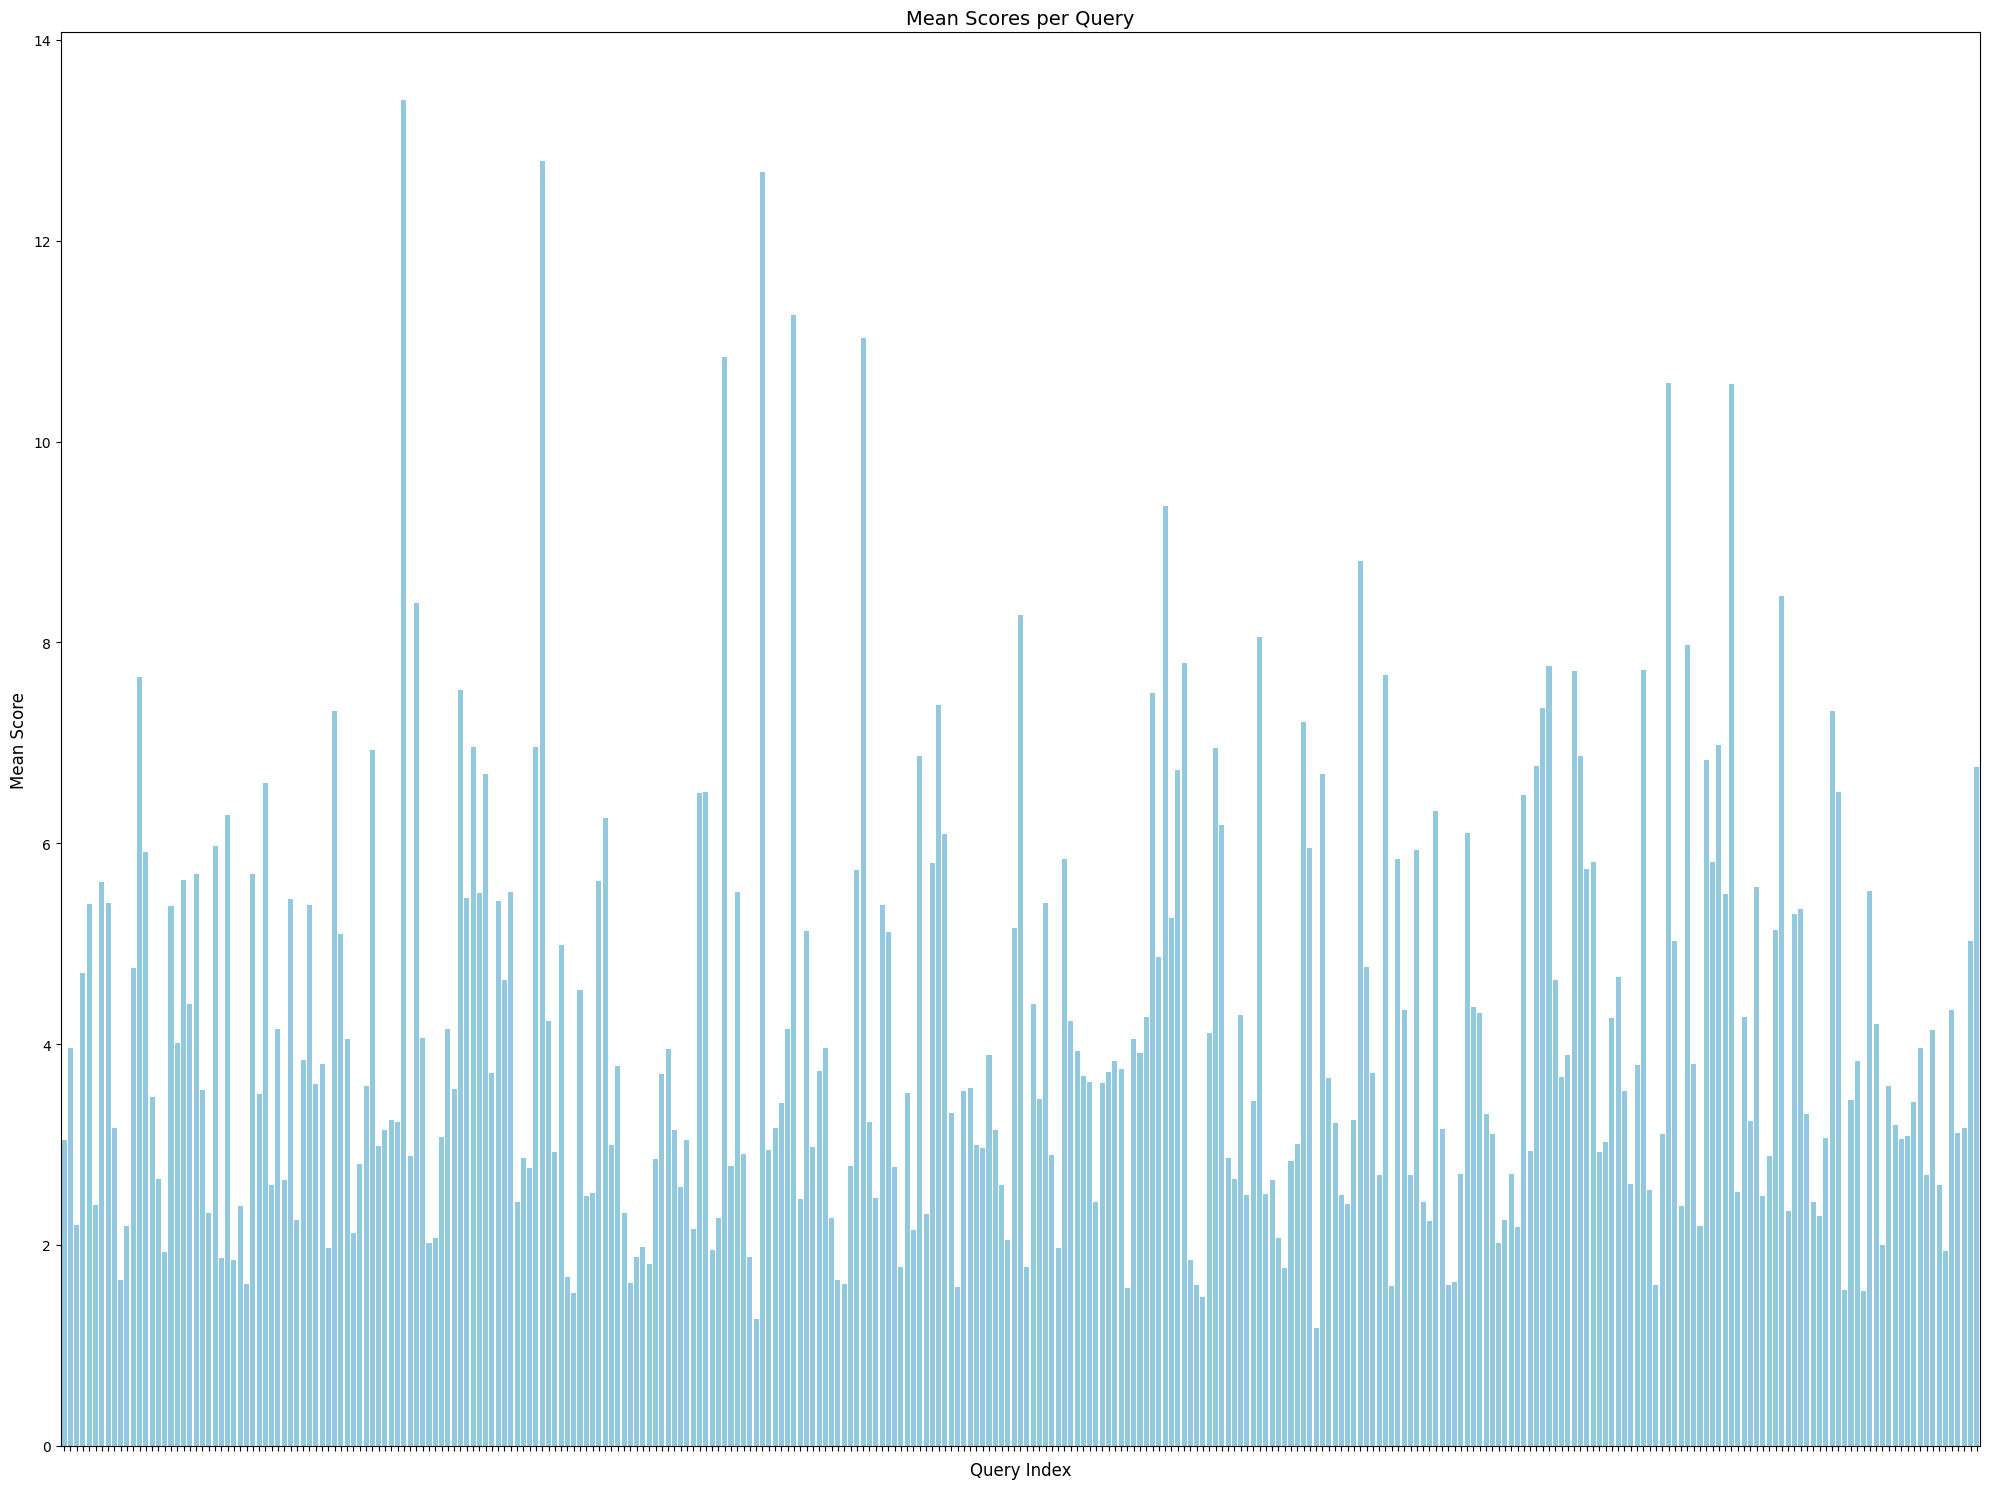

In [ ]:
plt.figure(figsize=(20, 15))
sns.barplot(x=range(len(mean_scores)), y=mean_scores["mean_score"], color="skyblue")
plt.title("Mean Scores per Query", fontsize=14)
plt.ylabel("Mean Score", fontsize=12)
plt.xlabel("Query Index", fontsize=12)
plt.xticks(range(len(mean_scores)), labels=[""] * len(mean_scores))
plt.tight_layout()
plt.show()

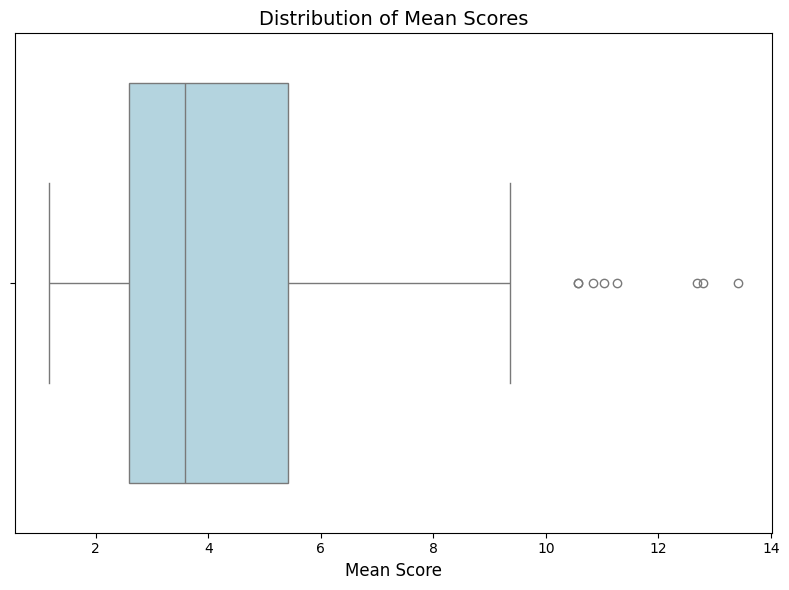

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=mean_scores["mean_score"], color="lightblue")
plt.title("Distribution of Mean Scores", fontsize=14)
plt.xlabel("Mean Score", fontsize=12)
plt.tight_layout()
plt.show()

Given the distribution we use 2 as the threshold

In [ ]:
poor_queries = mean_scores[mean_scores['mean_score'] < 2]
display(poor_queries)

query  mean_score
9                         aluminum in vaccines vs food    1.651702
16       any update on the scary in vitro avocado data    1.929891
25                             are organic foods safer    1.872276
27                     artificial food colors and adhd    1.853632
29                                         atkins diet    1.610822
42                                         blood clots    1.972242
80                             convergence of evidence    1.677006
81                                     cooking methods    1.523034
90                                  diet and cellulite    1.622645
91          dietary guidelines from dairies to berries    1.875557
92                                     dietary scoring    1.981258
93                        dietary theory of alzheimers    1.807259
103                                      dragons blood    1.947468
109                          epic findings on lymphoma    1.875236
110                                         epic study    1.265740
123                                 food dyes and adhd    1.651998
124                                 foods for glaucoma    1.605597
133                        harvard physicians study ii    1.784061
142        how can you believe in any scientific study    1.581049
153          increasing muscle strength with fenugreek    1.776318
158                      is annatto food coloring safe    1.972287
169                                          junk food    1.567366
179                                      liver disease    1.844791
180                                      lowcarb diets    1.597453
181                                       lyme disease    1.481255
194                                      muscle health    1.772375
199                                      nihaarp study    1.174887
211                                 parkinsons disease    1.595257
220                                    plantbased diet    1.597453
221                     plantbased diets for psoriasis    1.626594
253                                        soil health    1.600351
283                               ultraprocessed foods    1.551147
286                                     uterine health    1.539878
289                                  veggies vs cancer    1.998626
299  what do you think of dr jenkins take on paleol...    1.942875

- Some queries, such as "what do you think of dr jenkins take on paleolithic diets" or "any update on the scary in vitro avocado data," are highly specific, contain uncommon or less frequent terms, or have unclear intent. These types of queries may confuse the retrieval system or lead to less relevant results because they might not match well with indexed documents.

- Queries like "junk food" or "dietary guidelines from dairies to berries" are relatively general and can lead to a wide variety of results, making it harder for the system to identify highly relevant documents. The system may retrieve many results that are not closely related to the user's query.

- Some queries focus on very specific topics or obscure terms, such as "dragons blood" or "nihaarp study."

- Some of the queries are more conversational or less formal, such as "how can you believe in any scientific study." These kinds of queries not match well with formal or academic document structures in the index.

Let’s compare queries that perform poorly in terms of **MAP (Mean Average Precision)**.  

MAP calculates the **average precision** for a single query and then computes the mean across all queries. It considers both the **relevance** and the **ranking position** of all relevant documents for each query.  

Queries with low MAP values indicate that relevant documents are either poorly distributed across the ranking or entirely missing from the top positions.  

This metric is particularly useful for analyzing queries with overall poor performance, as it provides a comprehensive view of how well the system retrieves and ranks relevant documents.

In [ ]:
eval_poor_query = pt.Evaluate(res, qrels, metrics=['map'],perquery=True)
display(eval_poor_query)

defaultdict(dict,
            {'PLAIN-2': {'map': 0.4244327414815414},
             'PLAIN-12': {'map': 0.006980687011646764},
             'PLAIN-23': {'map': 0.09564541776246419},
             'PLAIN-33': {'map': 0.0566345740430975},
             'PLAIN-44': {'map': 0.04314616137952912},
             'PLAIN-56': {'map': 0.1003035560970437},
             'PLAIN-68': {'map': 0.0555502933057281},
             'PLAIN-78': {'map': 0.02465132541244737},
             'PLAIN-91': {'map': 0.10757145615054535},
             'PLAIN-102': {'map': 0.013533158781073548},
             'PLAIN-112': {'map': 0.040542496127570875},
             'PLAIN-123': {'map': 0.01218551347479631},
             'PLAIN-133': {'map': 0.007487273210808195},
             'PLAIN-143': {'map': 0.012368024132730015},
             'PLAIN-153': {'map': 0.31532424649465046},
             'PLAIN-165': {'map': 0.16955779681135677},
             'PLAIN-175': {'map': 0.09866148767871244},
             'PLAIN-186': {'map': 0.014

In [ ]:
eval_poor_query_df = pd.DataFrame.from_dict(eval_poor_query, orient='index').reset_index()
eval_poor_query_df.columns = ['qid', 'map']
display(eval_poor_query_df)

qid       map
0       PLAIN-2  0.424433
1      PLAIN-12  0.006981
2      PLAIN-23  0.095645
3      PLAIN-33  0.056635
4      PLAIN-44  0.043146
..          ...       ...
318  PLAIN-2408  0.000000
319   PLAIN-499  0.000000
320   PLAIN-551  0.000000
321   PLAIN-583  0.000000
322   PLAIN-997  0.000000

[323 rows x 2 columns]

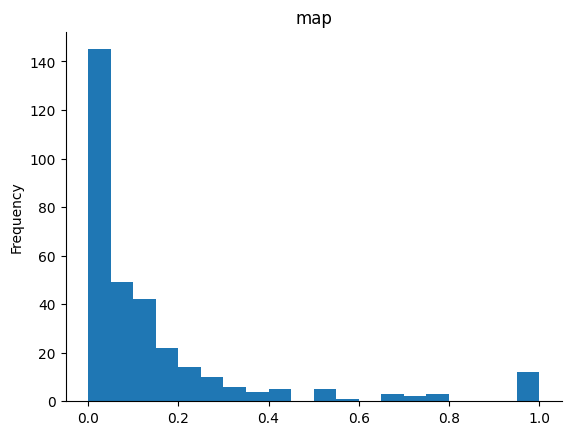

In [ ]:
eval_poor_query_df['map'].plot(kind='hist', bins=20, title='map')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
joined_df = pd.merge(eval_poor_query_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['map'] < 0.001]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid       map                                              query
0   PLAIN-2  0.424433    do cholesterol statin drugs cause breast cancer
1  PLAIN-12  0.006981                exploiting autophagy to live longer
2  PLAIN-23  0.095645  how to reduce exposure to alkylphenols through...
3  PLAIN-33  0.056635             whats driving americas obesity problem
4  PLAIN-44  0.043146               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (map < 0.001):")
filtered_df


Filtered DataFrame (map < 0.001):


qid  map                                              query
32    PLAIN-358  0.0  didnt another study show carnitine was good fo...
35    PLAIN-395  0.0        what about pepper plus turmeric in v8 juice
42    PLAIN-478  0.0                                          accidents
44    PLAIN-510  0.0                                   airport scanners
45    PLAIN-520  0.0                                               alli
..          ...  ...                                                ...
318  PLAIN-2408  0.0                                             zoloft
319   PLAIN-499  0.0                                    africanamerican
320   PLAIN-551  0.0                                            amnesia
321   PLAIN-583  0.0                                      antinutrients
322   PLAIN-997  0.0                                     czechoslovakia

[66 rows x 3 columns]

The low MAP values for these queries can be attributed to several factors:  
1. **Ambiguity**: Many queries (e.g., "accidents," "arkansas," "amnesia") are vague or overly broad, lacking specific context or intent, making it difficult for the retrieval model to match relevant documents.  
2. **Out-of-scope topics**: Some queries (e.g., "bagels," "chanterelle mushrooms") may not align well with the medical focus of the NFCorpus, leading to limited relevant results.  
3. **Rare or niche topics**: Queries like "tongue worm," "quinine," or "soil health" may target highly specific information that is either sparsely represented or absent in the corpus.  
4. **Compound or non-standard phrasing**: Queries such as "more than an apple a day combating common diseases" or "the answer to the pritikin puzzle" are verbose or metaphorical, making them harder to parse effectively.  
These factors collectively reduce the likelihood of retrieving documents that align with the relevance judgments.


**Best Queries Analysis**

P@10 measures the fraction of relevant documents among the top 10 retrieved results. It is a precision metric, focusing on retrieval performance for high-ranking results.

Reflects user satisfaction in practical settings, as users typically review only the top few results. Critical in applications where top-k precision is more valuable than overall retrieval performance.



In [ ]:
eval_topsis = pt.Evaluate(res, qrels, metrics=[P@10],perquery=True)
display(eval_topsis)

defaultdict(dict,
            {'PLAIN-2': {'P@10': 0.6},
             'PLAIN-12': {'P@10': 0.1},
             'PLAIN-23': {'P@10': 0.5},
             'PLAIN-33': {'P@10': 0.2},
             'PLAIN-44': {'P@10': 0.1},
             'PLAIN-56': {'P@10': 0.5},
             'PLAIN-68': {'P@10': 0.2},
             'PLAIN-78': {'P@10': 0.1},
             'PLAIN-91': {'P@10': 0.7},
             'PLAIN-102': {'P@10': 0.1},
             'PLAIN-112': {'P@10': 0.2},
             'PLAIN-123': {'P@10': 0.1},
             'PLAIN-133': {'P@10': 0.0},
             'PLAIN-143': {'P@10': 0.1},
             'PLAIN-153': {'P@10': 0.9},
             'PLAIN-165': {'P@10': 0.6},
             'PLAIN-175': {'P@10': 0.3},
             'PLAIN-186': {'P@10': 0.1},
             'PLAIN-196': {'P@10': 0.5},
             'PLAIN-207': {'P@10': 0.6},
             'PLAIN-217': {'P@10': 0.1},
             'PLAIN-227': {'P@10': 0.1},
             'PLAIN-238': {'P@10': 0.0},
             'PLAIN-248': {'P@10': 0.2},
        

In [ ]:
eval_topsis_df = pd.DataFrame.from_dict(eval_topsis, orient='index').reset_index()
eval_topsis_df.columns = ['qid', 'P@10']
display(eval_topsis_df)

qid  P@10
0       PLAIN-2   0.6
1      PLAIN-12   0.1
2      PLAIN-23   0.5
3      PLAIN-33   0.2
4      PLAIN-44   0.1
..          ...   ...
318  PLAIN-2408   0.0
319   PLAIN-499   0.0
320   PLAIN-551   0.0
321   PLAIN-583   0.0
322   PLAIN-997   0.0

[323 rows x 2 columns]

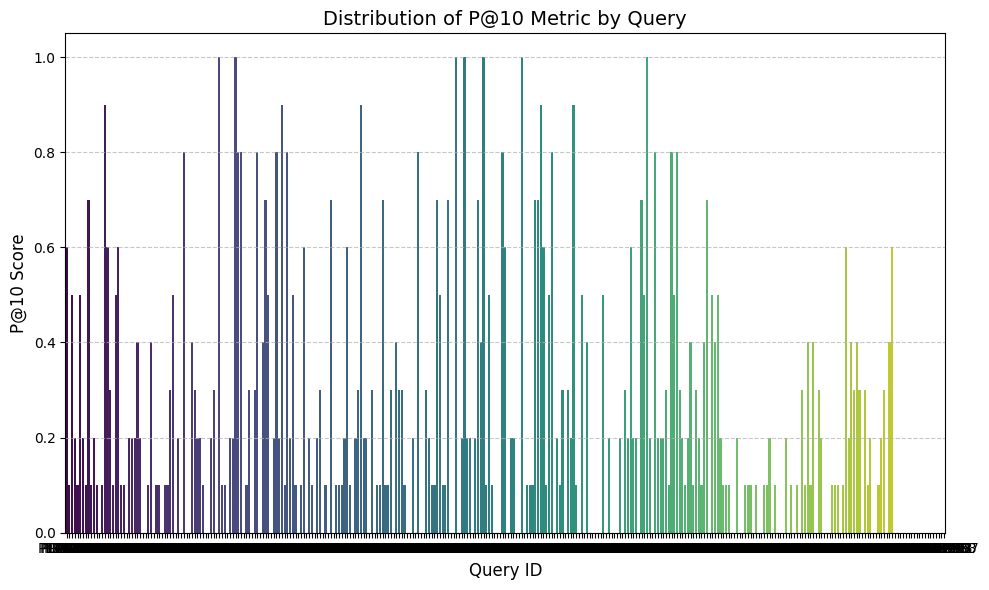

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=eval_topsis_df, x="qid", y="P@10", palette="viridis")
plt.title("Distribution of P@10 Metric by Query", fontsize=14)
plt.xlabel("Query ID", fontsize=12)
plt.ylabel("P@10 Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
joined_df = pd.merge(eval_topsis_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['P@10'] > 0.6]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid  P@10                                              query
0   PLAIN-2   0.6    do cholesterol statin drugs cause breast cancer
1  PLAIN-12   0.1                exploiting autophagy to live longer
2  PLAIN-23   0.5  how to reduce exposure to alkylphenols through...
3  PLAIN-33   0.2             whats driving americas obesity problem
4  PLAIN-44   0.1               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (P@10 > 0.6):")
filtered_df


Filtered DataFrame (P@10 > 0.6):


qid  P@10                                              query
8      PLAIN-91   0.7               chronic headaches and pork parasites
14    PLAIN-153   0.9                       how should i take probiotics
43    PLAIN-488   0.8                                      adenovirus 36
56    PLAIN-660   1.0                                              beans
62    PLAIN-721   1.0                                               bmaa
63    PLAIN-731   0.8                                     bone fractures
64    PLAIN-741   0.8                                                bph
70    PLAIN-806   0.8                                caloric restriction
73    PLAIN-838   0.7                                        carrageenan
77    PLAIN-892   0.8                                          chickpeas
79    PLAIN-913   0.9                                           cinnamon
81    PLAIN-934   0.8                                             coffee
97   PLAIN-1151   0.7                          factory farming practices
108  PLAIN-1288   0.9                                             grapes
116  PLAIN-1387   0.7                                      hyperactivity
129  PLAIN-1527   0.8                                      liver disease
136  PLAIN-1601   0.7                                             memory
140  PLAIN-1667   0.7                                      muscle health
143  PLAIN-1710   1.0                                 neurocysticercosis
146  PLAIN-1741   1.0                                               nuts
151  PLAIN-1805   0.7                                 parkinsons disease
153  PLAIN-1837   1.0                                         pesticides
160  PLAIN-1909   0.8                                               pork
167  PLAIN-1983   1.0                                          rapamycin
172  PLAIN-2040   0.7                                             salmon
173  PLAIN-2051   0.7                                      saturated fat
174  PLAIN-2061   0.9                                            seafood
178  PLAIN-2102   0.8                                            smoking
186  PLAIN-2197   0.9                                         sweeteners
211  PLAIN-2510   0.7                         coffee and artery function
213  PLAIN-2530   1.0  infectobesity adenovirus 36 and childhood obesity
216  PLAIN-2560   0.8               childhood constipation and cows milk
222  PLAIN-2620   0.8               phytates for the treatment of cancer
224  PLAIN-2640   0.8  chicken salmonella thanks to meat industry law...
235  PLAIN-2750   0.7         preventing the common cold with probiotics

Considering only the queries with a P@10 metric greater than 0.60, a Word2Vec model is initialized to generate sentence embeddings. Cosine similarities between these embeddings are computed, highly similar query pairs are identified, and a random subset of these pairs is displayed along with their query IDs and texts.

This was done to provide a computationally measurable metric for comparing different queries.

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model = Word2Vec(sentences=filtered_df['query'], vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentence, model):
    valid_words = [word for word in sentence if word in model.wv]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
filtered_df['embedding'] = filtered_df['query'].apply(lambda x: get_sentence_embedding(x, model))

In [ ]:
embeddings = np.vstack(filtered_df['embedding'].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

# Display similarity matrix
print("Cosine Similarity Matrix:")
similarity_matrix


Cosine Similarity Matrix:


array([[0.99999976, 0.9072309 , 0.85849386, ..., 0.90482783, 0.9169565 ,
        0.89162713],
       [0.9072309 , 1.0000002 , 0.8092203 , ..., 0.8408331 , 0.923636  ,
        0.9556241 ],
       [0.85849386, 0.8092203 , 1.0000002 , ..., 0.7387821 , 0.84728545,
        0.7783909 ],
       ...,
       [0.90482783, 0.8408331 , 0.7387821 , ..., 1.0000004 , 0.8880671 ,
        0.89620596],
       [0.9169565 , 0.923636  , 0.84728545, ..., 0.8880671 , 1.        ,
        0.90786314],
       [0.89162713, 0.9556241 , 0.7783909 , ..., 0.89620596, 0.90786314,
        0.9999998 ]], dtype=float32)

In [ ]:
most_similar_pairs = np.argwhere(similarity_matrix > 0.8)
most_similar_pairs = most_similar_pairs[most_similar_pairs[:, 0] != most_similar_pairs[:, 1]]

print("\nMost Similar Query Pairs (qid):")
for pair in most_similar_pairs:
    print(f"Query {filtered_df['qid'].iloc[pair[0]]} and Query {filtered_df['qid'].iloc[pair[1]]}")


Most Similar Query Pairs (qid):
Query PLAIN-91 and Query PLAIN-153
Query PLAIN-91 and Query PLAIN-488
Query PLAIN-91 and Query PLAIN-731
Query PLAIN-91 and Query PLAIN-806
Query PLAIN-91 and Query PLAIN-838
Query PLAIN-91 and Query PLAIN-892
Query PLAIN-91 and Query PLAIN-1151
Query PLAIN-91 and Query PLAIN-1288
Query PLAIN-91 and Query PLAIN-1527
Query PLAIN-91 and Query PLAIN-1667
Query PLAIN-91 and Query PLAIN-1710
Query PLAIN-91 and Query PLAIN-1805
Query PLAIN-91 and Query PLAIN-1837
Query PLAIN-91 and Query PLAIN-2051
Query PLAIN-91 and Query PLAIN-2510
Query PLAIN-91 and Query PLAIN-2530
Query PLAIN-91 and Query PLAIN-2560
Query PLAIN-91 and Query PLAIN-2620
Query PLAIN-91 and Query PLAIN-2640
Query PLAIN-91 and Query PLAIN-2750
Query PLAIN-153 and Query PLAIN-91
Query PLAIN-153 and Query PLAIN-488
Query PLAIN-153 and Query PLAIN-806
Query PLAIN-153 and Query PLAIN-892
Query PLAIN-153 and Query PLAIN-1151
Query PLAIN-153 and Query PLAIN-1667
Query PLAIN-153 and Query PLAIN-1710

In [ ]:
import random

unique_pairs = {(min(pair[0], pair[1]), max(pair[0], pair[1])) for pair in most_similar_pairs}
unique_pairs = list(unique_pairs)


random_pairs = random.sample(unique_pairs, min(10, len(unique_pairs)))

for i, pair in enumerate(random_pairs):
    print(f"Query {filtered_df['qid'].iloc[pair[0]]}: {filtered_df['query'].iloc[pair[0]]}")
    print(f"Query {filtered_df['qid'].iloc[pair[1]]}: {filtered_df['query'].iloc[pair[1]]}")
    print()

Query PLAIN-2640: chicken salmonella thanks to meat industry lawsuit
Query PLAIN-2750: preventing the common cold with probiotics

Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity
Query PLAIN-2750: preventing the common cold with probiotics

Query PLAIN-731: bone fractures
Query PLAIN-1527: liver disease

Query PLAIN-91: chronic headaches and pork parasites
Query PLAIN-1710: neurocysticercosis

Query PLAIN-1151: factory farming practices
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-731: bone fractures
Query PLAIN-2051: saturated fat

Query PLAIN-806: caloric restriction
Query PLAIN-2750: preventing the common cold with probiotics

Query PLAIN-488: adenovirus 36
Query PLAIN-2640: chicken salmonella thanks to meat industry lawsuit

Query PLAIN-838: carrageenan
Query PLAIN-1288: grapes

Query PLAIN-731: bone fractures
Query PLAIN-2620: phytates for the treatment of cancer



These query pairs all exhibit cosine similarity > 0.80, reflecting strong semantic overlap. The similarity arises from shared themes:  

1. **Health and Disease Prevention**: Queries such as *'preventing the common cold with probiotics'* and *'caloric restriction'* focus on interventions to improve health or prevent illnesses.  
2. **Microorganisms and Health**: Queries like *'infectobesity adenovirus 36 and childhood obesity'* and *'preventing the common cold with probiotics'* share a focus on the role of microbes in health outcomes.  
3. **Nutrition and Dietary Factors**: Queries such as *'carrageenan'* and *'grapes'* explore the health implications of specific foods or nutrients.  
4. **Parasitic Infections and Neurological Conditions**: Queries like *'chronic headaches and pork parasites'* and *'neurocysticercosis'* are closely related through parasitic infections affecting the nervous system.  

#### BM25 results

In [ ]:
res = bm25_pipe.transform(queries[['qid','query']])
res.to_csv('bm25_results.csv', index=False)
display(res.head(5))

qid  docid     docno  rank      score  \
0  PLAIN-2      1    MED-14     0  27.790826   
1  PLAIN-2      0    MED-10     1  27.233937   
2  PLAIN-2   1373  MED-2429     2  23.114752   
3  PLAIN-2    346  MED-1193     3  22.220031   
4  PLAIN-2   1375  MED-2431     4  21.998659   

                                             query  
0  do cholesterol statin drugs cause breast cancer  
1  do cholesterol statin drugs cause breast cancer  
2  do cholesterol statin drugs cause breast cancer  
3  do cholesterol statin drugs cause breast cancer  
4  do cholesterol statin drugs cause breast cancer

In [ ]:
mean_scores = res.groupby("query")["score"].mean().reset_index()
mean_scores.rename(columns={"score": "mean_score"}, inplace=True)

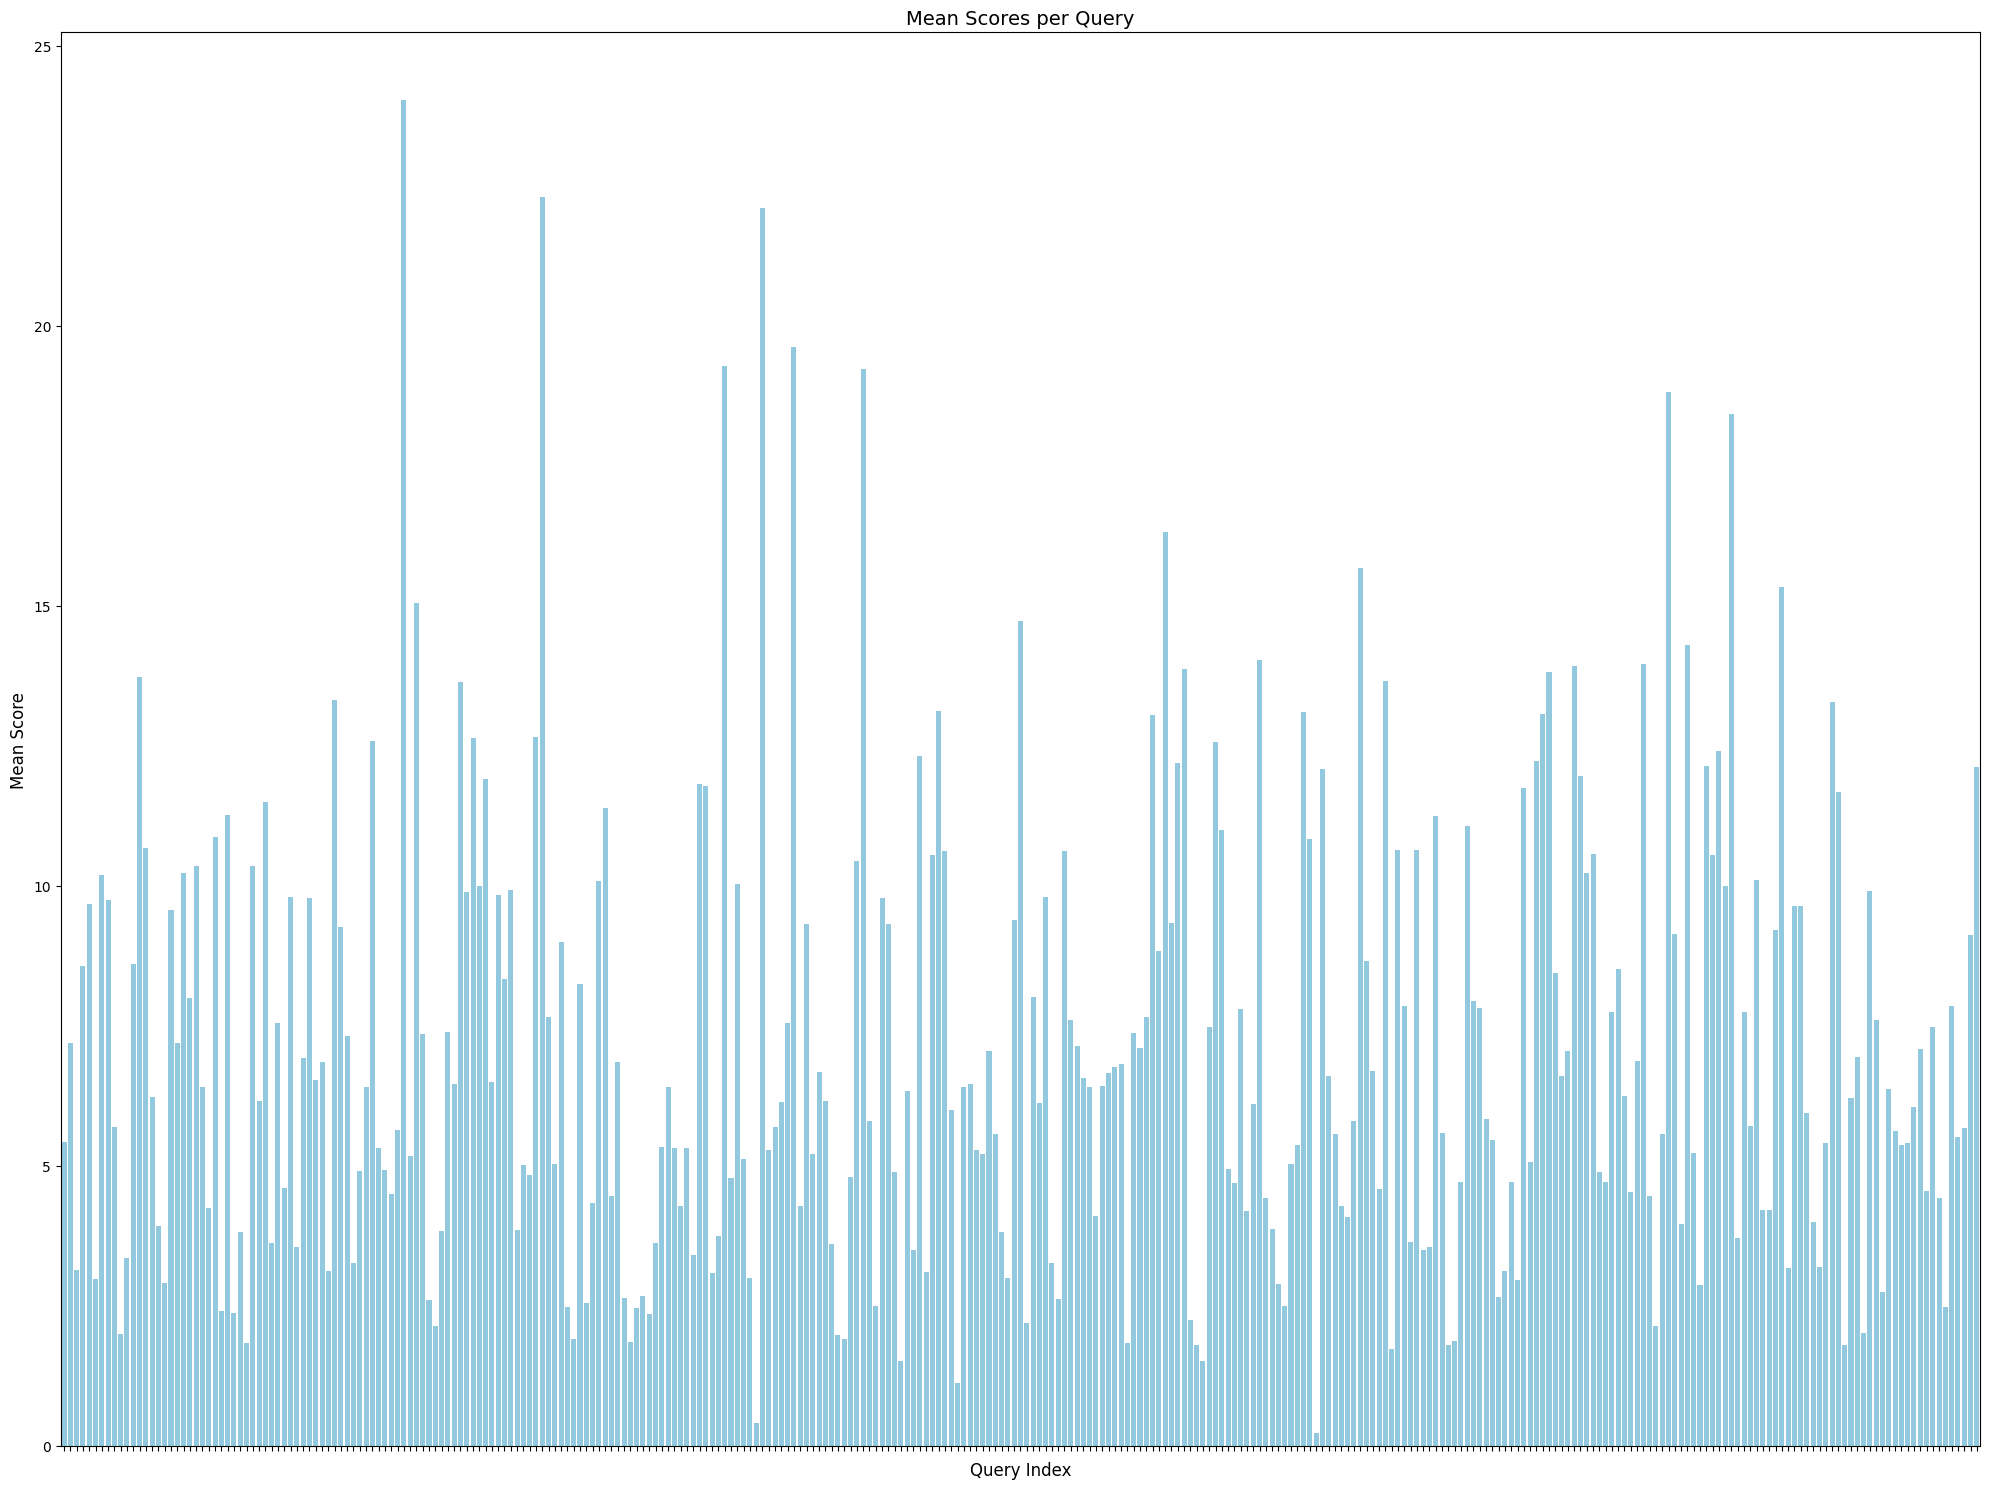

In [ ]:
plt.figure(figsize=(20, 15))
sns.barplot(x=range(len(mean_scores)), y=mean_scores["mean_score"], color="skyblue")
plt.title("Mean Scores per Query", fontsize=14)
plt.ylabel("Mean Score", fontsize=12)
plt.xlabel("Query Index", fontsize=12)
plt.xticks(range(len(mean_scores)), labels=[""] * len(mean_scores))
plt.tight_layout()
plt.show()

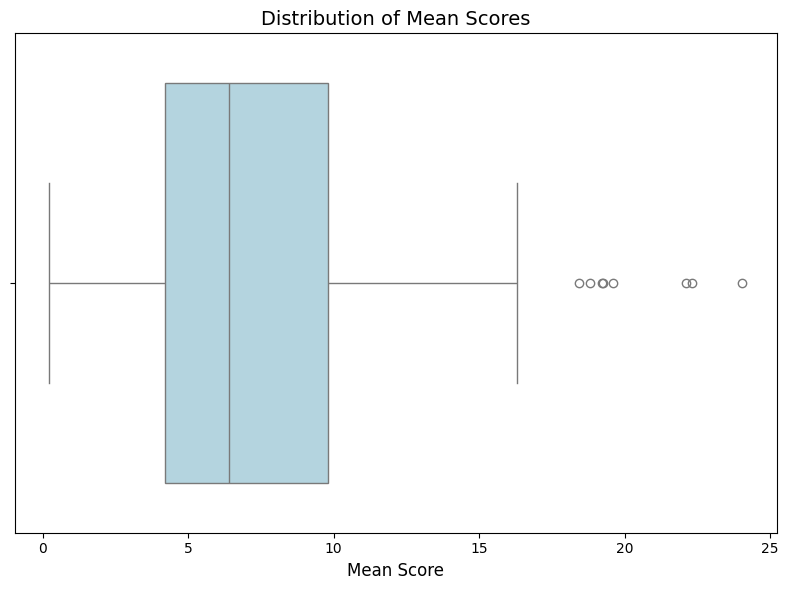

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=mean_scores["mean_score"], color="lightblue")
plt.title("Distribution of Mean Scores", fontsize=14)
plt.xlabel("Mean Score", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
poor_queries = mean_scores[mean_scores['mean_score'] < 4]
display(poor_queries)

query  mean_score
2                              acne  cancer connection    3.129259
5                            alcohol risks vs benefits    2.982612
9                         aluminum in vaccines vs food    1.988750
10                         american dental association    3.349417
15                    antioxidant content of 300 foods    3.918528
..                                                 ...         ...
279            treating an enlarged prostate with diet    3.183010
283                               ultraprocessed foods    1.798367
286                                     uterine health    2.008857
289                                  veggies vs cancer    2.748043
299  what do you think of dr jenkins take on paleol...    2.483551

[72 rows x 2 columns]

In [ ]:
display(len(poor_queries))

72

In [ ]:
eval_poor_query = pt.Evaluate(res, qrels, metrics=['map'],perquery=True)
display(eval_poor_query)

defaultdict(dict,
            {'PLAIN-2': {'map': 0.42981952330468803},
             'PLAIN-12': {'map': 0.007009916094584286},
             'PLAIN-23': {'map': 0.10761986166475167},
             'PLAIN-33': {'map': 0.05508102776074868},
             'PLAIN-44': {'map': 0.04314616137952912},
             'PLAIN-56': {'map': 0.1003035560970437},
             'PLAIN-68': {'map': 0.055089211903470214},
             'PLAIN-78': {'map': 0.02475186449539791},
             'PLAIN-91': {'map': 0.10691091848906158},
             'PLAIN-102': {'map': 0.013443523993925942},
             'PLAIN-112': {'map': 0.040542496127570875},
             'PLAIN-123': {'map': 0.012200435729847494},
             'PLAIN-133': {'map': 0.007578891649562618},
             'PLAIN-143': {'map': 0.012368024132730015},
             'PLAIN-153': {'map': 0.31532424649465046},
             'PLAIN-165': {'map': 0.1707213266977794},
             'PLAIN-175': {'map': 0.09866148767871244},
             'PLAIN-186': {'map': 0

In [ ]:
eval_poor_query_df = pd.DataFrame.from_dict(eval_poor_query, orient='index').reset_index()
eval_poor_query_df.columns = ['qid', 'map']
display(eval_poor_query_df)

qid       map
0       PLAIN-2  0.429820
1      PLAIN-12  0.007010
2      PLAIN-23  0.107620
3      PLAIN-33  0.055081
4      PLAIN-44  0.043146
..          ...       ...
318  PLAIN-2408  0.000000
319   PLAIN-499  0.000000
320   PLAIN-551  0.000000
321   PLAIN-583  0.000000
322   PLAIN-997  0.000000

[323 rows x 2 columns]

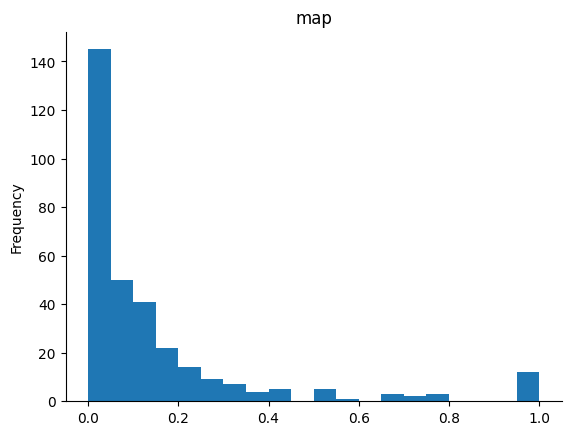

In [ ]:
eval_poor_query_df['map'].plot(kind='hist', bins=20, title='map')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
joined_df = pd.merge(eval_poor_query_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['map'] < 0.001]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid       map                                              query
0   PLAIN-2  0.429820    do cholesterol statin drugs cause breast cancer
1  PLAIN-12  0.007010                exploiting autophagy to live longer
2  PLAIN-23  0.107620  how to reduce exposure to alkylphenols through...
3  PLAIN-33  0.055081             whats driving americas obesity problem
4  PLAIN-44  0.043146               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (map < 0.001):")
filtered_df


Filtered DataFrame (map < 0.001):


qid  map                                              query
32    PLAIN-358  0.0  didnt another study show carnitine was good fo...
35    PLAIN-395  0.0        what about pepper plus turmeric in v8 juice
42    PLAIN-478  0.0                                          accidents
44    PLAIN-510  0.0                                   airport scanners
45    PLAIN-520  0.0                                               alli
..          ...  ...                                                ...
318  PLAIN-2408  0.0                                             zoloft
319   PLAIN-499  0.0                                    africanamerican
320   PLAIN-551  0.0                                            amnesia
321   PLAIN-583  0.0                                      antinutrients
322   PLAIN-997  0.0                                     czechoslovakia

[67 rows x 3 columns]

Queries with a very low MAP metric are actually very similar to those identified by the TF-IDF model. Therefore, the same reasoning expressed for the previous point can also be applied in this context

In [ ]:
eval_topsis = pt.Evaluate(res, qrels, metrics=[P@10],perquery=True)
display(eval_topsis)

defaultdict(dict,
            {'PLAIN-2': {'P@10': 0.6},
             'PLAIN-12': {'P@10': 0.1},
             'PLAIN-23': {'P@10': 0.6},
             'PLAIN-33': {'P@10': 0.2},
             'PLAIN-44': {'P@10': 0.1},
             'PLAIN-56': {'P@10': 0.5},
             'PLAIN-68': {'P@10': 0.2},
             'PLAIN-78': {'P@10': 0.1},
             'PLAIN-91': {'P@10': 0.6},
             'PLAIN-102': {'P@10': 0.1},
             'PLAIN-112': {'P@10': 0.2},
             'PLAIN-123': {'P@10': 0.1},
             'PLAIN-133': {'P@10': 0.0},
             'PLAIN-143': {'P@10': 0.1},
             'PLAIN-153': {'P@10': 0.9},
             'PLAIN-165': {'P@10': 0.6},
             'PLAIN-175': {'P@10': 0.3},
             'PLAIN-186': {'P@10': 0.1},
             'PLAIN-196': {'P@10': 0.5},
             'PLAIN-207': {'P@10': 0.6},
             'PLAIN-217': {'P@10': 0.1},
             'PLAIN-227': {'P@10': 0.1},
             'PLAIN-238': {'P@10': 0.0},
             'PLAIN-248': {'P@10': 0.2},
        

In [ ]:
eval_topsis_df = pd.DataFrame.from_dict(eval_topsis, orient='index').reset_index()
eval_topsis_df.columns = ['qid', 'P@10']
display(eval_topsis_df)

qid  P@10
0       PLAIN-2   0.6
1      PLAIN-12   0.1
2      PLAIN-23   0.6
3      PLAIN-33   0.2
4      PLAIN-44   0.1
..          ...   ...
318  PLAIN-2408   0.0
319   PLAIN-499   0.0
320   PLAIN-551   0.0
321   PLAIN-583   0.0
322   PLAIN-997   0.0

[323 rows x 2 columns]

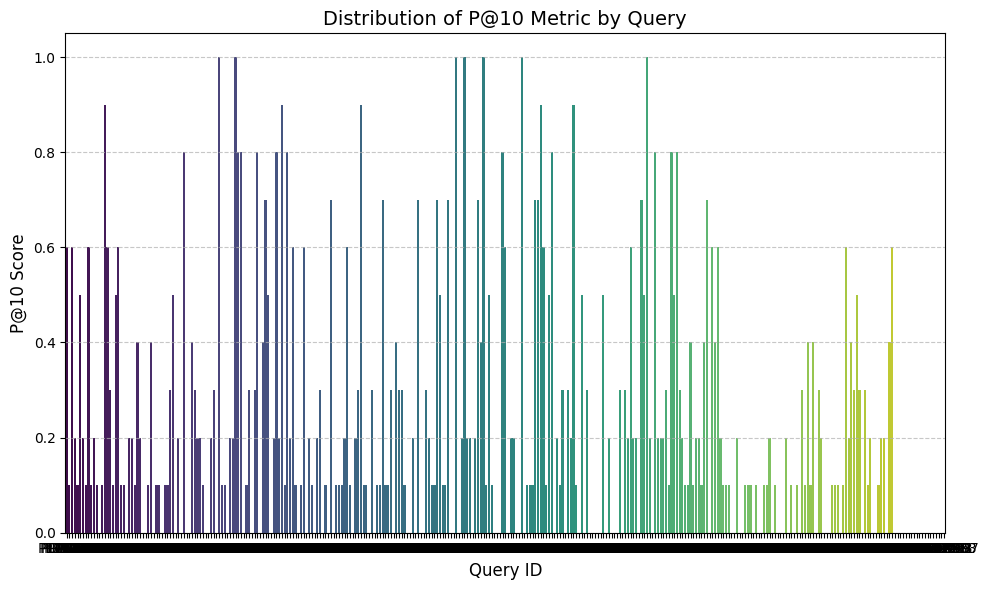

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=eval_topsis_df, x="qid", y="P@10", palette="viridis")
plt.title("Distribution of P@10 Metric by Query", fontsize=14)
plt.xlabel("Query ID", fontsize=12)
plt.ylabel("P@10 Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
joined_df = pd.merge(eval_topsis_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['P@10'] > 0.6]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid  P@10                                              query
0   PLAIN-2   0.6    do cholesterol statin drugs cause breast cancer
1  PLAIN-12   0.1                exploiting autophagy to live longer
2  PLAIN-23   0.6  how to reduce exposure to alkylphenols through...
3  PLAIN-33   0.2             whats driving americas obesity problem
4  PLAIN-44   0.1               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (P@10 > 0.6):")
filtered_df


Filtered DataFrame (P@10 > 0.6):


qid  P@10                                              query
14    PLAIN-153   0.9                       how should i take probiotics
43    PLAIN-488   0.8                                      adenovirus 36
56    PLAIN-660   1.0                                              beans
62    PLAIN-721   1.0                                               bmaa
63    PLAIN-731   0.8                                     bone fractures
64    PLAIN-741   0.8                                                bph
70    PLAIN-806   0.8                                caloric restriction
73    PLAIN-838   0.7                                        carrageenan
77    PLAIN-892   0.8                                          chickpeas
79    PLAIN-913   0.9                                           cinnamon
81    PLAIN-934   0.8                                             coffee
97   PLAIN-1151   0.7                          factory farming practices
108  PLAIN-1288   0.9                                             grapes
116  PLAIN-1387   0.7                                      hyperactivity
129  PLAIN-1527   0.7                                      liver disease
136  PLAIN-1601   0.7                                             memory
140  PLAIN-1667   0.7                                      muscle health
143  PLAIN-1710   1.0                                 neurocysticercosis
146  PLAIN-1741   1.0                                               nuts
151  PLAIN-1805   0.7                                 parkinsons disease
153  PLAIN-1837   1.0                                         pesticides
160  PLAIN-1909   0.8                                               pork
167  PLAIN-1983   1.0                                          rapamycin
172  PLAIN-2040   0.7                                             salmon
173  PLAIN-2051   0.7                                      saturated fat
174  PLAIN-2061   0.9                                            seafood
178  PLAIN-2102   0.8                                            smoking
186  PLAIN-2197   0.9                                         sweeteners
211  PLAIN-2510   0.7                         coffee and artery function
213  PLAIN-2530   1.0  infectobesity adenovirus 36 and childhood obesity
216  PLAIN-2560   0.8               childhood constipation and cows milk
222  PLAIN-2620   0.8               phytates for the treatment of cancer
224  PLAIN-2640   0.8  chicken salmonella thanks to meat industry law...
235  PLAIN-2750   0.7         preventing the common cold with probiotics

The queries with P@10 > 0.8 in the NFCorpus dataset likely achieved high precision because they are specific and align well with the dataset's medical focus. These queries often contain precise medical terms (e.g., "neurocysticercosis," "adenovirus 36") or well-defined topics ("probiotics," "rapamycin") that are effectively matched to relevant full-text medical documents in the corpus, reducing ambiguity and ensuring high relevance among the top 10 retrieved results.

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model = Word2Vec(sentences=filtered_df['query'], vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentence, model):
    valid_words = [word for word in sentence if word in model.wv]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
filtered_df['embedding'] = filtered_df['query'].apply(lambda x: get_sentence_embedding(x, model))

In [ ]:
embeddings = np.vstack(filtered_df['embedding'].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

# Display similarity matrix
print("Cosine Similarity Matrix:")
similarity_matrix


Cosine Similarity Matrix:


array([[1.        , 0.7948387 , 0.58154225, ..., 0.8628215 , 0.9165547 ,
        0.9496387 ],
       [0.7948387 , 1.0000001 , 0.69294095, ..., 0.79136217, 0.8269939 ,
        0.790229  ],
       [0.58154225, 0.69294095, 0.99999994, ..., 0.67613256, 0.7203834 ,
        0.59065986],
       ...,
       [0.8628215 , 0.79136217, 0.67613256, ..., 0.99999994, 0.89833504,
        0.89997303],
       [0.9165547 , 0.8269939 , 0.7203834 , ..., 0.89833504, 0.99999976,
        0.88915366],
       [0.9496387 , 0.790229  , 0.59065986, ..., 0.89997303, 0.88915366,
        0.9999998 ]], dtype=float32)

In [ ]:
most_similar_pairs = np.argwhere(similarity_matrix > 0.8)
most_similar_pairs = most_similar_pairs[most_similar_pairs[:, 0] != most_similar_pairs[:, 1]]

print("\nMost Similar Query Pairs (qid):")
for pair in most_similar_pairs:
    print(f"Query {filtered_df['qid'].iloc[pair[0]]} and Query {filtered_df['qid'].iloc[pair[1]]}")


Most Similar Query Pairs (qid):
Query PLAIN-153 and Query PLAIN-806
Query PLAIN-153 and Query PLAIN-1151
Query PLAIN-153 and Query PLAIN-1710
Query PLAIN-153 and Query PLAIN-1805
Query PLAIN-153 and Query PLAIN-2530
Query PLAIN-153 and Query PLAIN-2560
Query PLAIN-153 and Query PLAIN-2620
Query PLAIN-153 and Query PLAIN-2640
Query PLAIN-153 and Query PLAIN-2750
Query PLAIN-488 and Query PLAIN-1527
Query PLAIN-488 and Query PLAIN-1805
Query PLAIN-488 and Query PLAIN-2510
Query PLAIN-488 and Query PLAIN-2530
Query PLAIN-488 and Query PLAIN-2640
Query PLAIN-731 and Query PLAIN-806
Query PLAIN-731 and Query PLAIN-838
Query PLAIN-731 and Query PLAIN-1151
Query PLAIN-731 and Query PLAIN-1710
Query PLAIN-731 and Query PLAIN-2051
Query PLAIN-731 and Query PLAIN-2197
Query PLAIN-731 and Query PLAIN-2510
Query PLAIN-731 and Query PLAIN-2530
Query PLAIN-731 and Query PLAIN-2620
Query PLAIN-806 and Query PLAIN-153
Query PLAIN-806 and Query PLAIN-731
Query PLAIN-806 and Query PLAIN-1151
Query PLAI

In [ ]:
import random

unique_pairs = {(min(pair[0], pair[1]), max(pair[0], pair[1])) for pair in most_similar_pairs}
unique_pairs = list(unique_pairs)


random_pairs = random.sample(unique_pairs, min(10, len(unique_pairs)))

for i, pair in enumerate(random_pairs):
    print(f"Query {filtered_df['qid'].iloc[pair[0]]}: {filtered_df['query'].iloc[pair[0]]}")
    print(f"Query {filtered_df['qid'].iloc[pair[1]]}: {filtered_df['query'].iloc[pair[1]]}")
    print()

Query PLAIN-2510: coffee and artery function
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-731: bone fractures
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-806: caloric restriction
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity
Query PLAIN-2620: phytates for the treatment of cancer

Query PLAIN-1805: parkinsons disease
Query PLAIN-2560: childhood constipation and cows milk

Query PLAIN-2560: childhood constipation and cows milk
Query PLAIN-2640: chicken salmonella thanks to meat industry lawsuit

Query PLAIN-731: bone fractures
Query PLAIN-2620: phytates for the treatment of cancer

Query PLAIN-806: caloric restriction
Query PLAIN-1710: neurocysticercosis

Query PLAIN-1527: liver disease
Query PLAIN-2640: chicken salmonella thanks to meat industry lawsuit

Query PLAIN-488: adenovirus 36
Query PLAIN-2510: coffee and artery funct

Queries like "coffee and artery function" and "adenovirus 36" may include overlapping health-related contexts or terminology within the corpus.
Pairs such as "bone fractures" and "phytates for the treatment of cancer" might share references to biological or nutritional aspects.
Queries like "childhood constipation and cow's milk" and "chicken salmonella thanks to meat industry lawsuit" involve dietary or food safety themes.
"Caloric restriction" and "neurocysticercosis" might share underlying health or biological research contexts.

### Only Title

In [ ]:
meta = ['docno']

In [ ]:
data_copy = data.copy()

In [ ]:
data_title = data_copy.drop(columns=['text'])
data_title = data_title.rename(columns={'title': 'text'})

In [ ]:
data_title.head()

text    docno
0  Statin Use and Breast Cancer Survival: A Natio...   MED-10
1  Statin use after diagnosis of breast cancer an...   MED-14
2  Alkylphenols in human milk and their relations...  MED-118
3  Methylmercury: A Potential Environmental Risk ...  MED-301
4  Sensitivity of Continuous Performance Test (CP...  MED-306

In [ ]:
indexer = pt.IterDictIndexer(f'./index_wakporter_2', meta=meta, stemmer=pt.TerrierStemmer.weakporter, overwrite=True)

In [ ]:
index_ref = indexer.index(data_title.to_dict(orient='records'))

In [ ]:
print(pt.IndexFactory.of(index_ref).getCollectionStatistics())

Number of documents: 3633
Number of terms: 5670
Number of postings: 33137
Number of fields: 1
Number of tokens: 33787
Field names: [text]
Positions:   false



In [ ]:
index = pt.IndexFactory.of(index_ref)

tfidf_pipe = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25_pipe = pt.BatchRetrieve(index, wmodel="BM25")

In [ ]:
queries = pd.read_csv('/content/processed_query_no_stemming.csv')

In [ ]:
queries = queries.drop(columns=['term_count_original', 'term_count_processed', 'query_text'])
queries = queries.rename(columns={'query_id': 'qid', 'processed_query': 'query'})
queries.head()

qid                                              query
0   PLAIN-2    do cholesterol statin drugs cause breast cancer
1  PLAIN-12                exploiting autophagy to live longer
2  PLAIN-23  how to reduce exposure to alkylphenols through...
3  PLAIN-33             whats driving americas obesity problem
4  PLAIN-44               who should be careful about curcumin

In [ ]:
csv_path = "/content/qrels.csv"
qrels = pd.read_csv(csv_path)

In [ ]:
qrels.head()

query_id    doc_id  relevance
0  PLAIN-2  MED-2427          2
1  PLAIN-2    MED-10          2
2  PLAIN-2  MED-2429          2
3  PLAIN-2  MED-2430          2
4  PLAIN-2  MED-2431          2

In [ ]:
qrels = qrels.rename(columns={
    "query_id": "qid",
    "doc_id": "docno",
    "relevance": "label"
})

qrels.head()

qid     docno  label
0  PLAIN-2  MED-2427      2
1  PLAIN-2    MED-10      2
2  PLAIN-2  MED-2429      2
3  PLAIN-2  MED-2430      2
4  PLAIN-2  MED-2431      2

In [ ]:
pipelines = [
    tfidf_pipe,  # TF-IDF
    bm25_pipe,   # BM25
]

In [ ]:
names = ["TF-IDF", "BM25"]
metrics = ['map', 'ndcg', 'P_10', 'recall_10']


results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)

name    map   ndcg   P_10  recall_10
0  TF-IDF  0.096  0.198  0.164      0.106
1    BM25  0.096  0.197  0.164      0.106

The results of the second experiment, where only the document titles were considered (excluding abstracts), show minimal differences between TF-IDF and BM25 across all evaluation metrics (`map`, `ndcg`, `P_10`, and `recall_10`). Both retrieval models achieved the same `map` (0.096) and `P_10` (0.164), while `ndcg` and `recall_10` differ only slightly, with BM25 performing marginally worse on `ndcg` (0.197 vs. 0.198).

This suggests that, when limited to document titles, both models struggle to capture the necessary context or relevance effectively. The exclusion of abstracts likely reduced the richness of available information, making it harder for either method to differentiate in performance. BM25's advantage in ranking full-text content may not be as impactful when working with shorter texts like titles.

#### TF-DIF results

In [ ]:
res = tfidf_pipe.transform(queries[['qid','query']])
res.to_csv('tfidf2_results.csv', index=False)
display(res.head(5))

qid  docid     docno  rank     score  \
0  PLAIN-2      0    MED-10     0  9.526919   
1  PLAIN-2   1373  MED-2429     1  9.526919   
2  PLAIN-2      1    MED-14     2  9.102243   
3  PLAIN-2   1375  MED-2431     3  7.724856   
4  PLAIN-2   2728  MED-4391     4  6.393656   

                                             query  
0  do cholesterol statin drugs cause breast cancer  
1  do cholesterol statin drugs cause breast cancer  
2  do cholesterol statin drugs cause breast cancer  
3  do cholesterol statin drugs cause breast cancer  
4  do cholesterol statin drugs cause breast cancer

In [ ]:
mean_scores = res.groupby("query")["score"].mean().reset_index()
mean_scores.rename(columns={"score": "mean_score"}, inplace=True)

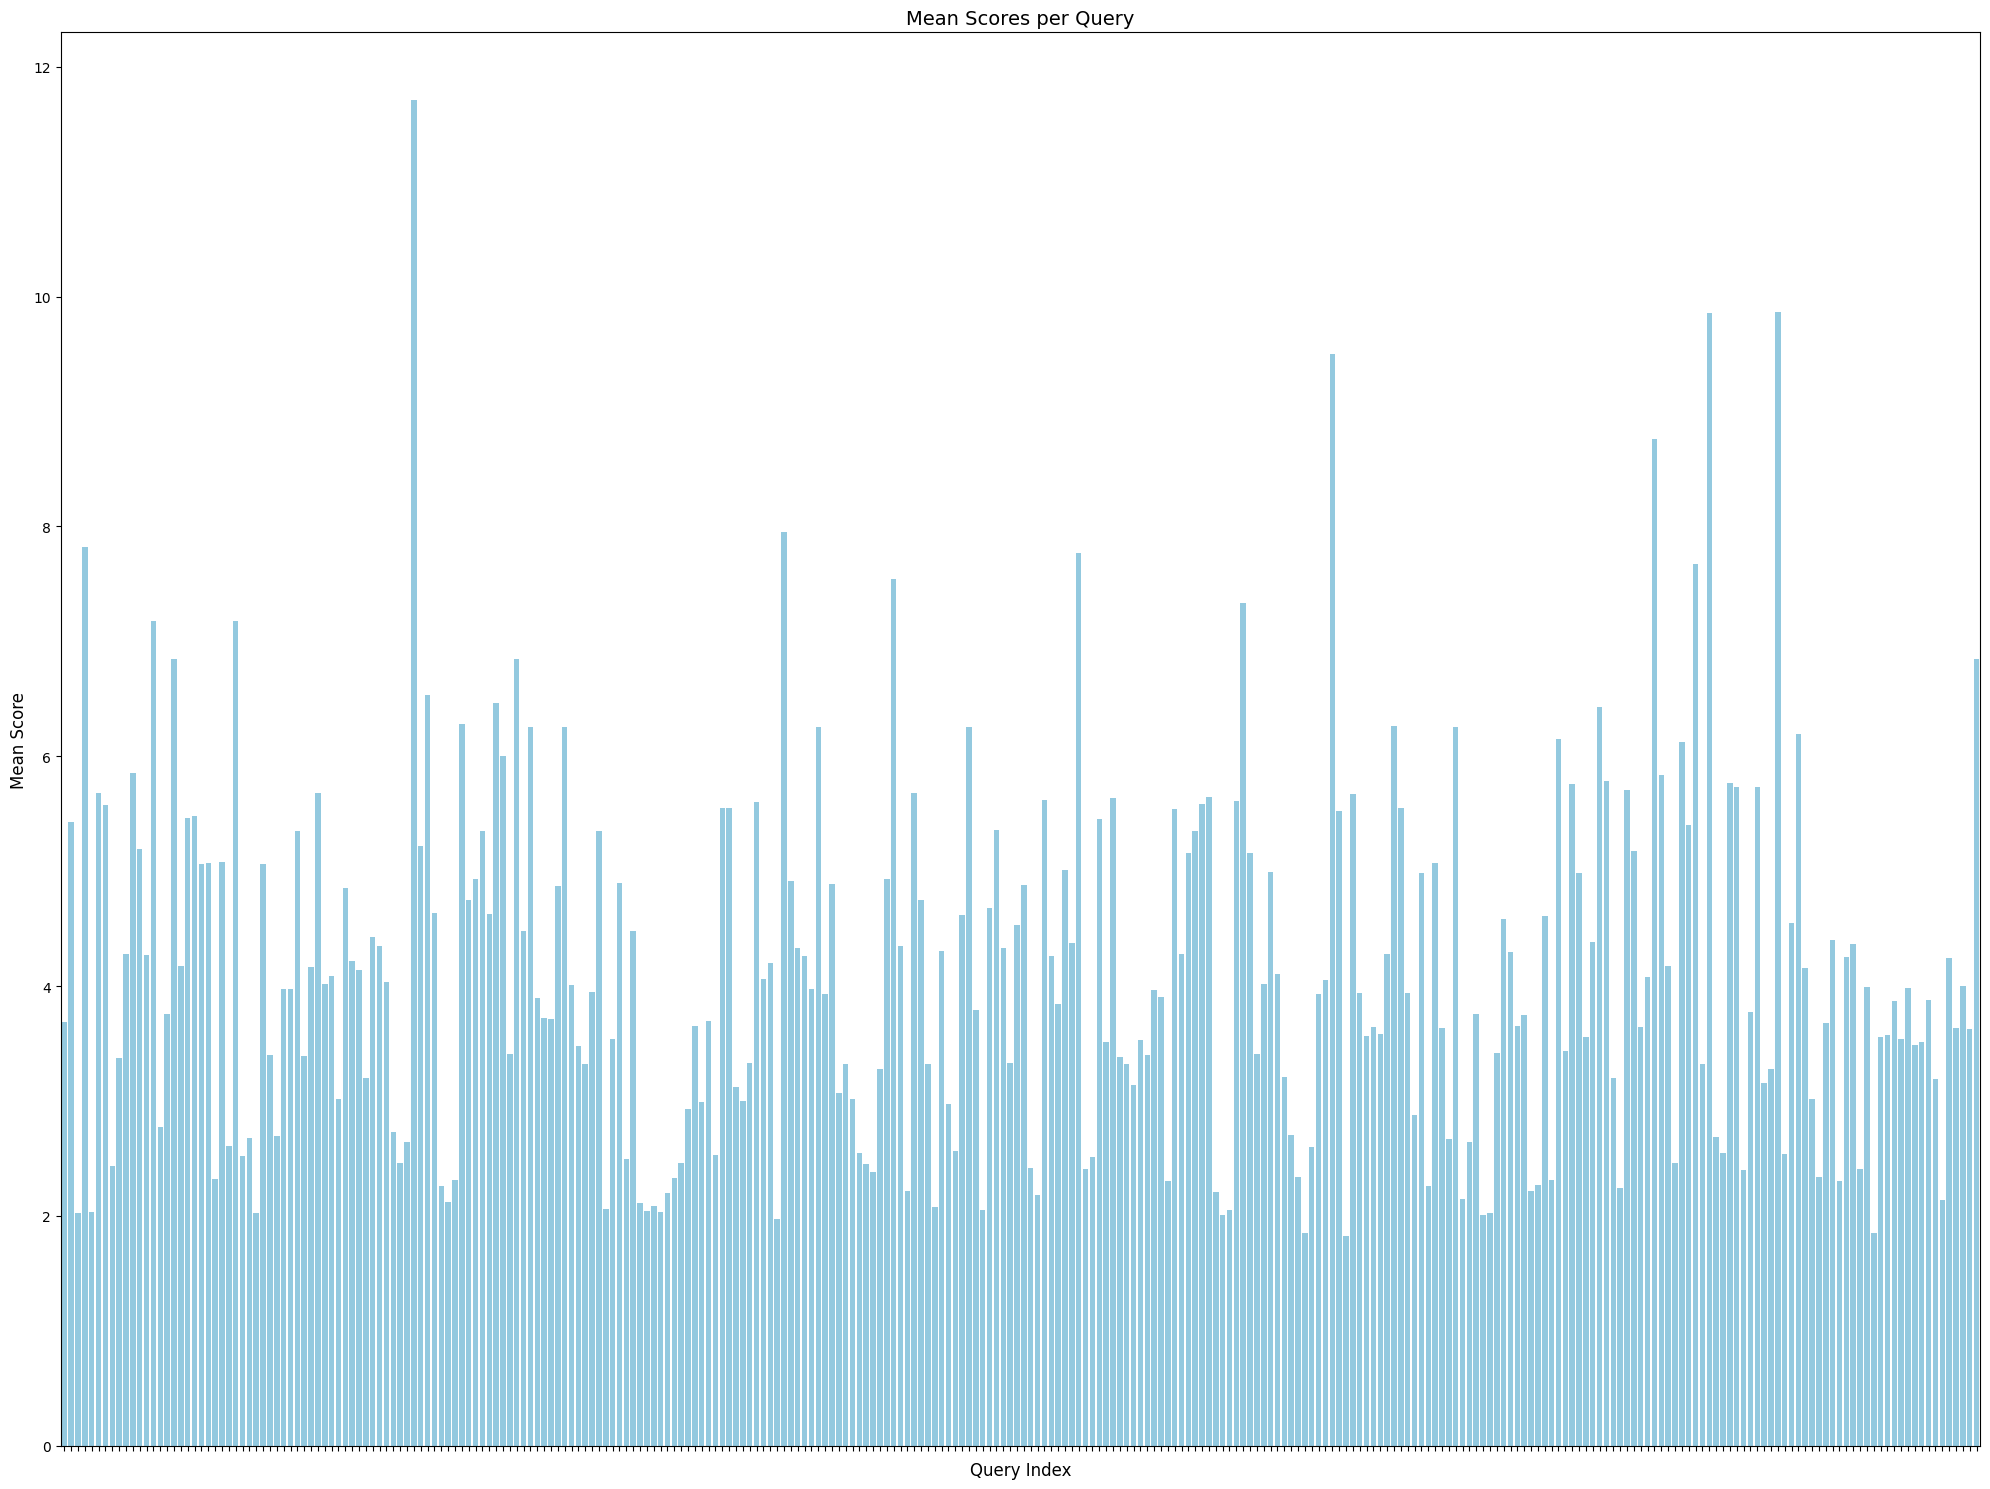

In [ ]:
plt.figure(figsize=(20, 15))
sns.barplot(x=range(len(mean_scores)), y=mean_scores["mean_score"], color="skyblue")
plt.title("Mean Scores per Query", fontsize=14)
plt.ylabel("Mean Score", fontsize=12)
plt.xlabel("Query Index", fontsize=12)
plt.xticks(range(len(mean_scores)), labels=[""] * len(mean_scores))
plt.tight_layout()
plt.show()

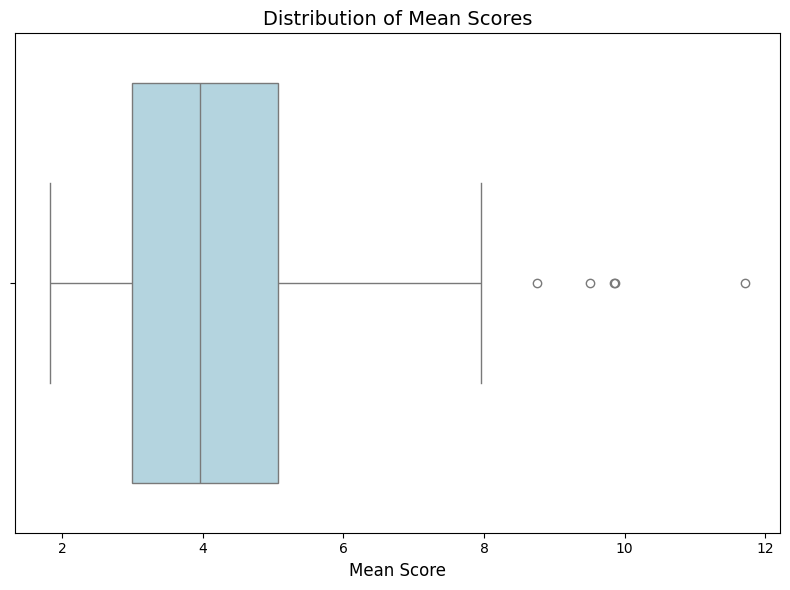

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=mean_scores["mean_score"], color="lightblue")
plt.title("Distribution of Mean Scores", fontsize=14)
plt.xlabel("Mean Score", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
poor_queries = mean_scores[mean_scores['mean_score'] < 3]
display(poor_queries)

query  mean_score
2                              acne  cancer connection    2.024346
4                            alcohol risks vs benefits    2.030303
7                         aluminum in vaccines vs food    2.436882
14                    antioxidant content of 300 foods    2.777699
22   are krill oil supplements better than fish oil...    2.321986
..                                                 ...         ...
256            treating an enlarged prostate with diet    2.340849
259                               ultraprocessed foods    2.308012
262                                     uterine health    2.408940
264                                  veggies vs cancer    1.851991
274  what do you think of dr jenkins take on paleol...    2.135249

[72 rows x 2 columns]

In [ ]:
eval_poor_query = pt.Evaluate(res, qrels, metrics=['map'],perquery=True)
display(eval_poor_query)

defaultdict(dict,
            {'PLAIN-2': {'map': 0.30044628781614446},
             'PLAIN-12': {'map': 0.0},
             'PLAIN-23': {'map': 0.06508625882693848},
             'PLAIN-33': {'map': 0.022225102531773983},
             'PLAIN-44': {'map': 0.027941458820595212},
             'PLAIN-56': {'map': 0.09099860763018658},
             'PLAIN-68': {'map': 0.043194631455501016},
             'PLAIN-78': {'map': 0.007777150622813326},
             'PLAIN-91': {'map': 0.04397941468253968},
             'PLAIN-102': {'map': 0.0022246662792250347},
             'PLAIN-112': {'map': 0.026541341639008485},
             'PLAIN-123': {'map': 0.0196078431372549},
             'PLAIN-133': {'map': 0.008976882441794724},
             'PLAIN-143': {'map': 0.01633986928104575},
             'PLAIN-153': {'map': 0.20161743817958824},
             'PLAIN-165': {'map': 0.11963108616166333},
             'PLAIN-175': {'map': 0.09524940370020381},
             'PLAIN-186': {'map': 0.0039924506387

In [ ]:
eval_poor_query_df = pd.DataFrame.from_dict(eval_poor_query, orient='index').reset_index()
eval_poor_query_df.columns = ['qid', 'map']
display(eval_poor_query_df)

qid       map
0      PLAIN-2  0.300446
1     PLAIN-12  0.000000
2     PLAIN-23  0.065086
3     PLAIN-33  0.022225
4     PLAIN-44  0.027941
..         ...       ...
318  PLAIN-645  0.000000
319  PLAIN-741  0.000000
320  PLAIN-946  0.000000
321  PLAIN-987  0.000000
322  PLAIN-997  0.000000

[323 rows x 2 columns]

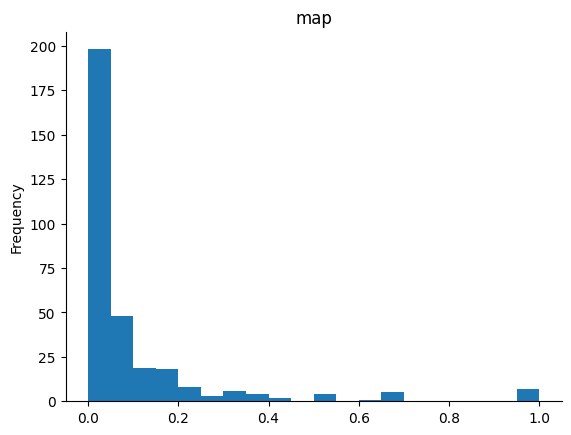

In [ ]:
eval_poor_query_df['map'].plot(kind='hist', bins=20, title='map')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
joined_df = pd.merge(eval_poor_query_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['map'] < 0.001]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid       map                                              query
0   PLAIN-2  0.300446    do cholesterol statin drugs cause breast cancer
1  PLAIN-12  0.000000                exploiting autophagy to live longer
2  PLAIN-23  0.065086  how to reduce exposure to alkylphenols through...
3  PLAIN-33  0.022225             whats driving americas obesity problem
4  PLAIN-44  0.027941               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (map < 0.001):")
filtered_df


Filtered DataFrame (map < 0.001):


qid  map                                              query
1     PLAIN-12  0.0                exploiting autophagy to live longer
22   PLAIN-238  0.0                 how chemically contaminated are we
32   PLAIN-358  0.0  didnt another study show carnitine was good fo...
35   PLAIN-395  0.0        what about pepper plus turmeric in v8 juice
42   PLAIN-478  0.0                                          accidents
..         ...  ...                                                ...
318  PLAIN-645  0.0                                             bagels
319  PLAIN-741  0.0                                                bph
320  PLAIN-946  0.0                                               coma
321  PLAIN-987  0.0                                              cumin
322  PLAIN-997  0.0                                     czechoslovakia

[97 rows x 3 columns]

These queries likely have a MAP < 0.001 due to several factors. First, many of the queries are either too vague (e.g., "accidents," "bagels") or too specific and niche (e.g., "human neurotransmitters in plants," "how chemically contaminated are we"). Vague queries lack enough contextual detail to guide the retrieval system, while niche or highly specific topics may not have sufficient relevant documents in the dataset.

Second, the exclusive use of document titles, rather than including abstracts, significantly limits the amount of textual information available for matching. Titles are often concise and may not contain enough keywords or context to align closely with the queries. This results in lower retrieval performance and poor alignment with the query intent, reflected in the low MAP scores.

In fact, the number of queries with low performance in the corpus containing only titles is 97, compared to around 65 when using the expanded corpus (titles and abstracts). This highlights how the reduced textual content in the title-only corpus negatively impacts the system's ability to match queries effectively, resulting in a higher number of low-performing queries.

In [ ]:
eval_topsis = pt.Evaluate(res, qrels, metrics=[P@10],perquery=True)
display(eval_topsis)

defaultdict(dict,
            {'PLAIN-2': {'P@10': 0.4},
             'PLAIN-12': {'P@10': 0.0},
             'PLAIN-23': {'P@10': 0.5},
             'PLAIN-33': {'P@10': 0.0},
             'PLAIN-44': {'P@10': 0.0},
             'PLAIN-56': {'P@10': 0.5},
             'PLAIN-68': {'P@10': 0.2},
             'PLAIN-78': {'P@10': 0.1},
             'PLAIN-91': {'P@10': 0.4},
             'PLAIN-102': {'P@10': 0.0},
             'PLAIN-112': {'P@10': 0.3},
             'PLAIN-123': {'P@10': 0.1},
             'PLAIN-133': {'P@10': 0.1},
             'PLAIN-143': {'P@10': 0.2},
             'PLAIN-153': {'P@10': 0.7},
             'PLAIN-165': {'P@10': 0.4},
             'PLAIN-175': {'P@10': 0.3},
             'PLAIN-186': {'P@10': 0.0},
             'PLAIN-196': {'P@10': 0.1},
             'PLAIN-207': {'P@10': 0.5},
             'PLAIN-217': {'P@10': 0.1},
             'PLAIN-227': {'P@10': 0.1},
             'PLAIN-238': {'P@10': 0.0},
             'PLAIN-248': {'P@10': 0.0},
        

In [ ]:
eval_topsis_df = pd.DataFrame.from_dict(eval_topsis, orient='index').reset_index()
eval_topsis_df.columns = ['qid', 'P@10']
display(eval_topsis_df)

qid  P@10
0      PLAIN-2   0.4
1     PLAIN-12   0.0
2     PLAIN-23   0.5
3     PLAIN-33   0.0
4     PLAIN-44   0.0
..         ...   ...
318  PLAIN-645   0.0
319  PLAIN-741   0.0
320  PLAIN-946   0.0
321  PLAIN-987   0.0
322  PLAIN-997   0.0

[323 rows x 2 columns]

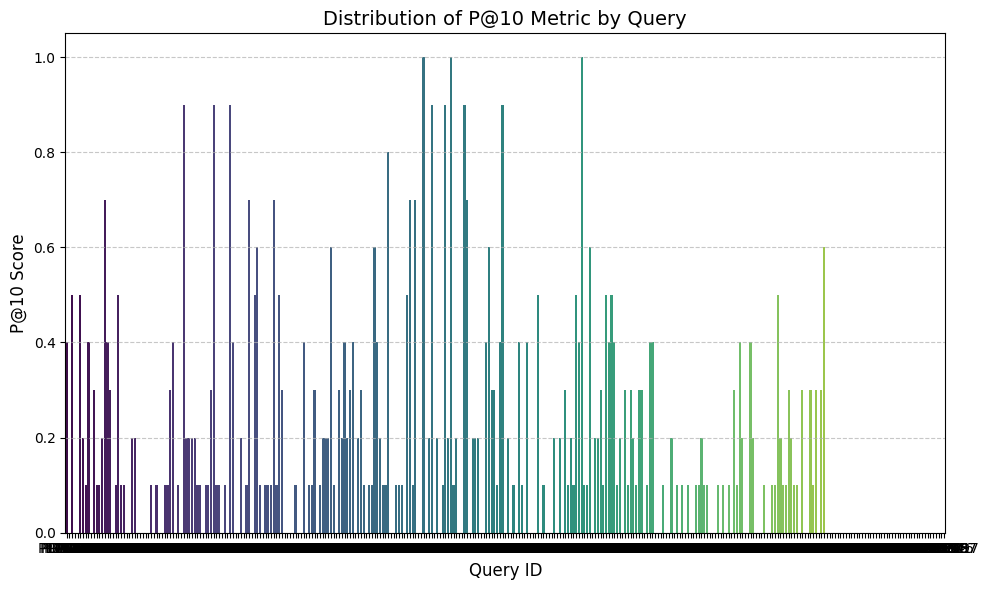

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=eval_topsis_df, x="qid", y="P@10", palette="viridis")
plt.title("Distribution of P@10 Metric by Query", fontsize=14)
plt.xlabel("Query ID", fontsize=12)
plt.ylabel("P@10 Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
joined_df = pd.merge(eval_topsis_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['P@10'] > 0.6]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid  P@10                                              query
0   PLAIN-2   0.4    do cholesterol statin drugs cause breast cancer
1  PLAIN-12   0.0                exploiting autophagy to live longer
2  PLAIN-23   0.5  how to reduce exposure to alkylphenols through...
3  PLAIN-33   0.0             whats driving americas obesity problem
4  PLAIN-44   0.0               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (P@10 > 0.6):")
filtered_df


Filtered DataFrame (P@10 > 0.6):


qid  P@10                                              query
14    PLAIN-153   0.7                       how should i take probiotics
43    PLAIN-488   0.9                                      adenovirus 36
54    PLAIN-660   0.9                                              beans
60    PLAIN-721   0.9                                               bmaa
67    PLAIN-806   0.7                                caloric restriction
76    PLAIN-913   0.7                                           cinnamon
118  PLAIN-1527   0.8                                      liver disease
126  PLAIN-1635   0.7                                               milk
128  PLAIN-1667   0.7                                      muscle health
131  PLAIN-1710   1.0                                 neurocysticercosis
134  PLAIN-1741   0.9                                               nuts
139  PLAIN-1805   0.9                                 parkinsons disease
141  PLAIN-1837   1.0                                         pesticides
146  PLAIN-1909   0.9                                               pork
147  PLAIN-1919   0.7                                    poultry workers
160  PLAIN-2102   0.9                                            smoking
189  PLAIN-2530   1.0  infectobesity adenovirus 36 and childhood obesity

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model = Word2Vec(sentences=filtered_df['query'], vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentence, model):
    valid_words = [word for word in sentence if word in model.wv]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
filtered_df['embedding'] = filtered_df['query'].apply(lambda x: get_sentence_embedding(x, model))

In [ ]:
embeddings = np.vstack(filtered_df['embedding'].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

# Display similarity matrix
print("Cosine Similarity Matrix:")
similarity_matrix


Cosine Similarity Matrix:


array([[ 1.0000001 ,  0.68425846,  0.3692727 ,  0.15270434,  0.71859723,
         0.40397838,  0.5984033 ,  0.3709197 ,  0.6045105 ,  0.659772  ,
         0.3868892 ,  0.72115165,  0.54679006,  0.4827908 ,  0.7196472 ,
         0.5609503 ,  0.8799967 ],
       [ 0.68425846,  1.0000001 ,  0.5766667 ,  0.25124562,  0.6231385 ,
         0.4416611 ,  0.7708061 ,  0.20078668,  0.5817501 ,  0.64383936,
         0.44790688,  0.7693976 ,  0.46723354,  0.35883194,  0.6835963 ,
         0.39603552,  0.8119436 ],
       [ 0.3692727 ,  0.5766667 ,  1.        ,  0.5902098 ,  0.3981055 ,
         0.44547284,  0.654033  ,  0.0296566 ,  0.47699463,  0.44861117,
         0.46793574,  0.7830582 ,  0.464825  ,  0.05461013,  0.30913845,
         0.2257113 ,  0.5826407 ],
       [ 0.15270434,  0.25124562,  0.5902098 ,  1.0000002 ,  0.03478233,
         0.25055954,  0.2904999 ,  0.2940071 ,  0.26771933, -0.03957894,
        -0.0394494 ,  0.3871227 ,  0.02802842,  0.11260265,  0.06684673,
         0.23441796

In [ ]:
most_similar_pairs = np.argwhere(similarity_matrix > 0.8)
most_similar_pairs = most_similar_pairs[most_similar_pairs[:, 0] != most_similar_pairs[:, 1]]

print("\nMost Similar Query Pairs (qid):")
for pair in most_similar_pairs:
    print(f"Query {filtered_df['qid'].iloc[pair[0]]} and Query {filtered_df['qid'].iloc[pair[1]]}")


Most Similar Query Pairs (qid):
Query PLAIN-153 and Query PLAIN-2530
Query PLAIN-488 and Query PLAIN-2530
Query PLAIN-806 and Query PLAIN-1710
Query PLAIN-1527 and Query PLAIN-1805
Query PLAIN-1710 and Query PLAIN-806
Query PLAIN-1805 and Query PLAIN-1527
Query PLAIN-1805 and Query PLAIN-2530
Query PLAIN-2530 and Query PLAIN-153
Query PLAIN-2530 and Query PLAIN-488
Query PLAIN-2530 and Query PLAIN-1805


In [ ]:
import random

unique_pairs = {(min(pair[0], pair[1]), max(pair[0], pair[1])) for pair in most_similar_pairs}
unique_pairs = list(unique_pairs)


random_pairs = random.sample(unique_pairs, min(10, len(unique_pairs)))

for i, pair in enumerate(random_pairs):
    print(f"Query {filtered_df['qid'].iloc[pair[0]]}: {filtered_df['query'].iloc[pair[0]]}")
    print(f"Query {filtered_df['qid'].iloc[pair[1]]}: {filtered_df['query'].iloc[pair[1]]}")
    print()

Query PLAIN-153: how should i take probiotics
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-806: caloric restriction
Query PLAIN-1710: neurocysticercosis

Query PLAIN-488: adenovirus 36
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-1527: liver disease
Query PLAIN-1805: parkinsons disease

Query PLAIN-1805: parkinsons disease
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity



#### BM25 results

In [ ]:
res = bm25_pipe.transform(queries[['qid','query']])
res.to_csv('bm25_results.csv', index=False)
display(res.head(5))

qid  docid     docno  rank      score  \
0  PLAIN-2      0    MED-10     0  16.903359   
1  PLAIN-2   1373  MED-2429     1  16.903359   
2  PLAIN-2      1    MED-14     2  16.149867   
3  PLAIN-2   1375  MED-2431     3  13.706007   
4  PLAIN-2   2728  MED-4391     4  11.250069   

                                             query  
0  do cholesterol statin drugs cause breast cancer  
1  do cholesterol statin drugs cause breast cancer  
2  do cholesterol statin drugs cause breast cancer  
3  do cholesterol statin drugs cause breast cancer  
4  do cholesterol statin drugs cause breast cancer

In [ ]:
mean_scores = res.groupby("query")["score"].mean().reset_index()
mean_scores.rename(columns={"score": "mean_score"}, inplace=True)

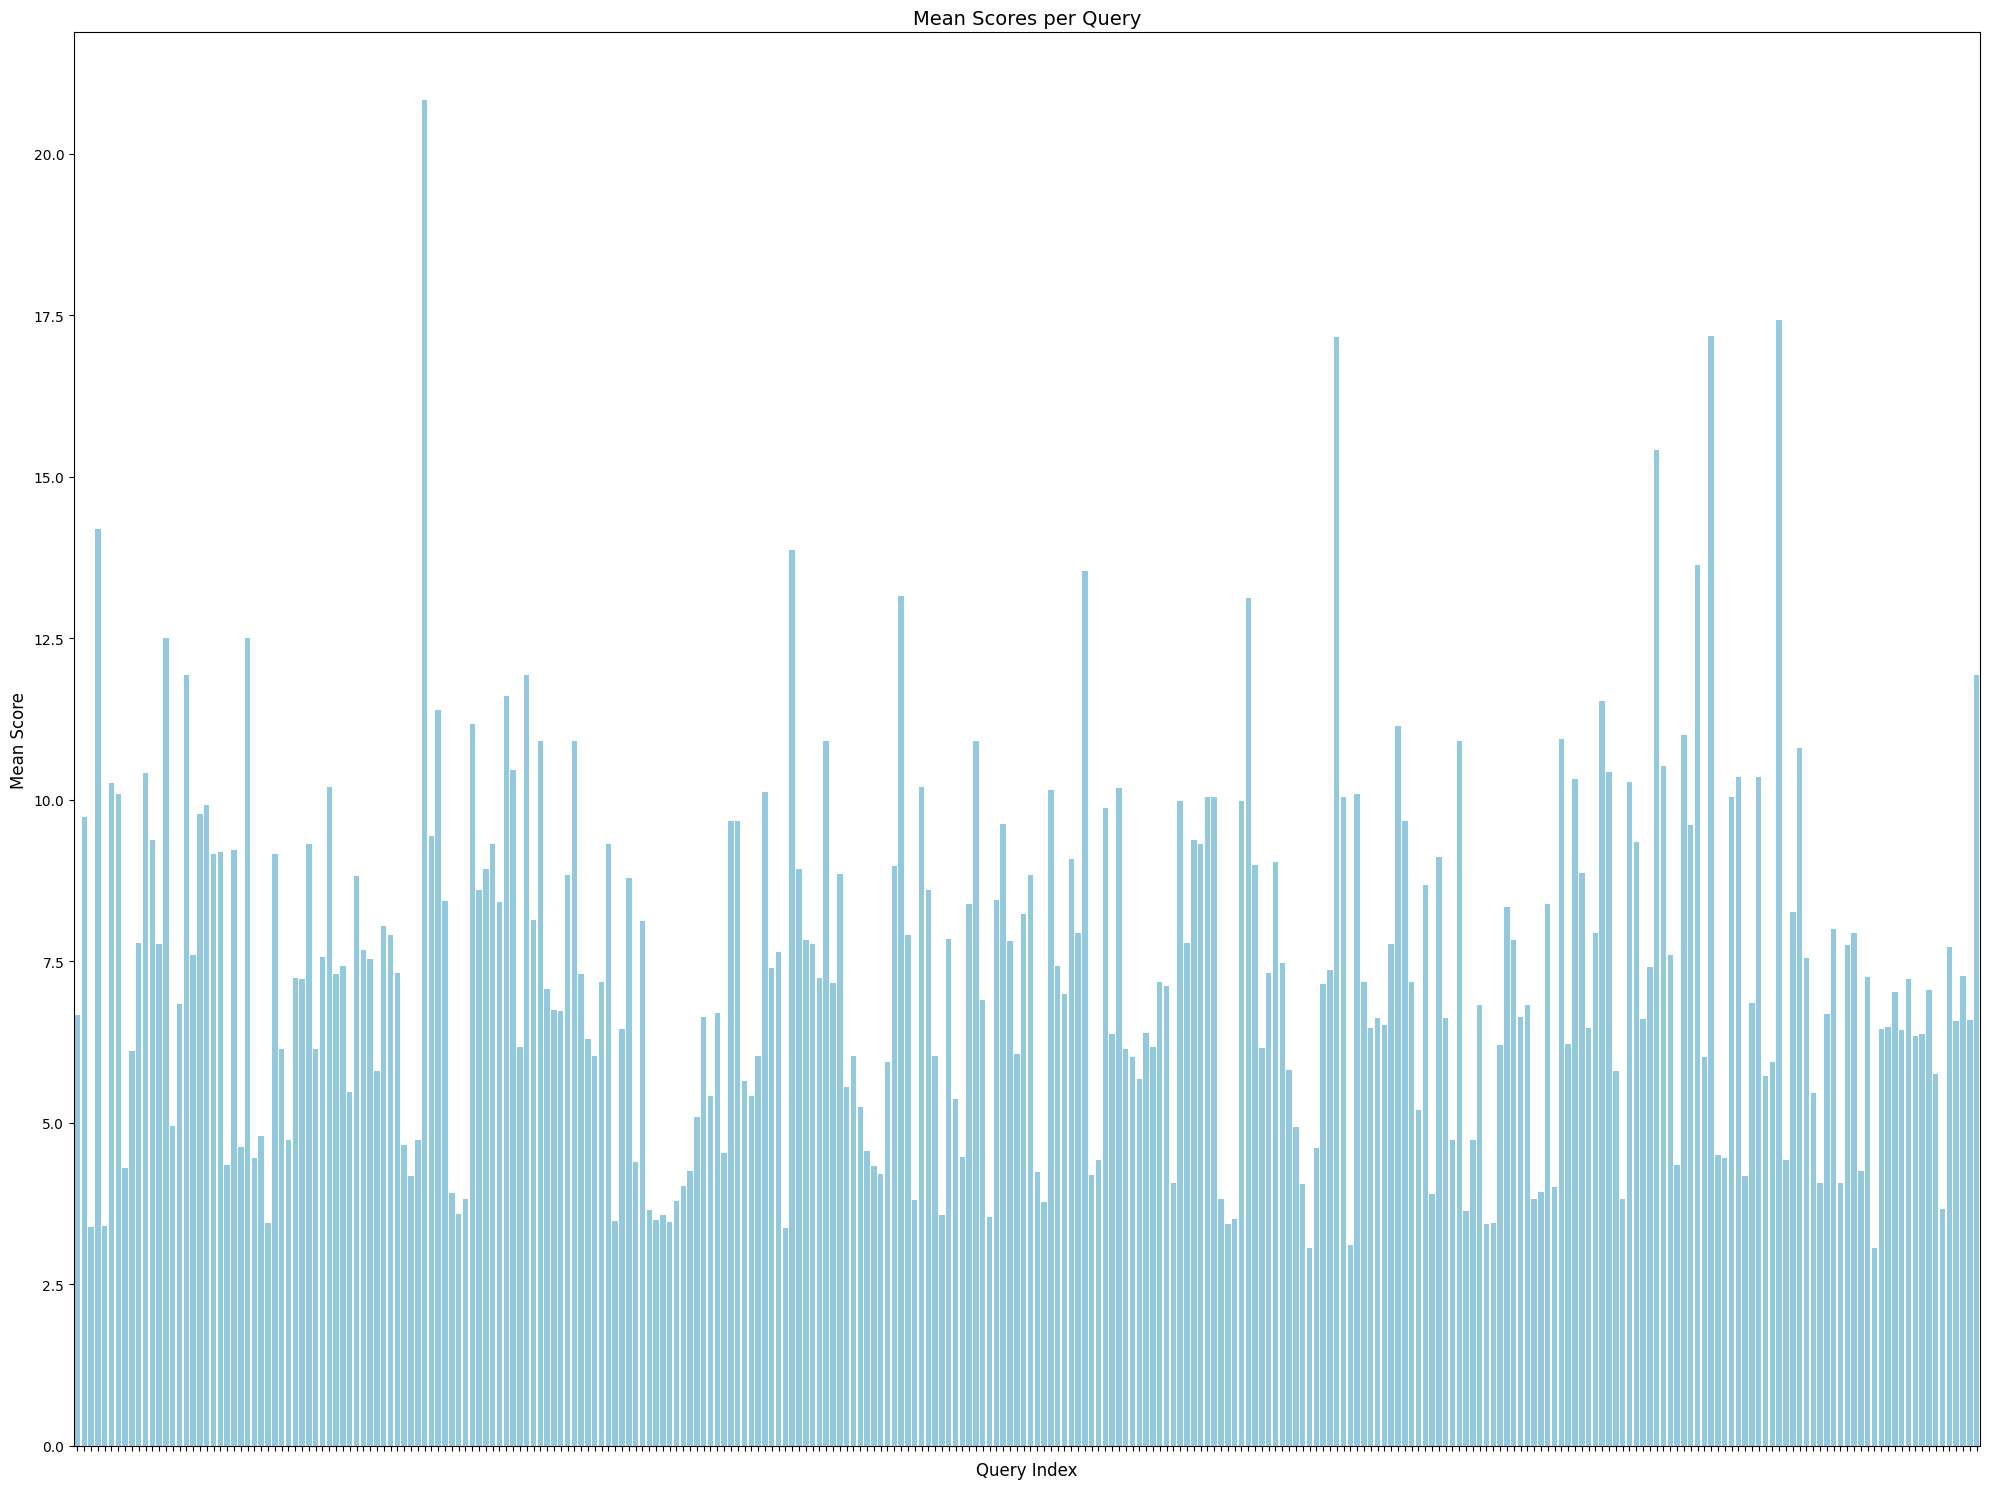

In [ ]:
plt.figure(figsize=(20, 15))
sns.barplot(x=range(len(mean_scores)), y=mean_scores["mean_score"], color="skyblue")
plt.title("Mean Scores per Query", fontsize=14)
plt.ylabel("Mean Score", fontsize=12)
plt.xlabel("Query Index", fontsize=12)
plt.xticks(range(len(mean_scores)), labels=[""] * len(mean_scores))
plt.tight_layout()
plt.show()

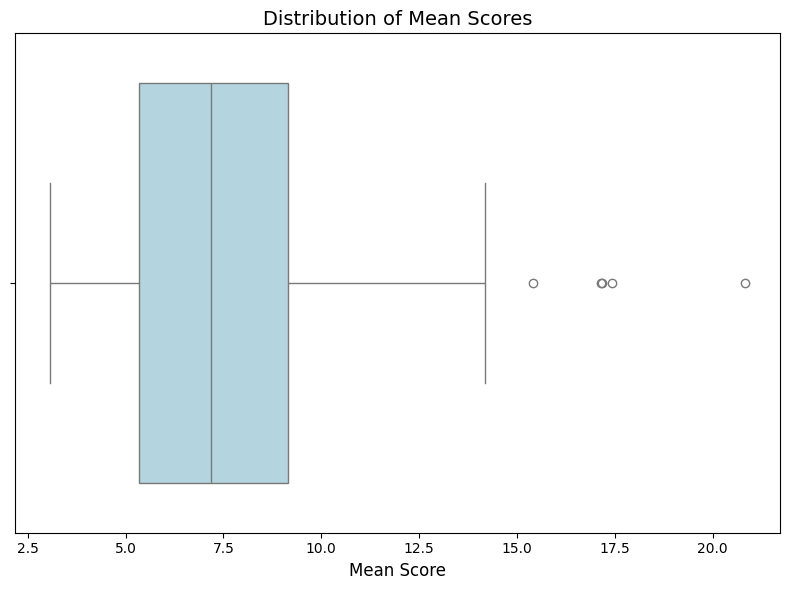

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=mean_scores["mean_score"], color="lightblue")
plt.title("Distribution of Mean Scores", fontsize=14)
plt.xlabel("Mean Score", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
poor_queries = mean_scores[mean_scores['mean_score'] < 4]
display(poor_queries)

query  mean_score
2                              acne  cancer connection    3.383402
4                            alcohol risks vs benefits    3.402553
28                                         atkins diet    3.454868
55             caloric restriction vs plantbased diets    3.914949
56   can antioxidantrich spices counteract the effe...    3.590357
57                  cancer risk from ct scan radiation    3.824150
79   counteracting the effects of dioxins through diet    3.474418
84   didnt another study show carnitine was good fo...    3.649430
85                                  diet and cellulite    3.499878
86          dietary guidelines from dairies to berries    3.568149
87                                     dietary scoring    3.468674
88                        dietary theory of alzheimers    3.789337
104                                         epic study    3.377322
123                     global burden of disease study    3.802398
127                        harvard physicians study ii    3.568930
134        how can you believe in any scientific study    3.542266
142                  human neurotransmitters in plants    3.778139
168                                      liver disease    3.812286
169                                      lowcarb diets    3.425874
170                                       lyme disease    3.502862
181                                       mouth cancer    3.057447
187                                      nihaarp study    3.099331
199                                 parkinsons disease    3.894440
204               phytates for the treatment of cancer    3.638249
207                                    plantbased diet    3.425874
208                     plantbased diets for psoriasis    3.455074
214                     preventing cataracts with diet    3.821890
215                       preventing strokes with diet    3.924706
227                  saturated fat  cancer progression    3.818192
264                                  veggies vs cancer    3.057447
274  what do you think of dr jenkins take on paleol...    3.663397

In [ ]:
display(len(poor_queries))

31

In [ ]:
eval_poor_query = pt.Evaluate(res, qrels, metrics=['map'],perquery=True)
display(eval_poor_query)

defaultdict(dict,
            {'PLAIN-2': {'map': 0.3147683464899224},
             'PLAIN-12': {'map': 0.0},
             'PLAIN-23': {'map': 0.06930698821945126},
             'PLAIN-33': {'map': 0.022225102531773983},
             'PLAIN-44': {'map': 0.027941458820595212},
             'PLAIN-56': {'map': 0.09099860763018658},
             'PLAIN-68': {'map': 0.043194631455501016},
             'PLAIN-78': {'map': 0.0076827955848321845},
             'PLAIN-91': {'map': 0.04397941468253968},
             'PLAIN-102': {'map': 0.0022246662792250347},
             'PLAIN-112': {'map': 0.026541341639008485},
             'PLAIN-123': {'map': 0.0196078431372549},
             'PLAIN-133': {'map': 0.008976882441794724},
             'PLAIN-143': {'map': 0.01633986928104575},
             'PLAIN-153': {'map': 0.20161743817958824},
             'PLAIN-165': {'map': 0.12515651139477244},
             'PLAIN-175': {'map': 0.09524940370020381},
             'PLAIN-186': {'map': 0.0039924506387

In [ ]:
eval_poor_query_df = pd.DataFrame.from_dict(eval_poor_query, orient='index').reset_index()
eval_poor_query_df.columns = ['qid', 'map']
display(eval_poor_query_df)

qid       map
0      PLAIN-2  0.314768
1     PLAIN-12  0.000000
2     PLAIN-23  0.069307
3     PLAIN-33  0.022225
4     PLAIN-44  0.027941
..         ...       ...
318  PLAIN-645  0.000000
319  PLAIN-741  0.000000
320  PLAIN-946  0.000000
321  PLAIN-987  0.000000
322  PLAIN-997  0.000000

[323 rows x 2 columns]

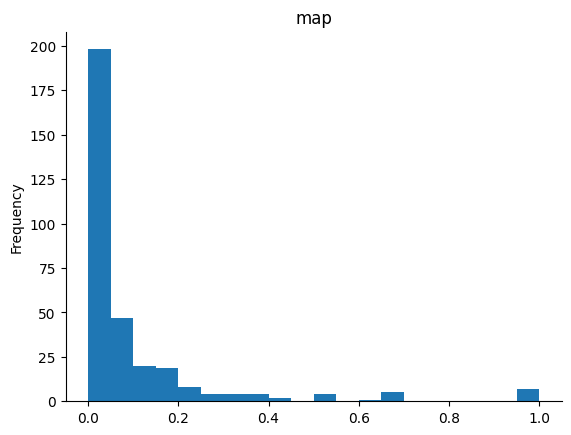

In [ ]:
eval_poor_query_df['map'].plot(kind='hist', bins=20, title='map')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
joined_df = pd.merge(eval_poor_query_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['map'] < 0.001]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid       map                                              query
0   PLAIN-2  0.314768    do cholesterol statin drugs cause breast cancer
1  PLAIN-12  0.000000                exploiting autophagy to live longer
2  PLAIN-23  0.069307  how to reduce exposure to alkylphenols through...
3  PLAIN-33  0.022225             whats driving americas obesity problem
4  PLAIN-44  0.027941               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (map < 0.001):")
filtered_df


Filtered DataFrame (map < 0.001):


qid  map                                              query
1     PLAIN-12  0.0                exploiting autophagy to live longer
22   PLAIN-238  0.0                 how chemically contaminated are we
32   PLAIN-358  0.0  didnt another study show carnitine was good fo...
35   PLAIN-395  0.0        what about pepper plus turmeric in v8 juice
42   PLAIN-478  0.0                                          accidents
..         ...  ...                                                ...
318  PLAIN-645  0.0                                             bagels
319  PLAIN-741  0.0                                                bph
320  PLAIN-946  0.0                                               coma
321  PLAIN-987  0.0                                              cumin
322  PLAIN-997  0.0                                     czechoslovakia

[97 rows x 3 columns]

In [ ]:
eval_topsis = pt.Evaluate(res, qrels, metrics=[P@10],perquery=True)
display(eval_topsis)

defaultdict(dict,
            {'PLAIN-2': {'P@10': 0.4},
             'PLAIN-12': {'P@10': 0.0},
             'PLAIN-23': {'P@10': 0.5},
             'PLAIN-33': {'P@10': 0.0},
             'PLAIN-44': {'P@10': 0.0},
             'PLAIN-56': {'P@10': 0.5},
             'PLAIN-68': {'P@10': 0.2},
             'PLAIN-78': {'P@10': 0.1},
             'PLAIN-91': {'P@10': 0.4},
             'PLAIN-102': {'P@10': 0.0},
             'PLAIN-112': {'P@10': 0.3},
             'PLAIN-123': {'P@10': 0.1},
             'PLAIN-133': {'P@10': 0.1},
             'PLAIN-143': {'P@10': 0.2},
             'PLAIN-153': {'P@10': 0.7},
             'PLAIN-165': {'P@10': 0.4},
             'PLAIN-175': {'P@10': 0.3},
             'PLAIN-186': {'P@10': 0.0},
             'PLAIN-196': {'P@10': 0.1},
             'PLAIN-207': {'P@10': 0.5},
             'PLAIN-217': {'P@10': 0.1},
             'PLAIN-227': {'P@10': 0.1},
             'PLAIN-238': {'P@10': 0.0},
             'PLAIN-248': {'P@10': 0.0},
        

In [ ]:
eval_topsis_df = pd.DataFrame.from_dict(eval_topsis, orient='index').reset_index()
eval_topsis_df.columns = ['qid', 'P@10']
display(eval_topsis_df)

qid  P@10
0      PLAIN-2   0.4
1     PLAIN-12   0.0
2     PLAIN-23   0.5
3     PLAIN-33   0.0
4     PLAIN-44   0.0
..         ...   ...
318  PLAIN-645   0.0
319  PLAIN-741   0.0
320  PLAIN-946   0.0
321  PLAIN-987   0.0
322  PLAIN-997   0.0

[323 rows x 2 columns]

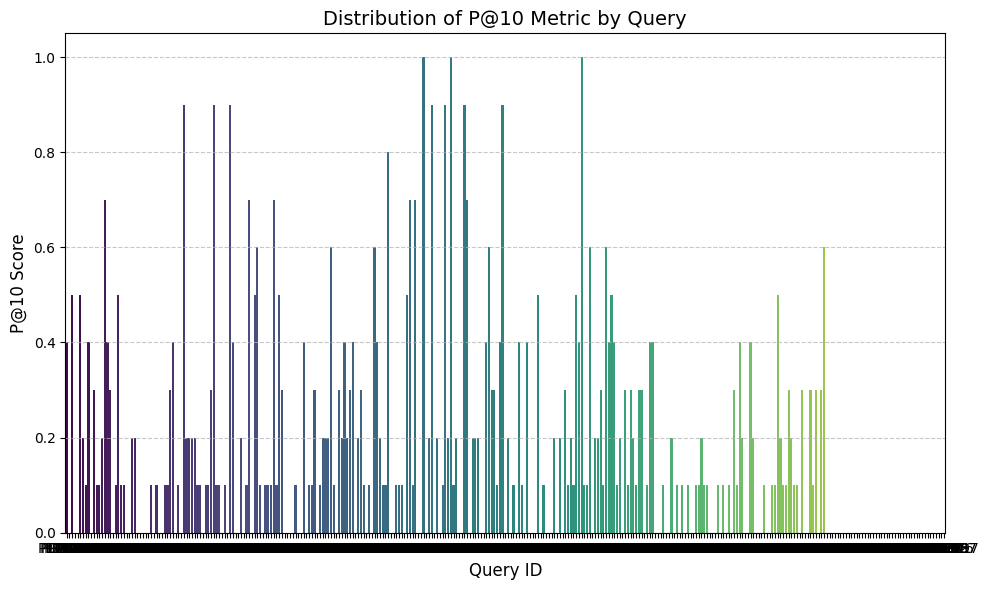

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=eval_topsis_df, x="qid", y="P@10", palette="viridis")
plt.title("Distribution of P@10 Metric by Query", fontsize=14)
plt.xlabel("Query ID", fontsize=12)
plt.ylabel("P@10 Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
joined_df = pd.merge(eval_topsis_df, queries, on='qid', how='inner')
filtered_df = joined_df[joined_df['P@10'] > 0.6]
print("Joined DataFrame:")
joined_df.head()

Joined DataFrame:


qid  P@10                                              query
0   PLAIN-2   0.4    do cholesterol statin drugs cause breast cancer
1  PLAIN-12   0.0                exploiting autophagy to live longer
2  PLAIN-23   0.5  how to reduce exposure to alkylphenols through...
3  PLAIN-33   0.0             whats driving americas obesity problem
4  PLAIN-44   0.0               who should be careful about curcumin

In [ ]:
print("\nFiltered DataFrame (P@10 > 0.6):")
filtered_df


Filtered DataFrame (P@10 > 0.6):


qid  P@10                                              query
14    PLAIN-153   0.7                       how should i take probiotics
43    PLAIN-488   0.9                                      adenovirus 36
54    PLAIN-660   0.9                                              beans
60    PLAIN-721   0.9                                               bmaa
67    PLAIN-806   0.7                                caloric restriction
76    PLAIN-913   0.7                                           cinnamon
118  PLAIN-1527   0.8                                      liver disease
126  PLAIN-1635   0.7                                               milk
128  PLAIN-1667   0.7                                      muscle health
131  PLAIN-1710   1.0                                 neurocysticercosis
134  PLAIN-1741   0.9                                               nuts
139  PLAIN-1805   0.9                                 parkinsons disease
141  PLAIN-1837   1.0                                         pesticides
146  PLAIN-1909   0.9                                               pork
147  PLAIN-1919   0.7                                    poultry workers
160  PLAIN-2102   0.9                                            smoking
189  PLAIN-2530   1.0  infectobesity adenovirus 36 and childhood obesity

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model = Word2Vec(sentences=filtered_df['query'], vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentence, model):
    valid_words = [word for word in sentence if word in model.wv]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
filtered_df['embedding'] = filtered_df['query'].apply(lambda x: get_sentence_embedding(x, model))

In [ ]:
embeddings = np.vstack(filtered_df['embedding'].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

# Display similarity matrix
print("Cosine Similarity Matrix:")
similarity_matrix

Cosine Similarity Matrix:


array([[ 1.0000001 ,  0.68425846,  0.3692727 ,  0.15270434,  0.71859723,
         0.40397838,  0.5984033 ,  0.3709197 ,  0.6045105 ,  0.659772  ,
         0.3868892 ,  0.72115165,  0.54679006,  0.4827908 ,  0.7196472 ,
         0.5609503 ,  0.8799967 ],
       [ 0.68425846,  1.0000001 ,  0.5766667 ,  0.25124562,  0.6231385 ,
         0.4416611 ,  0.7708061 ,  0.20078668,  0.5817501 ,  0.64383936,
         0.44790688,  0.7693976 ,  0.46723354,  0.35883194,  0.6835963 ,
         0.39603552,  0.8119436 ],
       [ 0.3692727 ,  0.5766667 ,  1.        ,  0.5902098 ,  0.3981055 ,
         0.44547284,  0.654033  ,  0.0296566 ,  0.47699463,  0.44861117,
         0.46793574,  0.7830582 ,  0.464825  ,  0.05461013,  0.30913845,
         0.2257113 ,  0.5826407 ],
       [ 0.15270434,  0.25124562,  0.5902098 ,  1.0000002 ,  0.03478233,
         0.25055954,  0.2904999 ,  0.2940071 ,  0.26771933, -0.03957894,
        -0.0394494 ,  0.3871227 ,  0.02802842,  0.11260265,  0.06684673,
         0.23441796

In [ ]:
most_similar_pairs = np.argwhere(similarity_matrix > 0.8)
most_similar_pairs = most_similar_pairs[most_similar_pairs[:, 0] != most_similar_pairs[:, 1]]

print("\nMost Similar Query Pairs (qid):")
for pair in most_similar_pairs:
    print(f"Query {filtered_df['qid'].iloc[pair[0]]} and Query {filtered_df['qid'].iloc[pair[1]]}")


Most Similar Query Pairs (qid):
Query PLAIN-153 and Query PLAIN-2530
Query PLAIN-488 and Query PLAIN-2530
Query PLAIN-806 and Query PLAIN-1710
Query PLAIN-1527 and Query PLAIN-1805
Query PLAIN-1710 and Query PLAIN-806
Query PLAIN-1805 and Query PLAIN-1527
Query PLAIN-1805 and Query PLAIN-2530
Query PLAIN-2530 and Query PLAIN-153
Query PLAIN-2530 and Query PLAIN-488
Query PLAIN-2530 and Query PLAIN-1805


In [ ]:
import random

unique_pairs = {(min(pair[0], pair[1]), max(pair[0], pair[1])) for pair in most_similar_pairs}
unique_pairs = list(unique_pairs)


random_pairs = random.sample(unique_pairs, min(10, len(unique_pairs)))

for i, pair in enumerate(random_pairs):
    print(f"Query {filtered_df['qid'].iloc[pair[0]]}: {filtered_df['query'].iloc[pair[0]]}")
    print(f"Query {filtered_df['qid'].iloc[pair[1]]}: {filtered_df['query'].iloc[pair[1]]}")
    print()

Query PLAIN-488: adenovirus 36
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-1805: parkinsons disease
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-1527: liver disease
Query PLAIN-1805: parkinsons disease

Query PLAIN-153: how should i take probiotics
Query PLAIN-2530: infectobesity adenovirus 36 and childhood obesity

Query PLAIN-806: caloric restriction
Query PLAIN-1710: neurocysticercosis



# PART III: Improving the retrieval performance

To improve retrieval performance, we address the ambiguity in queries identified earlier. We test enhancements on the retrieval pipeline that previously performed best, which includes both 'title' and 'abstract' ('text').

## Query Expansion

In [ ]:
queries = pd.read_csv('/content/processed_query_no_stemming.csv')

In [ ]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

def expand_single_query(query: str, model, tokenizer, num_expansions: int = 3) -> list:
    """
    Expand a single search query using the Qwen model.
    """
    prompt = f"""The following query is part of a medical information retrieval task for the NFCorpus dataset.
    The queries in this dataset are often ambiguous, sometimes consisting of single words or vague phrases.
    Your task is to generate {num_expansions} expanded versions of the query that clarify the intent while remaining consistent with the original meaning.
    These expanded queries should include more descriptive language, synonyms, and context relevant to medical terminology and research.

    Original query: "{query}"

    Expanded queries (one per line):"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            num_return_sequences=1
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = response.split(prompt)[-1].strip()
    expansions = [q.strip() for q in generated_text.split('\n') if q.strip()]

    return expansions[:num_expansions]

def expand_queries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process queries one at a time using the Qwen model.
    """
    model_name = "Qwen/Qwen2.5-1.5B-Instruct"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map=device,
        trust_remote_code=True,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )

    result_df = df.copy()

    result_df['expanded_queries'] = result_df['processed_query'].apply(
        lambda x: expand_single_query(x, model, tokenizer)
    )

    return result_df


result_df = expand_queries(queries)

This prompt has been tailored for the NFCorpus dataset, focusing on medical information retrieval. Key updates include:  
1. **Dataset-Specific Context**: Specifies NFCorpus and its challenges with ambiguous queries.  
2. **Clarification Focus**: Expands queries to clarify intent while preserving original meaning.  
3. **Medical Relevance**: Adds descriptive language and relevant medical terminology.  
4. **Concise Output**: Outputs expansions one per line for easy parsing.  

The code utilizes the Qwen model to expand search queries in a DataFrame. Each query is processed to generate multiple expanded versions.

In [ ]:
result_df.to_csv('expanded_queries.csv', index=False)

In [ ]:
result_df["processed_expanded_queries"] = result_df.apply(
    lambda x: x["expanded_queries"][0], axis=1
)


In [ ]:
result_df.to_csv('expanded_queries_1.csv', index=False)

In [ ]:
pip install python-terrier

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.3 MB/s eta 0:00:00
  Created wheel for chest: filename=chest-0.2.3-py3-none-any.whl size=7611 sha256=7c6221d9187646dcedc508d7a49f6641b2fd5a1c

In [ ]:
from pyterrier.measures import *

In [ ]:
import pyterrier as pt

if not pt.started():
    pt.init()

<ipython-input-58-723b7dd8a6cc>:3: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import spacy
from functools import lru_cache

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import logging
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Corpus and Qrels

In [ ]:
input_file = "/content/processed_data_no_stemming.csv"

data = pd.read_csv(input_file)

data.head()

text  \
0  Recent studies have suggested that statins, an...   
1  BACKGROUND: Preclinical studies have shown tha...   
2  The aims of this study were to determine the c...   
3  Epilepsy or seizure disorder is one of the mos...   
4  Hit Reaction Time latencies (HRT) in the Conti...   

                                               title   doc_id  \
0  Statin Use and Breast Cancer Survival: A Natio...   MED-10   
1  Statin use after diagnosis of breast cancer an...   MED-14   
2  Alkylphenols in human milk and their relations...  MED-118   
3  Methylmercury: A Potential Environmental Risk ...  MED-301   
4  Sensitivity of Continuous Performance Test (CP...  MED-306   

                                      processed_text  term_count_original  \
0  recent studies suggested statins established d...                  285   
1  background preclinical studies shown statins p...                  284   
2  aims study determine concentrations nonylpheno...                  210   
3  epilepsy seizure disorder common neurological ...                  199   
4  hit reaction time latencies hrt continuous per...                  312   

   term_count_processed  
0                   162  
1                   147  
2                   112  
3                   110  
4                   159

In [ ]:
data = data.drop(columns=['term_count_original', 'term_count_processed', 'text'])
data = data.rename(columns={'doc_id': 'docno', 'processed_text': 'text'})

In [ ]:
meta = ['docno', 'title']

In [ ]:
indexer = pt.IterDictIndexer(f'./index_weakporter', meta=meta, stemmer=pt.TerrierStemmer.weakporter, overwrite=True)

In [ ]:
index_ref = indexer.index(data.to_dict(orient='records'))

In [ ]:
print(pt.IndexFactory.of(index_ref).getCollectionStatistics())

Number of documents: 3633
Number of terms: 19889
Number of postings: 299937
Number of fields: 0
Number of tokens: 473003
Field names: []
Positions:   false



In [ ]:
index = pt.IndexFactory.of(index_ref)

In [ ]:
csv_path = "/content/qrels.csv"
qrels = pd.read_csv(csv_path)

In [ ]:
qrels.head()

query_id    doc_id  relevance
0  PLAIN-2  MED-2427          2
1  PLAIN-2    MED-10          2
2  PLAIN-2  MED-2429          2
3  PLAIN-2  MED-2430          2
4  PLAIN-2  MED-2431          2

In [ ]:
qrels = qrels.rename(columns={
    "query_id": "qid",
    "doc_id": "docno",
    "relevance": "label"
})

qrels.head()

qid     docno  label
0  PLAIN-2  MED-2427      2
1  PLAIN-2    MED-10      2
2  PLAIN-2  MED-2429      2
3  PLAIN-2  MED-2430      2
4  PLAIN-2  MED-2431      2

## Experiments with Expanded Queries

 Testing **three different versions** of a query that have been generated through query expansion

In [ ]:
expanded_queries = pd.read_csv('/content/expanded_queries_1.csv')

In [ ]:
expand_queries = expanded_queries.drop(columns=['term_count_original', 'term_count_processed', 'query_text', 'expanded_queries'])
expand_queries = expand_queries.rename(columns={'query_id': 'qid', 'processed_query':'query'})

In [ ]:
expand_queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                          processed_expanded_queries  
0  - "Are there any studies on whether certain ty...  
1  1. "exploring methods to enhance autophagic pr...  
2  - "What are some dietary strategies for minimi...  
3  - "what factors contribute to America's high p...  
4  - Curcumin is an anti-inflammatory compound co...

In [ ]:
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F700-\U0001F77F"  # alchemical symbols
    u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    u"\U0001FA00-\U0001FA6F"  # Chess Symbols
    u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    u"\U00002702-\U000027B0"  # Dingbats
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+",
    flags=re.UNICODE,
)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    if any(char.isdigit() for char in word):
        return word
    return re.sub(r'(.)\1{2,}', r'\1\1', word)


def preprocess_query(query):
    try:
        query = BeautifulSoup(query, "html.parser").get_text().lower()
        query = re.sub(r'http\S+|www\.\S+', '', query)
        query = emoji_pattern.sub(r'', query)
        query = ' '.join(normalize_repeated_chars(word) for word in query.split())
        return query
    except Exception as e:
        logging.error(f"Error processing query: {query}\nError: {e}")
        return []

expand_queries['query_expanded'] = expand_queries['processed_expanded_queries'].apply(preprocess_query)

expand_queries['query_expanded'] = expand_queries['query_expanded'].str.strip()
expand_queries['query_expanded'] = expand_queries['query_expanded'].str.replace(r"[^a-zA-Z\s]", "", regex=True)
expand_queries['query_expanded'] = expand_queries['query_expanded'].str.strip()

<ipython-input-20-f3f349d3d3ee>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  query = BeautifulSoup(query, "html.parser").get_text().lower()


In [ ]:
expand_queries.drop(columns=['processed_expanded_queries'], inplace=True)
expand_queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  
0  are there any studies on whether certain types...  
1  exploring methods to enhance autophagic proces...  
2  what are some dietary strategies for minimizin...  
3  what factors contribute to americas high preva...  
4  curcumin is an antiinflammatory compound commo...

In [ ]:
expand_queries = expand_queries.drop(columns=['query'])
expand_queries = expand_queries.rename(columns={'query_expanded': 'query'})
expand_queries.head()

qid                                              query
0   PLAIN-2  are there any studies on whether certain types...
1  PLAIN-12  exploring methods to enhance autophagic proces...
2  PLAIN-23  what are some dietary strategies for minimizin...
3  PLAIN-33  what factors contribute to americas high preva...
4  PLAIN-44  curcumin is an antiinflammatory compound commo...

In [ ]:
queries = expand_queries

### TF-IDF and BM25

In [ ]:
tfidf_pipe = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25_pipe = pt.BatchRetrieve(index, wmodel="BM25")

<ipython-input-69-264508e5b688>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf_pipe = pt.BatchRetrieve(index, wmodel="TF_IDF")
<ipython-input-69-264508e5b688>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_pipe = pt.BatchRetrieve(index, wmodel="BM25")


In [ ]:
pipelines = [
    tfidf_pipe,  # TF-IDF
    bm25_pipe,   # BM25
]

In [ ]:
metrics = ['map', 'ndcg', 'P_10', 'recall_10']

In [ ]:
names = ["TF-IDF", "BM25"]

results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)

name    map   ndcg   P_10  recall_10
0  TF-IDF  0.107  0.282  0.168      0.113
1    BM25  0.109  0.284  0.172      0.116

### RM3

For the experiments, we also decided to include **BM25 with RM3 query expansion** and compare it with the baseline models.

In [ ]:
rm3 = pt.rewrite.RM3(index_ref)

In [ ]:
rm3_pipeline = (
    pt.terrier.Retriever(index_ref, wmodel="BM25") >>  # Initial retrieval
    rm3 >>                                           # RM3 query expansion
    pt.terrier.Retriever(index_ref, wmodel="BM25")    # Second retrieval with expanded query
)

In [ ]:
pipelines = [
    tfidf_pipe,  # TF-IDF
    bm25_pipe,   # BM25
    rm3_pipeline # BM25 with RM3 query expansion
]
names = ["TF-IDF", "BM25", "BM25 + RM3"]


In [ ]:
queries.head()

qid                                              query
0   PLAIN-2  are there any studies on whether certain types...
1  PLAIN-12  exploring methods to enhance autophagic proces...
2  PLAIN-23  what are some dietary strategies for minimizin...
3  PLAIN-33  what factors contribute to americas high preva...
4  PLAIN-44  curcumin is an antiinflammatory compound commo...

In [ ]:
results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)


name    map   ndcg   P_10  recall_10
0      TF-IDF  0.107  0.282  0.168      0.113
1        BM25  0.109  0.284  0.172      0.116
2  BM25 + RM3  0.121  0.318  0.186      0.126

### BM25 with Neural Re-ranking using BERT

In [ ]:
!pip install --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR

  Cloning https://github.com/Georgetown-IR-Lab/OpenNIR to /tmp/pip-req-build-om30kjcn
  Running command git clone --filter=blob:none --quiet https://github.com/Georgetown-IR-Lab/OpenNIR /tmp/pip-req-build-om30kjcn
  Resolved https://github.com/Georgetown-IR-Lab/OpenNIR to commit c1f71d2af4de162f8b7c464df4b88fb5f4b4b45d
  Preparing metadata (setup.py) ... done


In [ ]:
import onir_pt

In [ ]:
vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='title', vocab_config={'train': True})

bm25 = pt.BatchRetrieve(index, wmodel='BM25', metadata=["docno", "title"])

bm25_bert_pipeline = bm25 >> pt.text.get_text(index, "title") >> vbert

In [ ]:
pipelines = [
    tfidf_pipe,        # TF-IDF
    bm25_pipe,         # BM25
    rm3_pipeline,      # BM25 with RM3 query expansion
    bm25_bert_pipeline # BM25 with Neural Re-ranking using BERT
]

In [ ]:
names = ["TF-IDF", "BM25", "BM25 + RM3", "BM25 + BERT"]

results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)

[2025-01-15 14:49:08,136][onir_pt][DEBUG] using GPU (deterministic)
[2025-01-15 14:49:08,476][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/59149 s<?, ?it/s]

[2025-01-15 15:07:21,346][onir_pt][DEBUG] [finished] batches: [18:13] [59149it] [54.12it/s]


name    map   ndcg   P_10  recall_10
0       TF-IDF  0.107  0.282  0.168      0.113
1         BM25  0.109  0.284  0.172      0.116
2   BM25 + RM3  0.121  0.318  0.186      0.126
3  BM25 + BERT  0.016  0.150  0.021      0.009

In [ ]:
queries = pd.read_csv('/content/expanded_queries.csv')
queries.head()

query_text  query_id  \
0   Do Cholesterol Statin Drugs Cause Breast Cancer?   PLAIN-2   
1                Exploiting Autophagy to Live Longer  PLAIN-12   
2  How to Reduce Exposure to Alkylphenols Through...  PLAIN-23   
3          What’s Driving America’s Obesity Problem?  PLAIN-33   
4              Who Should be Careful About Curcumin?  PLAIN-44   

                                     processed_query  term_count_original  \
0    do cholesterol statin drugs cause breast cancer                    8   
1                exploiting autophagy to live longer                    5   
2  how to reduce exposure to alkylphenols through...                    9   
3             whats driving americas obesity problem                   10   
4               who should be careful about curcumin                    7   

   term_count_processed                                   expanded_queries  
0                     7  ['- "Are there any studies on whether certain ...  
1                     5  ['1. "exploring methods to enhance autophagic ...  
2                     9  ['- "What are some dietary strategies for mini...  
3                     5  ['- "what factors contribute to America\'s hig...  
4                     6  ['- Curcumin is an anti-inflammatory compound ...

In [ ]:
queries = queries.drop(columns=['term_count_original', 'term_count_processed', 'query_text'])
queries = queries.rename(columns={'query_id': 'qid', 'processed_query':'query'})
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                    expanded_queries  
0  ['- "Are there any studies on whether certain ...  
1  ['1. "exploring methods to enhance autophagic ...  
2  ['- "What are some dietary strategies for mini...  
3  ['- "what factors contribute to America\'s hig...  
4  ['- Curcumin is an anti-inflammatory compound ...

In [ ]:
import ast
queries['expanded_queries'] = queries['expanded_queries'].apply(ast.literal_eval)

print(queries['expanded_queries'][0])

['- "Are there any studies on whether certain types of cholesterol medication, such as statins, can potentially increase the risk of developing breast cancer?"', '- "What evidence exists regarding potential links between specific classes of cholesterol-lowering medications, like statins, and an increased likelihood of developing breast cancer?"', '- "Could you provide insights into if any particular cholesterol-regulating drugs, including statins, might be associated with an elevated chance of breast cancer occurrence?"']


In [ ]:
def preprocess_query_list(query_list):
    if isinstance(query_list, list):
        return [preprocess_query(query) for query in query_list]
    return query_list

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    if any(char.isdigit() for char in word):
        return word
    return re.sub(r'(.)\1{2,}', r'\1\1', word)


def preprocess_query(query):
    try:
        query = BeautifulSoup(query, "html.parser").get_text().lower()
        query = re.sub(r'http\S+|www\.\S+', '', query)
        query = emoji_pattern.sub(r'', query)
        query = ' '.join(normalize_repeated_chars(word) for word in query.split())
        return query
    except Exception as e:
        logging.error(f"Error processing query: {query}\nError: {e}")
        return []

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
queries['processed_expanded_queries'] = queries['expanded_queries'].apply(preprocess_query_list)

queries['processed_expanded_queries'] = queries['processed_expanded_queries'].apply(
    lambda x: [re.sub(r"[^a-zA-Z\s]", "", query).strip() for query in x] if isinstance(x, list) else x
)

<ipython-input-44-b81c87e3022e>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  query = BeautifulSoup(query, "html.parser").get_text().lower()


In [ ]:
queries['processed_expanded_queries'][0]

['are there any studies on whether certain types of cholesterol medication such as statins can potentially increase the risk of developing breast cancer',
 'what evidence exists regarding potential links between specific classes of cholesterollowering medications like statins and an increased likelihood of developing breast cancer',
 'could you provide insights into if any particular cholesterolregulating drugs including statins might be associated with an elevated chance of breast cancer occurrence']

In [ ]:
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                    expanded_queries  \
0  [- "Are there any studies on whether certain t...   
1  [1. "exploring methods to enhance autophagic p...   
2  [- "What are some dietary strategies for minim...   
3  [- "what factors contribute to America's high ...   
4  [- Curcumin is an anti-inflammatory compound c...   

                          processed_expanded_queries  
0  [are there any studies on whether certain type...  
1  [exploring methods to enhance autophagic proce...  
2  [what are some dietary strategies for minimizi...  
3  [what factors contribute to americas high prev...  
4  [curcumin is an antiinflammatory compound comm...

In [ ]:
queries = queries.rename(columns={'processed_expanded_queries':'query_expanded'})
queries.drop(columns=['expanded_queries'], inplace=True)
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  
0  [are there any studies on whether certain type...  
1  [exploring methods to enhance autophagic proce...  
2  [what are some dietary strategies for minimizi...  
3  [what factors contribute to americas high prev...  
4  [curcumin is an antiinflammatory compound comm...

In [ ]:
queries["processed_expanded_queries"] = queries.apply(
    lambda x: x["query_expanded"][1], axis=1
)
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  \
0  [are there any studies on whether certain type...   
1  [exploring methods to enhance autophagic proce...   
2  [what are some dietary strategies for minimizi...   
3  [what factors contribute to americas high prev...   
4  [curcumin is an antiinflammatory compound comm...   

                          processed_expanded_queries  
0  what evidence exists regarding potential links...  
1  investigating ways to boost autophagy to possi...  
2  how can i incorporate foods rich in antioxidan...  
3  which elements cause americans to have a highe...  
4  given its complex chemical structure and varia...

In [ ]:
queries_2 = queries.drop(columns=['query_expanded', 'query'])
queries_2 = queries_2.rename(columns={'processed_expanded_queries': 'query'})
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  \
0  [are there any studies on whether certain type...   
1  [exploring methods to enhance autophagic proce...   
2  [what are some dietary strategies for minimizi...   
3  [what factors contribute to americas high prev...   
4  [curcumin is an antiinflammatory compound comm...   

                          processed_expanded_queries  
0  what evidence exists regarding potential links...  
1  investigating ways to boost autophagy to possi...  
2  how can i incorporate foods rich in antioxidan...  
3  which elements cause americans to have a highe...  
4  given its complex chemical structure and varia...

In [ ]:
queries_2.head()

qid                                              query
0   PLAIN-2  what evidence exists regarding potential links...
1  PLAIN-12  investigating ways to boost autophagy to possi...
2  PLAIN-23  how can i incorporate foods rich in antioxidan...
3  PLAIN-33  which elements cause americans to have a highe...
4  PLAIN-44  given its complex chemical structure and varia...

In [ ]:
names = ["TF-IDF", "BM25", "BM25 + RM3", "BM25 + BERT"]

results = pt.Experiment(
    pipelines,
    queries_2,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)


[2025-01-15 15:14:27,613][onir_pt][DEBUG] using GPU (deterministic)
[2025-01-15 15:14:27,618][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/62606 s<?, ?it/s]

[2025-01-15 15:33:55,145][onir_pt][DEBUG] [finished] batches: [19:28] [62606it] [53.62it/s]


name    map   ndcg   P_10  recall_10
0       TF-IDF  0.086  0.254  0.142      0.092
1         BM25  0.088  0.256  0.143      0.092
2   BM25 + RM3  0.100  0.284  0.158      0.107
3  BM25 + BERT  0.010  0.141  0.016      0.002

In [ ]:
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  \
0  [are there any studies on whether certain type...   
1  [exploring methods to enhance autophagic proce...   
2  [what are some dietary strategies for minimizi...   
3  [what factors contribute to americas high prev...   
4  [curcumin is an antiinflammatory compound comm...   

                          processed_expanded_queries  
0  what evidence exists regarding potential links...  
1  investigating ways to boost autophagy to possi...  
2  how can i incorporate foods rich in antioxidan...  
3  which elements cause americans to have a highe...  
4  given its complex chemical structure and varia...

In [ ]:
queries_3 = queries[queries["query_expanded"].apply(lambda x: isinstance(x, list) and len(x) == 3)]

queries_3.reset_index(drop=True, inplace=True)

queries_3.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  \
0  [are there any studies on whether certain type...   
1  [exploring methods to enhance autophagic proce...   
2  [what are some dietary strategies for minimizi...   
3  [what factors contribute to americas high prev...   
4  [curcumin is an antiinflammatory compound comm...   

                          processed_expanded_queries  
0  what evidence exists regarding potential links...  
1  investigating ways to boost autophagy to possi...  
2  how can i incorporate foods rich in antioxidan...  
3  which elements cause americans to have a highe...  
4  given its complex chemical structure and varia...

In [ ]:
queries_3["processed_expanded_queries_3"] = queries_3.apply(
    lambda x: x["query_expanded"][2], axis=1
)
queries_3["processed_expanded_queries_3"].head()

<ipython-input-66-0b246d109db5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queries_3["processed_expanded_queries_3"] = queries_3.apply(


0    could you provide insights into if any particu...
1    examining techniques to promote autophagy to p...
2    in what ways can consuming certain vegetables ...
3    what causes american adults to be at an increa...
4    in light of current research findings there is...
Name: processed_expanded_queries_3, dtype: object

In [ ]:
queries_3 = queries_3.drop(columns=['query_expanded', 'query', 'processed_expanded_queries'])
queries_3 = queries_3.rename(columns={'processed_expanded_queries_3': 'query'})
queries.head()

qid                                              query  \
0   PLAIN-2    do cholesterol statin drugs cause breast cancer   
1  PLAIN-12                exploiting autophagy to live longer   
2  PLAIN-23  how to reduce exposure to alkylphenols through...   
3  PLAIN-33             whats driving americas obesity problem   
4  PLAIN-44               who should be careful about curcumin   

                                      query_expanded  \
0  [are there any studies on whether certain type...   
1  [exploring methods to enhance autophagic proce...   
2  [what are some dietary strategies for minimizi...   
3  [what factors contribute to americas high prev...   
4  [curcumin is an antiinflammatory compound comm...   

                          processed_expanded_queries  
0  what evidence exists regarding potential links...  
1  investigating ways to boost autophagy to possi...  
2  how can i incorporate foods rich in antioxidan...  
3  which elements cause americans to have a highe...  
4  given its complex chemical structure and varia...

In [ ]:
queries_3.head()

qid                                              query
0   PLAIN-2  could you provide insights into if any particu...
1  PLAIN-12  examining techniques to promote autophagy to p...
2  PLAIN-23  in what ways can consuming certain vegetables ...
3  PLAIN-33  what causes american adults to be at an increa...
4  PLAIN-44  in light of current research findings there is...

In [ ]:
names = ["TF-IDF", "BM25", "BM25 + RM3", "BM25 + BERT"]

results = pt.Experiment(
    pipelines,
    queries_3,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)


[2025-01-15 15:46:12,114][onir_pt][DEBUG] using GPU (deterministic)
[2025-01-15 15:46:12,118][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/69864 s<?, ?it/s]

[2025-01-15 16:08:07,725][onir_pt][DEBUG] [finished] batches: [21:56] [69864it] [53.10it/s]


name    map   ndcg   P_10  recall_10
0       TF-IDF  0.092  0.272  0.149      0.099
1         BM25  0.095  0.274  0.150      0.098
2   BM25 + RM3  0.113  0.304  0.170      0.106
3  BM25 + BERT  0.008  0.144  0.011      0.002

The **First Extended Version** produced the best performance across all metrics compared to the other extended versions, likely due to better alignment with the corpus's vocabulary and structure.

The **Second and Third Extended Versions** showed progressively worse performance, suggesting that the relevance of the added terms diminished, potentially diverging from the semantic space of the corpus.

This may be because the first generated phrases from the Qwen model were more consistent with the original queries, while the subsequent ones became increasingly less coherent. This decline could also be influenced by the prompt's requirement to generate three phrases for each query, potentially introducing less relevant or redundant terms in the process.

## Using Non-Expanded Queries

For the latest experiments, we decided to use the **regular queries** instead of the expanded ones and compare them with both the baseline models and the new models.

In [ ]:
queries = pd.read_csv('/content/processed_query_no_stemming.csv')
queries.head()

query_text  query_id  \
0   Do Cholesterol Statin Drugs Cause Breast Cancer?   PLAIN-2   
1                Exploiting Autophagy to Live Longer  PLAIN-12   
2  How to Reduce Exposure to Alkylphenols Through...  PLAIN-23   
3          What’s Driving America’s Obesity Problem?  PLAIN-33   
4              Who Should be Careful About Curcumin?  PLAIN-44   

                                     processed_query  term_count_original  \
0    do cholesterol statin drugs cause breast cancer                    8   
1                exploiting autophagy to live longer                    5   
2  how to reduce exposure to alkylphenols through...                    9   
3             whats driving americas obesity problem                   10   
4               who should be careful about curcumin                    7   

   term_count_processed  
0                     7  
1                     5  
2                     9  
3                     5  
4                     6

In [ ]:
queries = queries.drop(columns=['term_count_original', 'term_count_processed', 'query_text'])
queries = queries.rename(columns={'query_id': 'qid', 'processed_query': 'query'})
queries.head()

qid                                              query
0   PLAIN-2    do cholesterol statin drugs cause breast cancer
1  PLAIN-12                exploiting autophagy to live longer
2  PLAIN-23  how to reduce exposure to alkylphenols through...
3  PLAIN-33             whats driving americas obesity problem
4  PLAIN-44               who should be careful about curcumin

In [ ]:
tfidf_pipe = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25_pipe = pt.BatchRetrieve(index, wmodel="BM25")

<ipython-input-74-264508e5b688>:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf_pipe = pt.BatchRetrieve(index, wmodel="TF_IDF")
<ipython-input-74-264508e5b688>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_pipe = pt.BatchRetrieve(index, wmodel="BM25")


In [ ]:
metrics = ['map', 'ndcg', 'P_10', 'recall_10']

In [ ]:
rm3 = pt.rewrite.RM3(index_ref)

In [ ]:
rm3_pipeline = (
    pt.BatchRetrieve(index, wmodel="BM25") >>  # Initial retrieval
    rm3 >>                                           # RM3 query expansion
    pt.BatchRetrieve(index, wmodel="BM25")    # Second retrieval with expanded query
)

<ipython-input-77-7ad165f31608>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pt.BatchRetrieve(index, wmodel="BM25") >>  # Initial retrieval
<ipython-input-77-7ad165f31608>:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pt.BatchRetrieve(index, wmodel="BM25")    # Second retrieval with expanded query


In [ ]:
pipelines = [
    tfidf_pipe,        # TF-IDF
    bm25_pipe,         # BM25
    rm3_pipeline,      # BM25 with RM3 query expansion
    bm25_bert_pipeline # BM25 with Neural Re-ranking using BERT
]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/Magistrale/2°anno/IR/risultati'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
metrics = ['map', 'ndcg', 'P_10', 'recall_10']

In [ ]:
names = ["TF-IDF", "BM25", "BM25 + RM3", "BM25 + BERT"]

results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    save_format='trec',
    save_dir=save_dir,
    names=names
)

display(results)

[2025-01-15 11:07:51,761][onir_pt][DEBUG] using GPU (deterministic)
[2025-01-15 11:07:52,090][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/27343 s<?, ?it/s]

[2025-01-15 11:16:28,074][onir_pt][DEBUG] [finished] batches: [08:36] [27343it] [52.99it/s]


name    map   ndcg   P_10  recall_10
0       TF-IDF  0.143  0.289  0.226      0.145
1         BM25  0.143  0.289  0.225      0.144
2   BM25 + RM3  0.164  0.363  0.241      0.162
3  BM25 + BERT  0.063  0.181  0.084      0.062

Query expansion using Qwen introduces additional terms, likely increasing recall but reducing precision due to potential introduction of noise. The performance of **BM25 + RM3** with extended queries indicates a slight benefit, though not as substantial as with the original queries. This suggests that the extended terms may dilute the relevance signal in some cases.

Both **TF-IDF** and **BM25** yield nearly identical results across all metrics (especially with the original queries: `map=0.143`, `ndcg=0.289`, `P_10≈0.226`, `recall_10≈0.145` for both).
These results suggest that term-based models like TF-IDF and BM25 perform similarly in this domain.

The query expansion using the Qwen model does not notably improve these models because they primarily rely on lexical overlap between queries and documents.

Medical abstracts and titles often contain specialized vocabulary and are relatively concise. Term-based models are limited in capturing semantic relationships, particularly when queries and documents use synonyms or paraphrases. The extended queries may introduce terms not present in the abstracts, worsening performance.

**BM25 + RM3** outperforms the baseline, with improvements across all metrics. RM3 query expansion, which reweights terms based on pseudo-relevance feedback, significantly boosts NDCG and recall. This improvement suggests that RM3 can enhance query-document matching by adding semantically relevant terms.

In medical literature, the limited content (title and abstract) of documents may omit key terms. RM3 compensates for this by introducing terms that better align with document content, improving recall and ranking quality.

**BM25 + BERT** (Neural Re-ranking apporach) produces surprisingly poor results. The performance drop is significant compared to other methods, particularly in metrics like MAP and P@10 (using the best values obtained with the original queries:`P_10=0.084`, `recall_10=0.062`).

Neural re-rankers like BERT typically require sufficient context to make semantic matches effectively. The restricted length of the abstracts and titles may not provide enough information for the model to distinguish relevant documents effectively.

Query expansion using Qwen probably introduce noise (maybe adding terms that are not directly relevant to the corpus) or overly general terms, making it harder for BERT to determine relevance.

Medical abstracts contain highly specialized terms, which BM25 and RM3 can leverage effectively through term weighting, whereas neural models may require further fine-tuning on domain-specific data.

## Query Expansion Using Synonyms

As a last attempt, let's try expanding search queries with an additional technique by replacing words with their synonyms from WordNet, a lexical database. It begins by splitting each query into individual words. For each word, the code retrieves its synonyms from WordNet. If synonyms are found, the word is replaced with one of them; otherwise, the original word remains. The expanded query is then reconstructed by joining the words together.

We don't use the BM25 + BERT pipeline either, given the poor results already analyzed in the previous section.

In [ ]:
queries = pd.read_csv('/content/processed_query_no_stemming.csv')
queries.head()

query_text  query_id  \
0   Do Cholesterol Statin Drugs Cause Breast Cancer?   PLAIN-2   
1                Exploiting Autophagy to Live Longer  PLAIN-12   
2  How to Reduce Exposure to Alkylphenols Through...  PLAIN-23   
3          What’s Driving America’s Obesity Problem?  PLAIN-33   
4              Who Should be Careful About Curcumin?  PLAIN-44   

                                     processed_query  term_count_original  \
0    do cholesterol statin drugs cause breast cancer                    8   
1                exploiting autophagy to live longer                    5   
2  how to reduce exposure to alkylphenols through...                    9   
3             whats driving americas obesity problem                   10   
4               who should be careful about curcumin                    7   

   term_count_processed  
0                     7  
1                     5  
2                     9  
3                     5  
4                     6

In [ ]:
queries = queries.drop(columns=['term_count_original', 'term_count_processed', 'query_text'])
queries = queries.rename(columns={'query_id': 'qid', 'processed_query': 'query'})
queries.head()

qid                                              query
0   PLAIN-2    do cholesterol statin drugs cause breast cancer
1  PLAIN-12                exploiting autophagy to live longer
2  PLAIN-23  how to reduce exposure to alkylphenols through...
3  PLAIN-33             whats driving americas obesity problem
4  PLAIN-44               who should be careful about curcumin

In [ ]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

# Expand the query with thesaurus (WordNet)
def expand_queries_with_thesaurus(queries):
    expanded_queries = []

    for query in queries:
        words = query.split()  # split the query into words
        expanded_query = []

        for word in words:
            # look for synonyms for each word
            synonyms = set()
            for syn in wordnet.synsets(word):
                for lemma in syn.lemmas():
                    synonyms.add(lemma.name())
            synonyms.discard(word)

            if synonyms:
                expanded_query.append(synonyms.pop())
            else:
                expanded_query.append(word)

        expanded_queries.append(" ".join(expanded_query))

    return expanded_queries


expanded_queries = expand_queries_with_thesaurus(queries['query'])

expanded_queries = pd.DataFrame({
    'qid': queries['qid'],
    'query': expanded_queries
})

expanded_queries.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


qid                                              query
0   PLAIN-2  coif cholesterin statin_drug dose drive summit...
1  PLAIN-12                       work autophagy to be yearner
2  PLAIN-23  how to trim_back picture to alkylphenols throu...
3  PLAIN-33       whats drive United_States fleshiness trouble
4  PLAIN-44              WHO should cost thrifty nigh curcumin

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

@lru_cache(maxsize=1000)
def normalize_repeated_chars(word):
    if any(char.isdigit() for char in word):
        return word
    return re.sub(r'(.)\1{2,}', r'\1\1', word)


def preprocess_query(query):
    try:
        query = BeautifulSoup(query, "html.parser").get_text().lower()
        query = re.sub(r'http\S+|www\.\S+', '', query)
        query = emoji_pattern.sub(r'', query)
        query = ' '.join(normalize_repeated_chars(word) for word in query.split())
        return query
    except Exception as e:
        logging.error(f"Error processing query: {query}\nError: {e}")
        return []


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
expanded_queries['query'] = expanded_queries['query'].apply(preprocess_query)
expanded_queries['query'] = expanded_queries['query'].str.strip()
expanded_queries['query'] = expanded_queries['query'].str.replace(r"[^a-zA-Z\s]", "", regex=True)
expanded_queries['query'] = expanded_queries['query'].str.strip()
print(expanded_queries.columns)

Index(['qid', 'query'], dtype='object')


In [ ]:
pipelines = [
    tfidf_pipe,        # TF-IDF
    bm25_pipe,         # BM25
    rm3_pipeline     # BM25 with RM3 query expansion
]

In [ ]:
metrics = ['map', 'ndcg', 'P_10', 'recall_10']

In [ ]:
names = ["TF-IDF", "BM25", "BM25 + RM3"]

results = pt.Experiment(
    pipelines,
    expanded_queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    names=names
)

display(results)

name    map   ndcg   P_10  recall_10
0      TF-IDF  0.069  0.142  0.104      0.077
1        BM25  0.068  0.142  0.103      0.076
2  BM25 + RM3  0.086  0.207  0.117      0.086

The results are still worse compared to those obtained with the original queries, which means that it's very difficult to reformulate queries with such a specific vocabulary as medical terminology.

## BM25 with Neural Re-ranking using BioBERT

https://github.com/dmis-lab/biobert

In [ ]:
import pyterrier as pt
from pyterrier.transformer import TransformerBase
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
class BioBERTReRanker(TransformerBase):
    def __init__(self, model_name='dmis-lab/biobert-base-cased-v1.1'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.eval()
        if torch.cuda.is_available():
            self.model = self.model.to('cuda')

    def transform(self, input):
        scores = []
        for _, row in input.iterrows():
            encoding = self.tokenizer.encode_plus(
                row['query'], row['title'], add_special_tokens=True, return_tensors='pt'
            )
            if torch.cuda.is_available():
                encoding = {k: v.to('cuda') for k, v in encoding.items()}
            with torch.no_grad():
                outputs = self.model(**encoding)
                score = outputs.logits[0][1].item()
            scores.append(score)
        input['score'] = scores
        return input

In [ ]:
biobert_reranker = BioBERTReRanker()
bm25 = pt.terrier.Retriever(index, wmodel='BM25', metadata=["docno", "title"])
bm25_biobert_pipeline = bm25 >> pt.text.get_text(index, "title") >> biobert_reranker

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pipelines = [
    tfidf_pipe,        # TF-IDF
    bm25_pipe,         # BM25
    rm3_pipeline,      # BM25 with RM3 query expansion
    bm25_biobert_pipeline # BM25 with Neural Re-ranking using BioBERT
]

names = ["TF-IDF", "BM25", "BM25 + RM3", "BM25 + BioBERT"]

In [ ]:
metrics = ['map', 'ndcg', 'P_10', 'recall_10']

In [ ]:
results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=metrics,
    round={"map": 3, "ndcg": 3, "P_10": 3, "recall_10": 3},
    save_format='trec',
    save_dir=save_dir,
    names=names
)

display(results)

/usr/local/lib/python3.11/dist-packages/pyterrier/pipelines.py:301: UserWarning: save_dir is set, but the file '/content/drive/MyDrive/ris/TF-IDF.res.gz' already exists. If you are aware of are happy to reuse this file to speed up evaluation, set save_mode='reuse'; if you want to overwrite it, set save_mode='overwrite'. To make this condition an error, use save_mode='error'.
  warn(("save_dir is set, but the file '%s' already exists. If you are aware of are happy to reuse this " % save_file)+
/usr/local/lib/python3.11/dist-packages/pyterrier/pipelines.py:301: UserWarning: save_dir is set, but the file '/content/drive/MyDrive/ris/BM25.res.gz' already exists. If you are aware of are happy to reuse this file to speed up evaluation, set save_mode='reuse'; if you want to overwrite it, set save_mode='overwrite'. To make this condition an error, use save_mode='error'.
  warn(("save_dir is set, but the file '%s' already exists. If you are aware of are happy to reuse this " % save_file)+
/usr/l

name    map   ndcg   P_10  recall_10
0          TF-IDF  0.143  0.289  0.226      0.145
1            BM25  0.143  0.289  0.225      0.144
2      BM25 + RM3  0.164  0.363  0.241      0.162
3  BM25 + BioBERT  0.058  0.173  0.081      0.061

## Conclusions

Medical abstracts contain highly specialized vocabulary, which models like BM25 and RM3 are well-suited to handle due to their effective term-weighting mechanisms. In contrast, neural models such as BERT tend to underperform in this context, likely because they require additional fine-tuning on domain-specific data to fully capture the nuances of the medical domain.

The experiments show that **original queries consistently produce better results**, particularly with the BM25 + RM3 pipeline. This suggests that the original query terms are highly aligned with the content of relevant documents, maximizing precision and recall. On the other hand, extended queries, while potentially enriching the search space, often introduce noise or less relevant terms, leading to diminished performance.

Overall, BM25 combined with RM3 proves to be the most robust and effective approach for retrieving information from a corpus consisting solely of titles and abstracts.